# Import Library

In [ ]:
import copy
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, random_split

from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from tqdm import tqdm

# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
def set_seed(seed=42):
    # Set the seed for Python's built-in random number generator
    random.seed(seed)

    # Set the seed for NumPy's random number generator
    np.random.seed(seed)

    # Set the seed for PyTorch's random number generator
    torch.manual_seed(seed)

    # If using GPU for training, set the seed for CUDA's random number generator
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multiple GPUs

    # Ensure reproducibility in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the random seed
set_seed(42)

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Data

In [ ]:
def load_dataset(file_path):
    """
    Load dataset from the given file path.

    Args:
    - file_path (str): The path to the dataset file (.npz).

    Returns:
    - X_train (ndarray): Training features.
    - y_train (ndarray): Training labels.
    - X_test (ndarray): Test features.
    - y_test (ndarray): Test labels.
    """
    data = np.load(file_path)
    X_train = data["X_tr"]
    y_train = data["S_tr"]
    X_test = data["X_ts"]
    y_test = data["Y_ts"]

    return X_train, y_train, X_test, y_test


X_train_03, y_train_03, X_test_03, y_test_03 = load_dataset("2024_A2_datasets/FashionMNIST0.3.npz")
X_train_06, y_train_06, X_test_06, y_test_06 = load_dataset("2024_A2_datasets/FashionMNIST0.6.npz")
X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar = load_dataset("2024_A2_datasets/CIFAR10.npz")

## Dataset

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initialize the FashionMNIST dataset.

        Args:
        images (np.ndarray): Image data.
        labels (np.ndarray): Label data.
        transform (callable, optional): Transformation function (if any).
        """
        self.images = images
        self.labels = labels.astype(int)
        self.transform = transform

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve a data sample by index and convert it to image format.

        Args:
        idx (int): Index of the data sample.

        Returns:
        Tuple[torch.Tensor, int]: A single sample and its corresponding label.
        """
        # Get features and label
        X = self.images[idx]
        y = int(self.labels[idx])

        # Convert to grayscale image
        X_img = Image.fromarray(X.astype(np.uint8), mode='L')

        if X_img.mode == 'L':
            X_img = X_img.convert('RGB')

        # Apply transformations if defined
        if self.transform:
            X_img = self.transform(X_img)

        return X_img, y

In [ ]:
class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initialize the CIFAR-10 dataset.

        Args:
        images (np.ndarray): Image data.
        labels (np.ndarray): Label data.
        transform (callable, optional): Transformation function (if any).
        """
        self.images = images
        self.labels = labels.astype(int)
        self.transform = transform

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve a data sample by index and convert it to RGB image format.

        Args:
        idx (int): Index of the data sample.

        Returns:
        Tuple[torch.Tensor, int]: A single sample and its corresponding label.
        """
        # Get features and label
        X = self.images[idx]
        y = int(self.labels[idx])

        # Convert to RGB image
        X_img = Image.fromarray(X.astype(np.uint8), mode='RGB')

        # Apply transformations if defined
        if self.transform:
            X_img = self.transform(X_img)

        return X_img, y


## Transition Matrix

In [ ]:
T_03 = torch.tensor([[0.7, 0.3, 0, 0],
                                     [0, 0.7, 0.3, 0],
                                     [0, 0, 0.7, 0.3],
                                     [0.3, 0, 0, 0.7]], dtype=torch.float32).to(device)
T_06= torch.tensor([[0.4, 0.2, 0.2, 0.2],
                                  [0.2, 0.4, 0.2, 0.2],
                                  [0.2, 0.2, 0.4, 0.2],
                                  [0.2, 0.2, 0.2, 0.4]], dtype=torch.float32).to(device)

## Transform

In [ ]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Models

## LeNet5

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=4, input_channels=3, input_size=28):
        super(LeNet5, self).__init__()

        # Feature extraction part
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        # Calculate the flattened input size
        self.flattened_size = self._get_flattened_size(input_size, input_channels)

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def _get_flattened_size(self, input_size, input_channels):
        # Use a dummy tensor to calculate the flattened size dynamically
        with torch.no_grad():
            x = torch.randn(1, input_channels, input_size, input_size)
            x = self.features(x)
            return x.view(-1).size(0)

    def forward(self, x):
        # Feature extraction part
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features

        # Classification part
        out = self.classifier(x)

        return out


## ResNet18

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsampling if input and output channels need adjustment
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Forward pass for the residual block
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Skip connection
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and pooling
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global average pooling
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Fully connected layer
        out = self.fc(x)

        return out

# Train

## Loss Function

In [ ]:
class ForwardLoss(nn.Module):
    def __init__(self, T):
        super(ForwardLoss, self).__init__()
        if isinstance(T, np.ndarray):
            T = torch.from_numpy(T).float()
        self.T = nn.Parameter(T, requires_grad=False)  # Set T as a non-trainable parameter

    def forward(self, out, target):
        device = out.device
        self.T = self.T.to(device)
        out_softmax = F.softmax(out, dim=1)

        total_loss = 0.
        batch_size = len(target)

        for i in range(batch_size):
            temp_softmax = out_softmax[i].unsqueeze(0)  # Add batch dimension
            temp = out[i].unsqueeze(0)  # Add batch dimension
            temp_target = target[i].unsqueeze(0)  # Add batch dimension

            pro1 = temp_softmax[:, target[i]]

            # Matrix multiplication without unnecessary transposes
            out_T = torch.matmul(temp_softmax, self.T)  # Simplified multiplication

            pro2 = out_T[:, target[i]]

            beta = pro1 / (pro2 + 1e-15)  # Avoid division by zero
            beta = beta.detach()  # Detach beta to avoid gradient computation

            cross_loss = F.cross_entropy(temp, temp_target)
            total_loss += beta * cross_loss

        return total_loss / batch_size  # Return the average loss

## Single Training

### Helper Function

In [ ]:
# The following functions are adapted from the work by Xiaobo Xia et al. (2019),
# "Are Anchor Points Really Indispensable in Label-Noise Learning?",
# presented at NeurIPS 2019.
# Source: https://github.com/xiaoboxia/T-Revision

def fit(X, num_classes, filter_outlier=False):
    # Number of classes
    c = num_classes
    T = np.empty((c, c))
    eta_corr = X

    for i in np.arange(c):
        if not filter_outlier:
            # Find the index of the maximum value in column i
            idx_best = np.argmax(eta_corr[:, i])
        else:
            # Use a copy to avoid modifying the original array
            robust_eta = eta_corr[:, i].copy()

            # Calculate the 97th percentile threshold, use 'method' parameter instead of 'interpolation'
            eta_thresh = np.percentile(robust_eta, 97, method='higher')

            # Set values above the threshold to a smaller value instead of 0.0 for numerical stability
            robust_eta[robust_eta >= eta_thresh] = np.min(robust_eta)

            # Recalculate idx_best
            idx_best = np.argmax(robust_eta)

        # Populate the transition matrix T based on idx_best
        for j in np.arange(c):
            T[i, j] = eta_corr[idx_best, j]

    return T

def norm(T):
    # Compute the sum of each row
    row_sum = np.sum(T, axis=1, keepdims=True)

    # To avoid division by zero, set zero rows to 1 for stability
    row_sum[row_sum == 0] = 1

    # Normalize T
    T_norm = T / row_sum
    return T_norm

### Estimate Transition Matrix

In [ ]:
# Adjusted train_epoch function
def train_epoch(model, train_loader, optimizer, loss_func):
    model.train()
    total_loss = 0.0
    total_correct = 0

    # Iterate over training data
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        optimizer.zero_grad()
        out = model(batch_x, revision=False)  # Revision parameter is no longer needed
        loss = loss_func(out, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate total loss and correct predictions
        total_loss += loss.item() * batch_x.size(0)
        pred = torch.max(out, 1)[1]
        total_correct += (pred == batch_y).sum().item()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_correct / len(train_loader.dataset)

    return avg_loss, avg_acc

# Adjusted validate_epoch function
def validate_epoch(model, val_loader, loss_func):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Move batch to GPU and convert labels to LongTensor
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            out = model(batch_x, revision=False)  # Revision parameter is no longer needed
            loss = loss_func(out, batch_y)

            # Accumulate total loss and correct predictions
            total_loss += loss.item()
            pred = torch.max(out, 1)[1]
            total_correct += (pred == batch_y).sum().item()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(val_loader.dataset) * val_loader.batch_size
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc


In [ ]:
def estimate_transition_matrix(model, train_loader, val_loader, estimate_loader, n_epoch_estimate, num_classes, optimizer_es, loss_func_ce, estimate_state=True):
    print("Estimating Transition Matrix...")
    index_num = int(len(estimate_loader.dataset) / estimate_loader.batch_size)
    A = torch.zeros((n_epoch_estimate, len(estimate_loader.dataset), num_classes)).to(device)
    val_acc_list = []

    total_steps = n_epoch_estimate * len(estimate_loader)  # Total number of steps

    with tqdm(total=total_steps, desc="Estimating Transition Matrix") as pbar:
        for epoch in range(n_epoch_estimate):
            total_train_loss = 0.0

            # Training phase
            model.train()
            for batch_x, batch_y in estimate_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer_es.zero_grad()

                # Forward pass
                out = model(batch_x, revision=False)
                loss = loss_func_ce(out, batch_y)

                # Backward pass and optimization
                loss.backward()
                optimizer_es.step()

                # Accumulate total training loss
                total_train_loss += loss.item()
                pbar.set_postfix({'Loss': total_train_loss / (pbar.n + 1)})  # Update loss dynamically
                pbar.update(1)

            # Validation phase
            val_loss, val_acc = validate_epoch(model, val_loader, loss_func_ce)
            val_acc_list.append(val_acc)

            # Transition matrix estimation phase
            model.eval()
            with torch.no_grad():
                for index, (batch_x, _) in enumerate(estimate_loader):
                    batch_x = batch_x.to(device)

                    # Forward pass
                    out = model(batch_x, revision=False)
                    out = F.softmax(out, dim=1)
                    out = out.cpu()

                    # Store probabilities in matrix A
                    if index <= index_num:
                        A[epoch][index * estimate_loader.batch_size : (index + 1) * estimate_loader.batch_size, :] = out
                    else:
                        A[epoch][index_num * estimate_loader.batch_size : len(estimate_loader.dataset), :] = out

    # Select the best epoch based on validation accuracy
    best_epoch = np.argmax(val_acc_list)
    best_prob = A[best_epoch, :, :]

    # Move the tensor to CPU before converting to numpy
    transition_matrix_ = fit(best_prob.cpu().numpy(), num_classes, estimate_state)
    transition_matrix = norm(transition_matrix_)
    print(f'\nEstimated Transition Matrix:\n{transition_matrix}')

    return transition_matrix

In [ ]:
def estimating(train_dataset, model, num_classes=4, n_epoch_estimate=20, batch_size=64, lr=0.001, weight_decay=1e-4):

    # Calculate the size of the training and validation sets
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size

    # Split the dataset using random_split
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    estimate_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    # Define the optimizer and learning rate scheduler
    optimizer_es = optim.Adam(model.parameters(), lr=lr)
    scheduler = MultiStepLR(optimizer_es, milestones=[40, 80], gamma=0.1)

    # Define the loss function
    loss_func_ce = nn.CrossEntropyLoss().to(device)

    # Estimate the transition matrix
    transition_matrix = estimate_transition_matrix(
        model, train_loader, val_loader, estimate_loader,
        n_epoch_estimate, num_classes, optimizer_es, loss_func_ce
    )

    return transition_matrix

### Training with estiamted T

In [ ]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training and validation loss and accuracy in a 2-column layout.
    Args:
        train_losses: List of training losses over epochs.
        val_losses: List of validation losses over epochs.
        train_accuracies: List of training accuracies over epochs.
        val_accuracies: List of validation accuracies over epochs.
    """
    # Create a 2-column subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot training and validation loss curves
    axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    axes[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Plot training and validation accuracy curves
    axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    axes[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_outputs(model, inputs, mode, criterion, device):

    outputs = model(inputs)

    if mode == 'forward':
        # Forward correction mode
        T = criterion.T.to(device)
        prob = F.softmax(outputs, dim=1)
        out_forward = torch.matmul(T.t(), prob.t()).t()
        return outputs, out_forward, None
    else:  # Base mode
        prob = F.softmax(outputs, dim=1)
        out_forward = prob
        return outputs, out_forward, None

def compute_loss(criterion, outputs, targets, mode):
    # Calculate loss based on mode (base or forward)
    return criterion(outputs, targets)

def train(model, train_loader, criterion, optimizer, device, epoch, mode):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch} Training") as pbar:
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Compute outputs and forward pass
            outputs, out_forward, _ = compute_outputs(model, inputs, mode, criterion, device)

            # Compute loss
            loss = compute_loss(criterion, outputs, targets, mode)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss and correct predictions
            running_loss += loss.item()
            _, predicted = torch.max(out_forward.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({'Loss': running_loss / (total // targets.size(0)), 'Acc': 100. * correct / total})
            pbar.update(1)

    return running_loss / len(train_loader), 100.0 * correct / total

def validate(model, val_loader, criterion, device, epoch, mode):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(val_loader), desc=f"Epoch {epoch} Validation") as pbar:
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Compute outputs and forward pass
                outputs, out_forward, _ = compute_outputs(model, inputs, mode, criterion, device)

                # Compute loss
                loss = compute_loss(criterion, outputs, targets, mode)

                # Accumulate validation loss and correct predictions
                val_loss += loss.item()
                _, predicted = torch.max(out_forward.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                pbar.update(1)

    avg_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

def test(model, test_loader, criterion, device, mode):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Compute outputs and forward pass
                outputs, out_forward, _ = compute_outputs(model, inputs, mode, criterion, device)

                # Compute loss
                loss = compute_loss(criterion, outputs, targets, mode)

                # Accumulate test loss and correct predictions
                test_loss += loss.item()
                _, predicted = torch.max(out_forward, 1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                pbar.update(1)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy


In [ ]:
def training(train_dataset, test_dataset, T, model, optimizer='Adam', mode='forward',
             num_classes=4, learning_rate=0.01, batch_size=64, num_epochs=100, weight_decay=1e-4, ini_model=True):
    if ini_model:
        # Deep copy the model if ini_model is set to True
        model = copy.deepcopy(model)

    # Calculate the size of training and validation sets
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size

    # Split the dataset using random_split
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Define loss function based on the mode
    if mode == 'forward':
        criterion = ForwardLoss(T)
    else:  # Base mode
        criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Lists to store training and validation losses, accuracies
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training and validation loop
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch, mode)
        val_loss, val_acc = validate(model, val_loader, criterion, device, epoch, mode)
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # Evaluation on the test set
    test_loss, test_acc = test(model, test_loader, criterion, device, mode)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, test_acc


## Multiple Training

In [ ]:
def plot_result(test_accuracies):
    """
    Plot final test accuracy for each run.
    Args:
        test_accuracies: List of final test accuracies from multiple runs.
    """
    runs = range(1, len(test_accuracies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(runs, test_accuracies, marker='o', linestyle='-', label='Test Accuracy')
    plt.title("Final Test Accuracy over Multiple Runs")
    plt.xlabel("Run")
    plt.ylabel("Accuracy (%)")
    plt.xticks(runs)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def multiple_training(train_dataset, test_dataset, T, n_runs=10, **training_params):
    """
    Perform multiple training runs and compute mean and std of final test accuracy.
    Args:
        train_dataset: Training dataset.
        test_dataset: Test dataset.
        T: Transition matrix.
        n_runs: Number of training runs.
        training_params: Other parameters for the training function.
    Returns:
        test_accuracies: List of final test accuracies from each run.
        mean_test_accuracy: Mean test accuracy over all runs.
        std_test_accuracy: Standard deviation of test accuracy over all runs.
    """
    test_accuracies = []  # List to store the final test accuracy of each run

    for run in range(n_runs):
        print(f"\n--- Run {run + 1}/{n_runs} ---")

        # Perform one training run
        model, _, _, _, _, test_acc = training(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            T=T,
            **training_params
        )

        # Record the final test accuracy of each run
        test_accuracies.append(test_acc)

    # Calculate the mean and standard deviation of final test accuracies
    mean_test_accuracy = np.mean(test_accuracies)
    std_test_accuracy = np.std(test_accuracies)

    # Print results
    print(f"\nMean Test Accuracy: {mean_test_accuracy:.2f}%")
    print(f"Standard Deviation of Test Accuracy: {std_test_accuracy:.2f}")

    return test_accuracies, mean_test_accuracy, std_test_accuracy


# Prepare Data

In [ ]:
train_data_03 = FashionMNISTDataset(images=X_train_03, labels=y_train_03, transform=transform)
test_data_03 = FashionMNISTDataset(images=X_test_03, labels=y_test_03, transform=transform)
train_data_06 = FashionMNISTDataset(images=X_train_06, labels=y_train_06, transform=transform)
test_data_06 = FashionMNISTDataset(images=X_test_06, labels=y_test_06, transform=transform)
train_data_cifar = CIFARDataset(images=X_train_cifar, labels=y_train_cifar, transform=transform)
test_data_cifar = CIFARDataset(images=X_test_cifar, labels=y_test_cifar, transform=transform)

# FashionMINIST0.3

In [ ]:
T_03

tensor([[0.7000, 0.3000, 0.0000, 0.0000],
        [0.0000, 0.7000, 0.3000, 0.0000],
        [0.0000, 0.0000, 0.7000, 0.3000],
        [0.3000, 0.0000, 0.0000, 0.7000]], device='cuda:0')

## LeNet_03

In [ ]:
LeNet_03 = LeNet5(input_channels=3, num_classes=4).to(device)

### Hyperparameter Tuning

#### Tuning for optimizer

In [ ]:
num_epochs = 5
batch_size = 64

In [ ]:
optimizer = 'SGD'
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,           
    mode='foward',                   
    learning_rate=0.01,              
    batch_size=batch_size,                
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.09it/s]


Validation Loss: 0.8014, Accuracy: 64.60%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.02it/s]


Validation Loss: 0.7587, Accuracy: 66.08%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.67it/s]


Validation Loss: 0.7436, Accuracy: 66.10%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.66it/s]


Validation Loss: 0.7492, Accuracy: 66.46%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.32it/s]


Validation Loss: 0.7305, Accuracy: 66.67%


Testing: 100%|██████████| 63/63 [00:00<00:00, 71.50it/s]

Test Loss: 0.4792, Accuracy: 93.67%


In [ ]:
optimizer = 'Adam'
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,           
    mode='foward',                   
    learning_rate=0.001,             
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 71.30it/s]


Validation Loss: 0.7559, Accuracy: 66.12%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.32it/s]


Validation Loss: 0.7318, Accuracy: 66.77%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.37it/s]


Validation Loss: 0.7260, Accuracy: 66.96%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 70.61it/s]


Validation Loss: 0.7171, Accuracy: 67.38%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 68.74it/s]


Validation Loss: 0.7025, Accuracy: 68.00%


Testing: 100%|██████████| 63/63 [00:00<00:00, 71.36it/s]

Test Loss: 0.4627, Accuracy: 94.72%


#### Tuning for learning rate

In [ ]:
num_epochs = 5
batch_size = 64
optimizer = 'Adam'

In [ ]:
learning_rate = 0.0005
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,           
    mode='foward',                   
    learning_rate=learning_rate,            
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.03it/s]


Validation Loss: 0.7780, Accuracy: 65.15%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 78.21it/s]


Validation Loss: 0.7523, Accuracy: 66.52%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 78.08it/s]


Validation Loss: 0.7413, Accuracy: 66.96%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.36it/s]


Validation Loss: 0.7338, Accuracy: 67.08%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.49it/s]


Validation Loss: 0.7347, Accuracy: 67.15%


Testing: 100%|██████████| 63/63 [00:00<00:00, 77.49it/s]

Test Loss: 0.5398, Accuracy: 92.50%


In [ ]:
learning_rate = 0.01
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,           
    mode='foward',                 
    learning_rate=learning_rate,            
    batch_size=batch_size,               
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 40.08it/s]


Validation Loss: 0.9418, Accuracy: 50.35%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 41.97it/s]


Validation Loss: 1.4961, Accuracy: 29.02%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 41.58it/s]


Validation Loss: 1.2761, Accuracy: 41.88%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 39.40it/s]


Validation Loss: 1.3343, Accuracy: 39.06%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 41.45it/s]


Validation Loss: 1.0407, Accuracy: 52.46%


Testing: 100%|██████████| 63/63 [00:01<00:00, 42.15it/s]

Test Loss: 0.7593, Accuracy: 71.92%


#### Tuning for batch size

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
num_epochs = 5

In [ ]:
batch_size = 32
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,         
    mode='foward',                  
    learning_rate=learning_rate,          
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 150/150 [00:01<00:00, 130.30it/s]


Validation Loss: 0.7711, Accuracy: 65.04%


Epoch 2 Validation: 100%|██████████| 150/150 [00:01<00:00, 127.81it/s]


Validation Loss: 0.7464, Accuracy: 65.58%


Epoch 3 Validation: 100%|██████████| 150/150 [00:01<00:00, 136.46it/s]


Validation Loss: 0.7332, Accuracy: 66.56%


Epoch 4 Validation: 100%|██████████| 150/150 [00:01<00:00, 131.55it/s]


Validation Loss: 0.7284, Accuracy: 66.52%


Epoch 5 Validation: 100%|██████████| 150/150 [00:01<00:00, 132.01it/s]


Validation Loss: 0.7177, Accuracy: 66.50%


Testing: 100%|██████████| 125/125 [00:01<00:00, 109.44it/s]

Test Loss: 0.4587, Accuracy: 94.53%


In [ ]:
batch_size = 128
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,          
    mode='foward',                  
    learning_rate=learning_rate,            
    batch_size=batch_size,               
    num_epochs=num_epochs                 
)

Epoch 1 Validation: 100%|██████████| 38/38 [00:00<00:00, 41.83it/s]


Validation Loss: 0.8023, Accuracy: 63.44%


Epoch 2 Validation: 100%|██████████| 38/38 [00:00<00:00, 42.92it/s]


Validation Loss: 0.7635, Accuracy: 64.46%


Epoch 3 Validation: 100%|██████████| 38/38 [00:00<00:00, 42.33it/s]


Validation Loss: 0.7510, Accuracy: 65.35%


Epoch 4 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.91it/s]


Validation Loss: 0.7641, Accuracy: 64.60%


Epoch 5 Validation: 100%|██████████| 38/38 [00:00<00:00, 43.84it/s]


Validation Loss: 0.7361, Accuracy: 65.71%


Testing: 100%|██████████| 32/32 [00:00<00:00, 44.59it/s]

Test Loss: 0.5148, Accuracy: 93.62%


#### Tuning for nums of epochs

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64

In [ ]:
num_epochs = 10
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,          
    mode='foward',                  
    learning_rate=learning_rate,         
    batch_size=batch_size,                
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.36it/s]


Validation Loss: 0.7823, Accuracy: 64.65%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.80it/s]


Validation Loss: 0.7432, Accuracy: 66.25%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.08it/s]


Validation Loss: 0.7365, Accuracy: 66.58%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.89it/s]


Validation Loss: 0.7242, Accuracy: 67.15%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.73it/s]


Validation Loss: 0.7233, Accuracy: 66.81%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.63it/s]


Validation Loss: 0.7215, Accuracy: 66.75%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.19it/s]


Validation Loss: 0.7050, Accuracy: 67.19%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.35it/s]


Validation Loss: 0.7089, Accuracy: 67.12%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.34it/s]


Validation Loss: 0.7065, Accuracy: 67.00%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.19it/s]


Validation Loss: 0.7087, Accuracy: 67.06%


Testing: 100%|██████████| 63/63 [00:01<00:00, 61.74it/s]

Test Loss: 0.4909, Accuracy: 94.95%


In [ ]:
num_epochs = 15
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,          
    mode='foward',                
    learning_rate=learning_rate,            
    batch_size=batch_size,                 
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.49it/s]


Validation Loss: 0.7587, Accuracy: 65.90%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.05it/s]


Validation Loss: 0.7290, Accuracy: 66.83%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.93it/s]


Validation Loss: 0.7151, Accuracy: 67.33%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.38it/s]


Validation Loss: 0.7176, Accuracy: 67.25%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.17it/s]


Validation Loss: 0.7069, Accuracy: 67.58%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.99it/s]


Validation Loss: 0.7095, Accuracy: 67.60%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.18it/s]


Validation Loss: 0.6980, Accuracy: 67.62%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.34it/s]


Validation Loss: 0.7025, Accuracy: 67.33%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.94it/s]


Validation Loss: 0.6940, Accuracy: 68.12%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.01it/s]


Validation Loss: 0.6925, Accuracy: 67.81%


Epoch 11 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.24it/s]


Validation Loss: 0.6902, Accuracy: 67.79%


Epoch 12 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.13it/s]


Validation Loss: 0.6904, Accuracy: 67.77%


Epoch 13 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.73it/s]


Validation Loss: 0.6919, Accuracy: 67.85%


Epoch 14 Validation: 100%|██████████| 75/75 [00:01<00:00, 68.58it/s]


Validation Loss: 0.6919, Accuracy: 67.77%


Epoch 15 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.44it/s]


Validation Loss: 0.6926, Accuracy: 67.73%


Testing: 100%|██████████| 63/63 [00:00<00:00, 73.91it/s]

Test Loss: 0.4432, Accuracy: 95.35%


### Comparison Experiment

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64
num_epochs = 15

In [ ]:
model_03_best, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,  
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,          
    mode='foward',                  
    learning_rate=learning_rate,           
    batch_size=batch_size,               
    num_epochs=num_epochs                 
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 78.22it/s]


Validation Loss: 0.7763, Accuracy: 64.08%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.59it/s]


Validation Loss: 0.7394, Accuracy: 65.56%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.31it/s]


Validation Loss: 0.7282, Accuracy: 66.06%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.60it/s]


Validation Loss: 0.7274, Accuracy: 65.96%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.47it/s]


Validation Loss: 0.7165, Accuracy: 66.50%


Epoch 6 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.03it/s]


Validation Loss: 0.7203, Accuracy: 66.52%


Epoch 7 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.85it/s]


Validation Loss: 0.7177, Accuracy: 66.19%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.39it/s]


Validation Loss: 0.7163, Accuracy: 66.77%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 70.67it/s]


Validation Loss: 0.7318, Accuracy: 66.25%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.57it/s]


Validation Loss: 0.7073, Accuracy: 66.38%


Epoch 11 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.52it/s]


Validation Loss: 0.7032, Accuracy: 66.62%


Epoch 12 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.92it/s]


Validation Loss: 0.7043, Accuracy: 66.65%


Epoch 13 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.19it/s]


Validation Loss: 0.7022, Accuracy: 66.62%


Epoch 14 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.47it/s]


Validation Loss: 0.7041, Accuracy: 66.83%


Epoch 15 Validation: 100%|██████████| 75/75 [00:01<00:00, 71.54it/s]


Validation Loss: 0.7053, Accuracy: 66.75%


Testing: 100%|██████████| 63/63 [00:00<00:00, 63.25it/s]

Test Loss: 0.4703, Accuracy: 95.08%


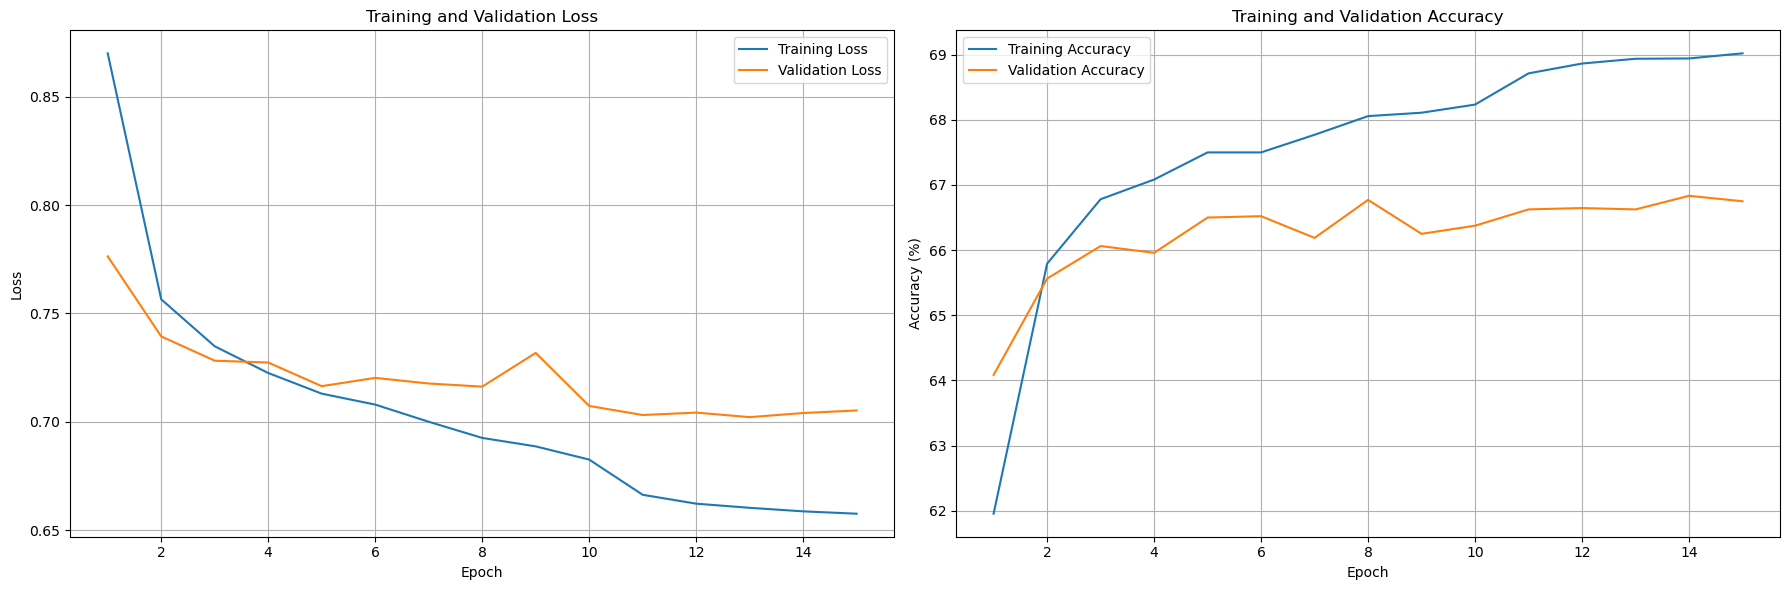

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
model_03_base, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = LeNet_03,           
    mode='base',                  
    learning_rate=learning_rate,           
    batch_size=batch_size,                
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.60it/s]


Validation Loss: 0.7759, Accuracy: 64.58%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.12it/s]


Validation Loss: 0.7629, Accuracy: 65.25%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.72it/s]


Validation Loss: 0.7417, Accuracy: 65.92%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.74it/s]


Validation Loss: 0.7348, Accuracy: 66.42%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.74it/s]


Validation Loss: 0.7264, Accuracy: 66.65%


Testing: 100%|██████████| 63/63 [00:00<00:00, 76.55it/s]

Test Loss: 0.5131, Accuracy: 93.67%


## Training for 10 times

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': LeNet_03,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 15
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_03,
    test_dataset=test_data_03,
    T=T_03,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.63it/s]


Validation Loss: 0.2593, Accuracy: 64.21%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.02it/s]


Validation Loss: 0.2098, Accuracy: 65.92%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.63it/s]


Validation Loss: 0.1976, Accuracy: 65.77%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.84it/s]


Validation Loss: 0.2062, Accuracy: 65.79%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.33it/s]


Validation Loss: 0.1729, Accuracy: 66.35%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.30it/s]


Validation Loss: 0.1568, Accuracy: 66.58%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.87it/s]


Validation Loss: 0.1762, Accuracy: 66.58%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.38it/s]


Validation Loss: 0.2001, Accuracy: 65.75%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.50it/s]


Validation Loss: 0.1724, Accuracy: 66.75%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.10it/s]


Validation Loss: 0.1347, Accuracy: 66.92%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.43it/s]


Validation Loss: 0.1404, Accuracy: 66.90%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.86it/s]


Validation Loss: 0.1428, Accuracy: 66.90%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.65it/s]


Validation Loss: 0.1498, Accuracy: 66.94%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.56it/s]


Validation Loss: 0.1375, Accuracy: 66.88%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.49it/s]


Validation Loss: 0.1465, Accuracy: 66.83%


Testing: 100%|██████████| 63/63 [00:01<00:00, 37.07it/s]


Test Loss: 0.1402, Accuracy: 95.30%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.42it/s]


Validation Loss: 0.2594, Accuracy: 64.81%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.36it/s]


Validation Loss: 0.2072, Accuracy: 66.52%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.45it/s]


Validation Loss: 0.1898, Accuracy: 66.00%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.25it/s]


Validation Loss: 0.1869, Accuracy: 67.10%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.95it/s]


Validation Loss: 0.1867, Accuracy: 66.90%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.41it/s]


Validation Loss: 0.1616, Accuracy: 66.90%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.90it/s]


Validation Loss: 0.1661, Accuracy: 67.21%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.66it/s]


Validation Loss: 0.1596, Accuracy: 67.29%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.67it/s]


Validation Loss: 0.1695, Accuracy: 67.02%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.46it/s]


Validation Loss: 0.1615, Accuracy: 67.40%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.45it/s]


Validation Loss: 0.1511, Accuracy: 67.48%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.42it/s]


Validation Loss: 0.1542, Accuracy: 67.21%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.89it/s]


Validation Loss: 0.1543, Accuracy: 67.19%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.78it/s]


Validation Loss: 0.1621, Accuracy: 67.25%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.40it/s]


Validation Loss: 0.1589, Accuracy: 67.27%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.99it/s]


Test Loss: 0.1443, Accuracy: 95.30%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.88it/s]


Validation Loss: 0.2937, Accuracy: 64.56%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.01it/s]


Validation Loss: 0.2389, Accuracy: 66.27%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.37it/s]


Validation Loss: 0.2042, Accuracy: 65.46%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.94it/s]


Validation Loss: 0.1726, Accuracy: 67.35%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.70it/s]


Validation Loss: 0.1912, Accuracy: 66.67%


Epoch 6 Validation: 100%|██████████| 75/75 [00:04<00:00, 16.31it/s]


Validation Loss: 0.2022, Accuracy: 67.25%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.38it/s]


Validation Loss: 0.1747, Accuracy: 65.96%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.81it/s]


Validation Loss: 0.1524, Accuracy: 67.31%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.29it/s]


Validation Loss: 0.1745, Accuracy: 67.15%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.09it/s]


Validation Loss: 0.1681, Accuracy: 67.44%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.26it/s]


Validation Loss: 0.1473, Accuracy: 67.77%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.73it/s]


Validation Loss: 0.1530, Accuracy: 67.62%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.57it/s]


Validation Loss: 0.1501, Accuracy: 67.69%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.34it/s]


Validation Loss: 0.1495, Accuracy: 67.75%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.63it/s]


Validation Loss: 0.1507, Accuracy: 67.69%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.29it/s]


Test Loss: 0.1428, Accuracy: 95.70%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.01it/s]


Validation Loss: 0.2164, Accuracy: 64.52%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.01it/s]


Validation Loss: 0.2297, Accuracy: 66.10%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.75it/s]


Validation Loss: 0.2143, Accuracy: 66.48%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.38it/s]


Validation Loss: 0.2073, Accuracy: 66.79%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.74it/s]


Validation Loss: 0.1718, Accuracy: 67.27%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.96it/s]


Validation Loss: 0.1937, Accuracy: 67.17%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.51it/s]


Validation Loss: 0.1826, Accuracy: 66.94%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.97it/s]


Validation Loss: 0.1680, Accuracy: 67.10%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.15it/s]


Validation Loss: 0.1458, Accuracy: 67.31%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.02it/s]


Validation Loss: 0.1741, Accuracy: 67.23%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.78it/s]


Validation Loss: 0.1524, Accuracy: 67.46%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.55it/s]


Validation Loss: 0.1552, Accuracy: 67.46%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.39it/s]


Validation Loss: 0.1497, Accuracy: 67.58%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.99it/s]


Validation Loss: 0.1453, Accuracy: 67.67%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.83it/s]


Validation Loss: 0.1459, Accuracy: 67.62%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.44it/s]


Test Loss: 0.1423, Accuracy: 95.47%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.28it/s]


Validation Loss: 0.2738, Accuracy: 65.27%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.42it/s]


Validation Loss: 0.1979, Accuracy: 66.40%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.54it/s]


Validation Loss: 0.1903, Accuracy: 67.00%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.63it/s]


Validation Loss: 0.1957, Accuracy: 65.52%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.01it/s]


Validation Loss: 0.1692, Accuracy: 67.73%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.02it/s]


Validation Loss: 0.1645, Accuracy: 67.62%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s]


Validation Loss: 0.1593, Accuracy: 67.42%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.27it/s]


Validation Loss: 0.1559, Accuracy: 68.02%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.34it/s]


Validation Loss: 0.1405, Accuracy: 67.98%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.40it/s]


Validation Loss: 0.1461, Accuracy: 67.69%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.19it/s]


Validation Loss: 0.1300, Accuracy: 68.23%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.59it/s]


Validation Loss: 0.1311, Accuracy: 68.06%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.18it/s]


Validation Loss: 0.1316, Accuracy: 68.06%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.16it/s]


Validation Loss: 0.1264, Accuracy: 68.25%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.14it/s]


Validation Loss: 0.1290, Accuracy: 68.21%


Testing: 100%|██████████| 63/63 [00:01<00:00, 33.83it/s]


Test Loss: 0.1355, Accuracy: 95.55%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.35it/s]


Validation Loss: 0.2394, Accuracy: 63.79%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.44it/s]


Validation Loss: 0.2052, Accuracy: 64.88%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.89it/s]


Validation Loss: 0.1814, Accuracy: 65.65%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.56it/s]


Validation Loss: 0.1982, Accuracy: 65.85%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.23it/s]


Validation Loss: 0.1619, Accuracy: 66.06%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.01it/s]


Validation Loss: 0.1599, Accuracy: 66.17%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.28it/s]


Validation Loss: 0.1733, Accuracy: 65.90%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.90it/s]


Validation Loss: 0.1699, Accuracy: 66.15%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.41it/s]


Validation Loss: 0.1598, Accuracy: 65.92%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.13it/s]


Validation Loss: 0.1682, Accuracy: 66.19%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.80it/s]


Validation Loss: 0.1340, Accuracy: 66.33%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.94it/s]


Validation Loss: 0.1341, Accuracy: 66.21%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.42it/s]


Validation Loss: 0.1344, Accuracy: 66.27%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.76it/s]


Validation Loss: 0.1346, Accuracy: 66.25%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.96it/s]


Validation Loss: 0.1320, Accuracy: 66.27%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.68it/s]


Test Loss: 0.1403, Accuracy: 95.62%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.25it/s]


Validation Loss: 0.2467, Accuracy: 65.21%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.27it/s]


Validation Loss: 0.1941, Accuracy: 66.21%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.90it/s]


Validation Loss: 0.2638, Accuracy: 65.71%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.64it/s]


Validation Loss: 0.1812, Accuracy: 67.15%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.28it/s]


Validation Loss: 0.1952, Accuracy: 66.98%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.30it/s]


Validation Loss: 0.1518, Accuracy: 67.12%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.89it/s]


Validation Loss: 0.1445, Accuracy: 67.54%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.27it/s]


Validation Loss: 0.1610, Accuracy: 67.12%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.28it/s]


Validation Loss: 0.1454, Accuracy: 67.60%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.46it/s]


Validation Loss: 0.1583, Accuracy: 67.65%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.15it/s]


Validation Loss: 0.1370, Accuracy: 67.77%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.98it/s]


Validation Loss: 0.1408, Accuracy: 67.77%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.17it/s]


Validation Loss: 0.1400, Accuracy: 67.75%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.89it/s]


Validation Loss: 0.1391, Accuracy: 67.69%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.60it/s]


Validation Loss: 0.1382, Accuracy: 67.71%


Testing: 100%|██████████| 63/63 [00:01<00:00, 36.00it/s]


Test Loss: 0.1421, Accuracy: 95.25%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.38it/s]


Validation Loss: 0.3626, Accuracy: 64.29%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.76it/s]


Validation Loss: 0.2501, Accuracy: 66.23%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.43it/s]


Validation Loss: 0.2401, Accuracy: 66.21%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.70it/s]


Validation Loss: 0.2505, Accuracy: 65.29%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.09it/s]


Validation Loss: 0.1629, Accuracy: 67.52%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.09it/s]


Validation Loss: 0.1680, Accuracy: 67.46%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.68it/s]


Validation Loss: 0.1536, Accuracy: 67.69%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.30it/s]


Validation Loss: 0.1503, Accuracy: 67.94%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.37it/s]


Validation Loss: 0.1583, Accuracy: 67.46%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.55it/s]


Validation Loss: 0.1427, Accuracy: 67.79%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.63it/s]


Validation Loss: 0.1357, Accuracy: 68.00%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.05it/s]


Validation Loss: 0.1251, Accuracy: 68.04%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.09it/s]


Validation Loss: 0.1243, Accuracy: 67.96%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.46it/s]


Validation Loss: 0.1222, Accuracy: 67.98%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.27it/s]


Validation Loss: 0.1238, Accuracy: 68.10%


Testing: 100%|██████████| 63/63 [00:01<00:00, 36.11it/s]


Test Loss: 0.1366, Accuracy: 95.38%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.47it/s]


Validation Loss: 0.2526, Accuracy: 65.52%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.25it/s]


Validation Loss: 0.1975, Accuracy: 66.00%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.75it/s]


Validation Loss: 0.2365, Accuracy: 66.38%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.48it/s]


Validation Loss: 0.1768, Accuracy: 66.50%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.30it/s]


Validation Loss: 0.1810, Accuracy: 66.50%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.43it/s]


Validation Loss: 0.1735, Accuracy: 66.77%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.58it/s]


Validation Loss: 0.1570, Accuracy: 67.12%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.86it/s]


Validation Loss: 0.1692, Accuracy: 67.12%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.05it/s]


Validation Loss: 0.2245, Accuracy: 66.25%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.09it/s]


Validation Loss: 0.1571, Accuracy: 67.04%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.83it/s]


Validation Loss: 0.1500, Accuracy: 67.50%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.48it/s]


Validation Loss: 0.1500, Accuracy: 67.65%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.10it/s]


Validation Loss: 0.1478, Accuracy: 67.65%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.10it/s]


Validation Loss: 0.1459, Accuracy: 67.62%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.57it/s]


Validation Loss: 0.1479, Accuracy: 67.58%


Testing: 100%|██████████| 63/63 [00:01<00:00, 36.28it/s]


Test Loss: 0.1386, Accuracy: 95.47%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.64it/s]


Validation Loss: 0.2282, Accuracy: 65.12%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.62it/s]


Validation Loss: 0.2049, Accuracy: 65.35%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.02it/s]


Validation Loss: 0.2141, Accuracy: 66.29%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.26it/s]


Validation Loss: 0.2042, Accuracy: 66.60%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.46it/s]


Validation Loss: 0.1802, Accuracy: 66.98%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.31it/s]


Validation Loss: 0.2159, Accuracy: 66.77%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.57it/s]


Validation Loss: 0.1775, Accuracy: 66.94%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.52it/s]


Validation Loss: 0.1601, Accuracy: 66.79%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.92it/s]


Validation Loss: 0.1691, Accuracy: 67.19%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.21it/s]


Validation Loss: 0.1449, Accuracy: 67.23%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.17it/s]


Validation Loss: 0.1406, Accuracy: 67.40%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.95it/s]


Validation Loss: 0.1468, Accuracy: 67.35%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.95it/s]


Validation Loss: 0.1413, Accuracy: 67.38%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.84it/s]


Validation Loss: 0.1469, Accuracy: 67.44%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.18it/s]


Validation Loss: 0.1420, Accuracy: 67.38%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.47it/s]

Test Loss: 0.1369, Accuracy: 95.58%

Mean Test Accuracy: 95.46%
Standard Deviation of Test Accuracy: 0.14


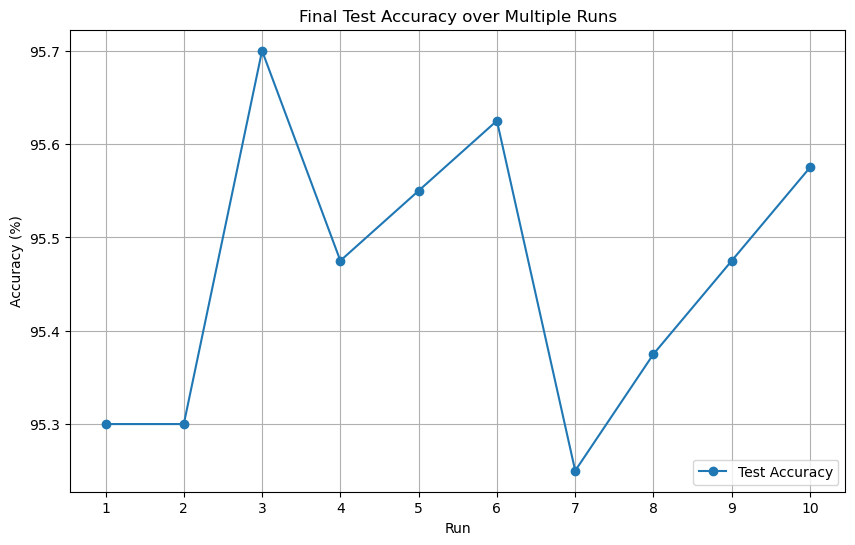

In [ ]:
plot_result(test_accuracies)

## ResNet_03

In [ ]:
resNet_03 = ResNet18(num_classes=4).to(device)

### Hyperparameter Tuning

#### Tuning for optimizer

In [ ]:
num_epochs = 5
batch_size = 64

In [ ]:
optimizer = 'SGD'
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   # 训练数据集
    test_dataset=test_data_03,     # 测试数据集
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,           # 选择模型（'cnn', 'mlp', 'resnet'）
    mode='foward',                   # 是否使用修正训练
    learning_rate=0.01,              # 学习率
    batch_size=batch_size,                 # 批次大小
    num_epochs=num_epochs                   # 训练周期数
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.24it/s]


Validation Loss: 0.8008, Accuracy: 55.71%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 69.09it/s]


Validation Loss: 0.7267, Accuracy: 67.46%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.89it/s]


Validation Loss: 0.7598, Accuracy: 60.23%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.83it/s]


Validation Loss: 0.7807, Accuracy: 57.29%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.19it/s]


Validation Loss: 0.7547, Accuracy: 64.69%


Testing: 100%|██████████| 63/63 [00:00<00:00, 64.59it/s]

Test Loss: 0.4098, Accuracy: 88.35%


In [ ]:
optimizer = 'Adam'
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,  
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,       
    mode='foward',                   
    learning_rate=0.001,            
    batch_size=batch_size,               
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.33it/s]


Validation Loss: 0.7485, Accuracy: 67.12%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.60it/s]


Validation Loss: 0.8068, Accuracy: 64.71%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.01it/s]


Validation Loss: 0.7291, Accuracy: 67.58%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.09it/s]


Validation Loss: 0.7141, Accuracy: 67.98%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 60.11it/s]


Validation Loss: 0.7112, Accuracy: 68.54%


Testing: 100%|██████████| 63/63 [00:00<00:00, 63.33it/s]

Test Loss: 0.4441, Accuracy: 95.17%


#### Tuning for learning rate

In [ ]:
num_epochs = 5
batch_size = 64
optimizer = 'Adam'

In [ ]:
learning_rate = 0.1
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,          
    mode='foward',                  
    learning_rate=learning_rate,           
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.21it/s]


Validation Loss: 0.7894, Accuracy: 64.12%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.84it/s]


Validation Loss: 0.8314, Accuracy: 64.21%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.27it/s]


Validation Loss: 0.7618, Accuracy: 64.25%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 61.11it/s]


Validation Loss: 0.7729, Accuracy: 65.42%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.76it/s]


Validation Loss: 0.7597, Accuracy: 65.02%


Testing: 100%|██████████| 63/63 [00:00<00:00, 65.40it/s]

Test Loss: 0.6010, Accuracy: 89.53%


In [ ]:
learning_rate = 0.01
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,  
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,           
    mode='foward',                   
    learning_rate=learning_rate,            
    batch_size=batch_size,                 
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.98it/s]


Validation Loss: 0.9319, Accuracy: 62.19%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.19it/s]


Validation Loss: 0.7576, Accuracy: 65.15%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.45it/s]


Validation Loss: 0.8198, Accuracy: 66.33%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.91it/s]


Validation Loss: 0.7251, Accuracy: 66.04%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.64it/s]


Validation Loss: 0.7445, Accuracy: 65.83%


Testing: 100%|██████████| 63/63 [00:01<00:00, 62.50it/s]

Test Loss: 0.5227, Accuracy: 92.60%


#### Tuning for batch size

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
num_epochs = 5

In [ ]:
batch_size = 32
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,           
    mode='foward',                  
    learning_rate=learning_rate,            
    batch_size=batch_size,               
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 150/150 [00:01<00:00, 95.55it/s]


Validation Loss: 0.7611, Accuracy: 64.15%


Epoch 2 Validation: 100%|██████████| 150/150 [00:01<00:00, 98.07it/s]


Validation Loss: 0.7370, Accuracy: 65.40%


Epoch 3 Validation: 100%|██████████| 150/150 [00:01<00:00, 93.35it/s] 


Validation Loss: 0.7138, Accuracy: 66.58%


Epoch 4 Validation: 100%|██████████| 150/150 [00:01<00:00, 85.69it/s]


Validation Loss: 0.7409, Accuracy: 66.06%


Epoch 5 Validation: 100%|██████████| 150/150 [00:01<00:00, 89.25it/s]


Validation Loss: 0.7273, Accuracy: 66.77%


Testing: 100%|██████████| 125/125 [00:01<00:00, 88.54it/s]

Test Loss: 0.5942, Accuracy: 93.80%


In [ ]:
batch_size = 128
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,  
    test_dataset=test_data_03,     
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,           
    mode='foward',                  
    learning_rate=learning_rate,           
    batch_size=batch_size,                 
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 38/38 [00:01<00:00, 37.36it/s]


Validation Loss: 0.7119, Accuracy: 67.52%


Epoch 2 Validation: 100%|██████████| 38/38 [00:01<00:00, 35.38it/s]


Validation Loss: 0.7012, Accuracy: 68.31%


Epoch 3 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.99it/s]


Validation Loss: 0.7448, Accuracy: 61.25%


Epoch 4 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.23it/s]


Validation Loss: 0.7086, Accuracy: 68.12%


Epoch 5 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.19it/s]


Validation Loss: 0.7242, Accuracy: 59.42%


Testing: 100%|██████████| 32/32 [00:00<00:00, 39.53it/s]

Test Loss: 0.5695, Accuracy: 76.78%


#### Tuning for nums of epochs

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 128

In [ ]:
num_epochs = 10
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   # 训练数据集
    test_dataset=test_data_03,     # 测试数据集
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,           # 选择模型（'cnn', 'mlp', 'resnet'）
    mode='foward',                   # 是否使用修正训练
    learning_rate=learning_rate,            # 学习率
    batch_size=batch_size,                 # 批次大小
    num_epochs=num_epochs                   # 训练周期数
)

Epoch 1 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.97it/s]


Validation Loss: 0.8029, Accuracy: 64.25%


Epoch 2 Validation: 100%|██████████| 38/38 [00:00<00:00, 41.72it/s]


Validation Loss: 0.6888, Accuracy: 68.12%


Epoch 3 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.11it/s]


Validation Loss: 0.6929, Accuracy: 68.38%


Epoch 4 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.46it/s]


Validation Loss: 0.7184, Accuracy: 67.08%


Epoch 5 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.40it/s]


Validation Loss: 0.6954, Accuracy: 67.92%


Epoch 6 Validation: 100%|██████████| 38/38 [00:01<00:00, 37.78it/s]


Validation Loss: 0.7415, Accuracy: 64.44%


Epoch 7 Validation: 100%|██████████| 38/38 [00:01<00:00, 35.83it/s]


Validation Loss: 0.6971, Accuracy: 68.27%


Epoch 8 Validation: 100%|██████████| 38/38 [00:01<00:00, 35.71it/s]


Validation Loss: 0.7011, Accuracy: 67.44%


Epoch 9 Validation: 100%|██████████| 38/38 [00:01<00:00, 33.17it/s]


Validation Loss: 0.7105, Accuracy: 67.27%


Epoch 10 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.58it/s]


Validation Loss: 0.6878, Accuracy: 68.33%


Testing: 100%|██████████| 32/32 [00:00<00:00, 39.31it/s]

Test Loss: 0.4968, Accuracy: 94.78%


In [ ]:
num_epochs = 15
model_03, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,  
    test_dataset=test_data_03,   
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,          
    mode='foward',                  
    learning_rate=learning_rate,         
    batch_size=batch_size,               
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 38/38 [00:01<00:00, 37.31it/s]


Validation Loss: 0.8349, Accuracy: 59.40%


Epoch 2 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.44it/s]


Validation Loss: 0.7220, Accuracy: 66.48%


Epoch 3 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.26it/s]


Validation Loss: 0.7574, Accuracy: 66.06%


Epoch 4 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.57it/s]


Validation Loss: 0.7193, Accuracy: 66.90%


Epoch 5 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.80it/s]


Validation Loss: 0.7115, Accuracy: 67.06%


Epoch 6 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.24it/s]


Validation Loss: 0.7047, Accuracy: 67.06%


Epoch 7 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.01it/s]


Validation Loss: 0.7271, Accuracy: 67.02%


Epoch 8 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.86it/s]


Validation Loss: 0.7240, Accuracy: 66.62%


Epoch 9 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.28it/s]


Validation Loss: 0.7145, Accuracy: 67.23%


Epoch 10 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.45it/s]


Validation Loss: 0.7161, Accuracy: 66.69%


Epoch 11 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.43it/s]


Validation Loss: 0.7083, Accuracy: 67.00%


Epoch 12 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.68it/s]


Validation Loss: 0.7229, Accuracy: 66.77%


Epoch 13 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.03it/s]


Validation Loss: 0.7441, Accuracy: 66.62%


Epoch 14 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.39it/s]


Validation Loss: 0.7550, Accuracy: 66.58%


Epoch 15 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.55it/s]


Validation Loss: 0.7794, Accuracy: 66.62%


Testing: 100%|██████████| 32/32 [00:00<00:00, 40.28it/s]

Test Loss: 0.4669, Accuracy: 94.17%


### Comparison Experiment

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64
num_epochs = 5

In [ ]:
model_03_best, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,           
    mode='foward',                  
    learning_rate=learning_rate,         
    batch_size=batch_size,               
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.10it/s]


Validation Loss: 0.7993, Accuracy: 57.90%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.89it/s]


Validation Loss: 0.7743, Accuracy: 66.10%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.40it/s]


Validation Loss: 0.7361, Accuracy: 66.02%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.62it/s]


Validation Loss: 0.7649, Accuracy: 66.48%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.14it/s]


Validation Loss: 0.7327, Accuracy: 66.27%


Testing: 100%|██████████| 63/63 [00:00<00:00, 64.94it/s]

Test Loss: 0.4241, Accuracy: 94.92%


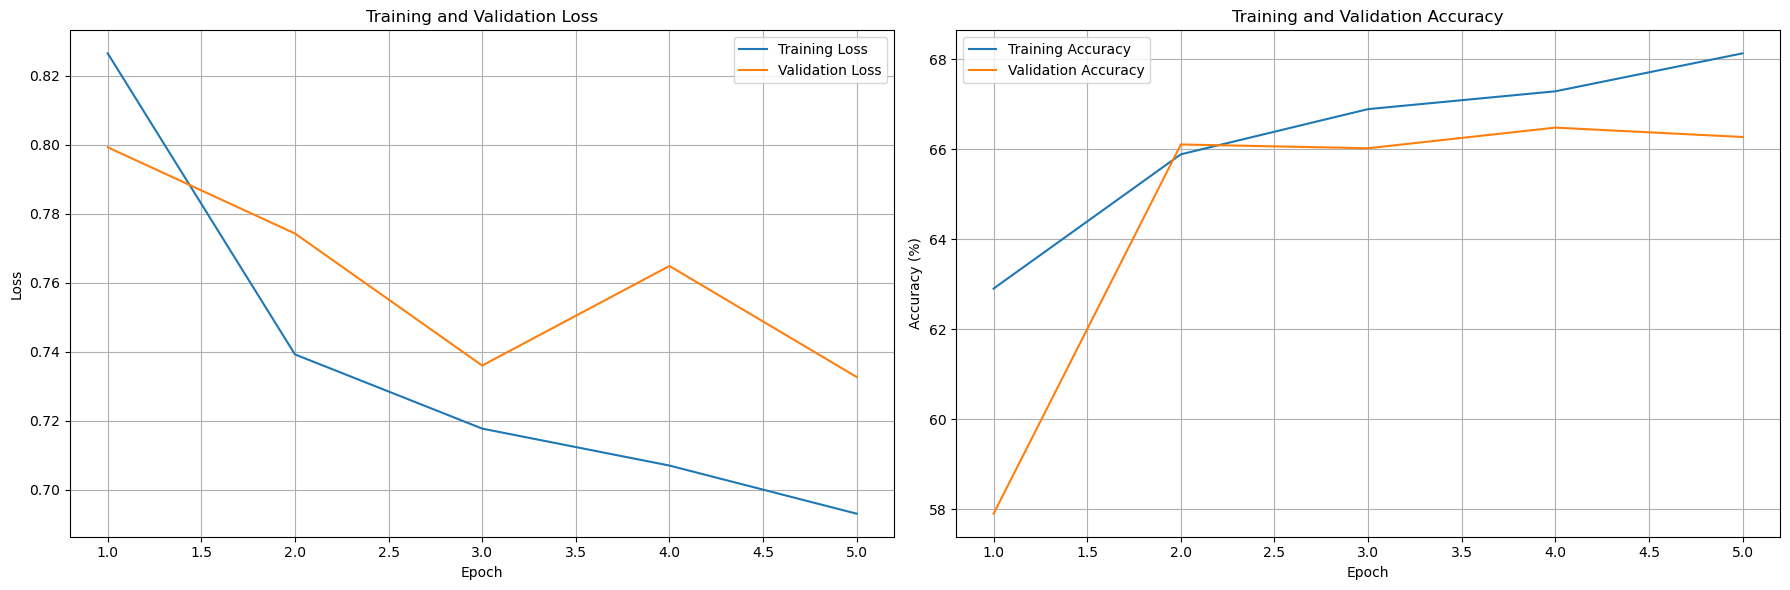

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
model_03_base, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_03,   
    test_dataset=test_data_03,    
    T=T_03,
    optimizer= optimizer,
    model = resNet_03,          
    mode='base',                 
    learning_rate=learning_rate,           
    batch_size=batch_size,               
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.91it/s]


Validation Loss: 0.7616, Accuracy: 66.12%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.49it/s]


Validation Loss: 0.7378, Accuracy: 58.88%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.14it/s]


Validation Loss: 0.7401, Accuracy: 67.35%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.33it/s]


Validation Loss: 0.7025, Accuracy: 67.94%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.60it/s]


Validation Loss: 0.7078, Accuracy: 67.21%


Testing: 100%|██████████| 63/63 [00:00<00:00, 63.10it/s]

Test Loss: 0.4826, Accuracy: 92.80%


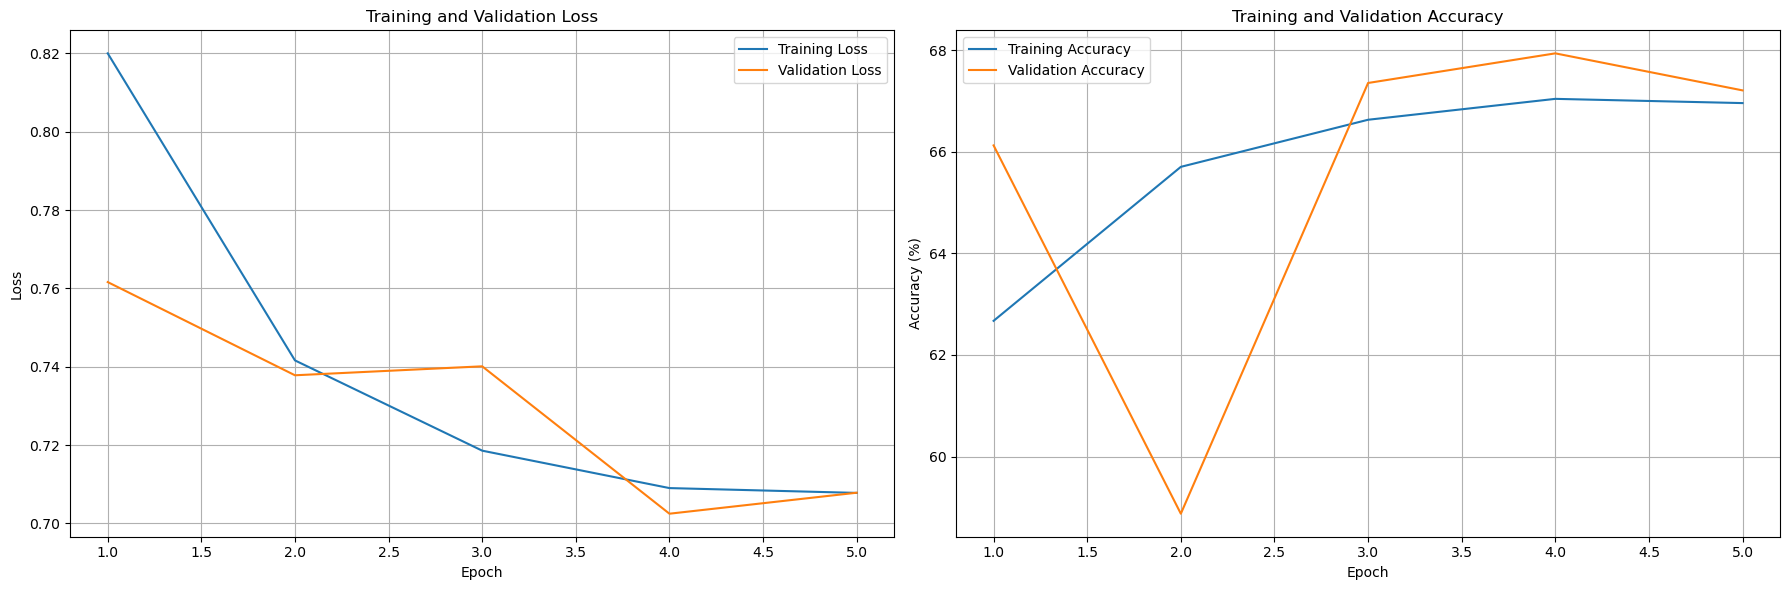

In [ ]:
# plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

### Training for 10 times

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': resNet_03,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 5
}


test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_03,
    test_dataset=test_data_03,
    T=T_03,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.28it/s]


Validation Loss: 0.2294, Accuracy: 63.65%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 19.95it/s]


Validation Loss: 0.1720, Accuracy: 67.29%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.44it/s]


Validation Loss: 0.1702, Accuracy: 67.06%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.68it/s]


Validation Loss: 0.1450, Accuracy: 67.25%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 19.74it/s]


Validation Loss: 0.1339, Accuracy: 66.85%


Testing: 100%|██████████| 63/63 [00:02<00:00, 21.72it/s]


Test Loss: 0.1426, Accuracy: 94.88%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.74it/s]


Validation Loss: 0.2245, Accuracy: 65.81%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.65it/s]


Validation Loss: 0.1651, Accuracy: 67.65%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.80it/s]


Validation Loss: 0.1502, Accuracy: 67.44%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.27it/s]


Validation Loss: 0.1607, Accuracy: 66.94%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.26it/s]


Validation Loss: 0.1603, Accuracy: 68.12%


Testing: 100%|██████████| 63/63 [00:03<00:00, 20.89it/s]


Test Loss: 0.1613, Accuracy: 94.33%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.34it/s]


Validation Loss: 0.2484, Accuracy: 65.42%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.70it/s]


Validation Loss: 0.2029, Accuracy: 66.73%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 19.82it/s]


Validation Loss: 0.1619, Accuracy: 66.67%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.34it/s]


Validation Loss: 0.1819, Accuracy: 66.79%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.60it/s]


Validation Loss: 0.1522, Accuracy: 67.02%


Testing: 100%|██████████| 63/63 [00:02<00:00, 21.75it/s]


Test Loss: 0.1567, Accuracy: 95.33%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.27it/s]


Validation Loss: 0.2127, Accuracy: 66.67%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.50it/s]


Validation Loss: 0.2231, Accuracy: 67.21%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.16it/s]


Validation Loss: 0.1693, Accuracy: 67.42%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.89it/s]


Validation Loss: 0.1419, Accuracy: 67.92%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.42it/s]


Validation Loss: 0.1242, Accuracy: 67.92%


Testing: 100%|██████████| 63/63 [00:03<00:00, 19.97it/s]


Test Loss: 0.1423, Accuracy: 95.40%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.60it/s]


Validation Loss: 0.2472, Accuracy: 66.29%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.01it/s]


Validation Loss: 0.1474, Accuracy: 67.02%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.72it/s]


Validation Loss: 0.1422, Accuracy: 66.98%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.53it/s]


Validation Loss: 0.1298, Accuracy: 67.52%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.05it/s]


Validation Loss: 0.1538, Accuracy: 66.31%


Testing: 100%|██████████| 63/63 [00:03<00:00, 19.98it/s]


Test Loss: 0.1540, Accuracy: 94.00%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.03it/s]


Validation Loss: 0.2226, Accuracy: 63.92%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.61it/s]


Validation Loss: 0.1985, Accuracy: 66.21%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.70it/s]


Validation Loss: 0.1858, Accuracy: 65.60%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.06it/s]


Validation Loss: 0.1785, Accuracy: 65.94%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.30it/s]


Validation Loss: 0.1626, Accuracy: 66.69%


Testing: 100%|██████████| 63/63 [00:03<00:00, 20.67it/s]


Test Loss: 0.1695, Accuracy: 94.25%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.54it/s]


Validation Loss: 0.1781, Accuracy: 67.92%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.79it/s]


Validation Loss: 0.1719, Accuracy: 68.33%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 23.39it/s]


Validation Loss: 0.1585, Accuracy: 68.02%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.62it/s]


Validation Loss: 0.1533, Accuracy: 68.19%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.97it/s]


Validation Loss: 0.1437, Accuracy: 68.06%


Testing: 100%|██████████| 63/63 [00:02<00:00, 22.69it/s]


Test Loss: 0.1605, Accuracy: 94.65%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.88it/s]


Validation Loss: 0.3353, Accuracy: 62.90%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.94it/s]


Validation Loss: 0.2084, Accuracy: 66.50%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.24it/s]


Validation Loss: 0.1887, Accuracy: 65.10%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.76it/s]


Validation Loss: 0.2055, Accuracy: 66.40%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.59it/s]


Validation Loss: 0.1799, Accuracy: 67.02%


Testing: 100%|██████████| 63/63 [00:02<00:00, 21.57it/s]


Test Loss: 0.1734, Accuracy: 93.97%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.02it/s]


Validation Loss: 0.2496, Accuracy: 65.35%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 23.29it/s]


Validation Loss: 0.1706, Accuracy: 65.65%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.90it/s]


Validation Loss: 0.1831, Accuracy: 66.54%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.67it/s]


Validation Loss: 0.2277, Accuracy: 65.40%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.19it/s]


Validation Loss: 0.1628, Accuracy: 66.75%


Testing: 100%|██████████| 63/63 [00:03<00:00, 20.39it/s]


Test Loss: 0.1539, Accuracy: 94.85%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.29it/s]


Validation Loss: 0.1958, Accuracy: 66.46%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.12it/s]


Validation Loss: 0.1678, Accuracy: 66.92%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 21.75it/s]


Validation Loss: 0.1764, Accuracy: 66.46%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 22.17it/s]


Validation Loss: 0.1564, Accuracy: 67.31%


Epoch 5 Validation: 100%|██████████| 75/75 [00:03<00:00, 20.35it/s]


Validation Loss: 0.1504, Accuracy: 67.25%


Testing: 100%|██████████| 63/63 [00:02<00:00, 22.82it/s]

Test Loss: 0.1644, Accuracy: 95.05%

Mean Test Accuracy: 94.67%
Standard Deviation of Test Accuracy: 0.49


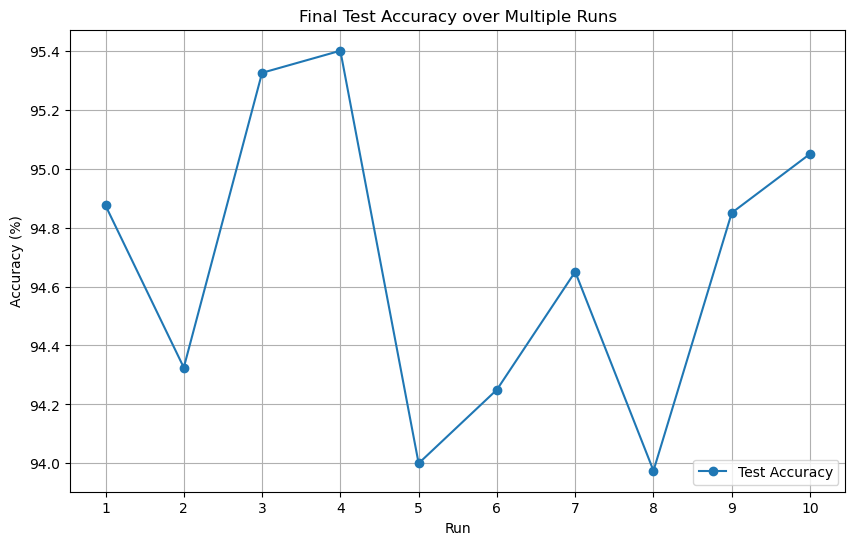

In [ ]:

plot_result(test_accuracies)

# FashionMINIST0.6

In [ ]:
T_06

tensor([[0.4000, 0.2000, 0.2000, 0.2000],
        [0.2000, 0.4000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.4000, 0.2000],
        [0.2000, 0.2000, 0.2000, 0.4000]], device='cuda:0')

## LeNet_06

In [ ]:
LeNet_06 = LeNet5(input_channels=3, num_classes=4).to(device)

### Hyperparameter Tuning

#### Tuning for optimizer

In [ ]:
num_epochs = 5
batch_size = 64

In [ ]:
optimizer = 'SGD'
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,
    mode='foward',
    learning_rate=0.01,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.95it/s]


Validation Loss: 1.3644, Accuracy: 32.12%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.67it/s]


Validation Loss: 1.3567, Accuracy: 36.00%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.85it/s]


Validation Loss: 1.3534, Accuracy: 37.25%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.22it/s]


Validation Loss: 1.3482, Accuracy: 37.69%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.17it/s]


Validation Loss: 1.3510, Accuracy: 37.69%


Testing: 100%|██████████| 63/63 [00:00<00:00, 73.97it/s]

Test Loss: 1.0380, Accuracy: 87.67%


In [ ]:
optimizer = 'Adam'
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,   
    test_dataset=test_data_06,     
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,          
    mode='foward',                 
    learning_rate=0.001,             
    batch_size=batch_size,               
    num_epochs=num_epochs                 
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.50it/s]


Validation Loss: 1.3440, Accuracy: 38.33%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.72it/s]


Validation Loss: 1.3450, Accuracy: 38.27%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.15it/s]


Validation Loss: 1.3424, Accuracy: 38.96%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.15it/s]


Validation Loss: 1.3410, Accuracy: 38.67%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.34it/s]


Validation Loss: 1.3426, Accuracy: 38.69%


Testing: 100%|██████████| 63/63 [00:00<00:00, 77.19it/s]

Test Loss: 0.9973, Accuracy: 91.90%


#### Tuning for learning rate

In [ ]:
num_epochs = 5
batch_size = 64
optimizer = 'Adam'

In [ ]:
learning_rate = 0.01
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,  
    test_dataset=test_data_06,    
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,           
    mode='foward',                  
    learning_rate=learning_rate,           
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.67it/s]


Validation Loss: 1.3866, Accuracy: 25.19%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.40it/s]


Validation Loss: 1.3881, Accuracy: 24.88%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.08it/s]


Validation Loss: 1.3865, Accuracy: 24.88%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.46it/s]


Validation Loss: 1.3864, Accuracy: 25.19%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.89it/s]


Validation Loss: 1.3873, Accuracy: 24.50%


Testing: 100%|██████████| 63/63 [00:00<00:00, 78.06it/s]

Test Loss: 1.3869, Accuracy: 25.00%


In [ ]:
learning_rate = 0.0001
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,   
    test_dataset=test_data_06,     
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,           
    mode='foward',                   
    learning_rate=learning_rate,            
    batch_size=batch_size,                 
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.87it/s]


Validation Loss: 1.3589, Accuracy: 35.48%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.99it/s]


Validation Loss: 1.3497, Accuracy: 37.23%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.71it/s]


Validation Loss: 1.3483, Accuracy: 37.48%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.23it/s]


Validation Loss: 1.3466, Accuracy: 37.67%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.28it/s]


Validation Loss: 1.3478, Accuracy: 37.88%


Testing: 100%|██████████| 63/63 [00:00<00:00, 78.01it/s]

Test Loss: 1.0564, Accuracy: 89.28%


#### Tuning for batch size

In [ ]:
num_epochs = 5
learning_rate = 0.001
optimizer = 'Adam'

In [ ]:
batch_size = 32
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,   
    test_dataset=test_data_06,    
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,          
    mode='foward',                  
    learning_rate=learning_rate,              
    batch_size=batch_size,                
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 150/150 [00:01<00:00, 135.69it/s]


Validation Loss: 1.3463, Accuracy: 38.12%


Epoch 2 Validation: 100%|██████████| 150/150 [00:01<00:00, 130.40it/s]


Validation Loss: 1.3411, Accuracy: 38.23%


Epoch 3 Validation: 100%|██████████| 150/150 [00:01<00:00, 132.62it/s]


Validation Loss: 1.3395, Accuracy: 38.69%


Epoch 4 Validation: 100%|██████████| 150/150 [00:01<00:00, 136.85it/s]


Validation Loss: 1.3421, Accuracy: 38.65%


Epoch 5 Validation: 100%|██████████| 150/150 [00:01<00:00, 130.15it/s]


Validation Loss: 1.3415, Accuracy: 38.56%


Testing: 100%|██████████| 125/125 [00:00<00:00, 131.96it/s]

Test Loss: 0.9586, Accuracy: 91.67%


In [ ]:
batch_size = 128
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,   
    test_dataset=test_data_06,     
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,           
    mode='foward',                  
    learning_rate=learning_rate,            
    batch_size=batch_size,                
    num_epochs=num_epochs                 
)

Epoch 1 Validation: 100%|██████████| 38/38 [00:00<00:00, 44.58it/s]


Validation Loss: 1.3431, Accuracy: 38.94%


Epoch 2 Validation: 100%|██████████| 38/38 [00:00<00:00, 44.52it/s]


Validation Loss: 1.3432, Accuracy: 38.58%


Epoch 3 Validation: 100%|██████████| 38/38 [00:00<00:00, 42.95it/s]


Validation Loss: 1.3419, Accuracy: 38.75%


Epoch 4 Validation: 100%|██████████| 38/38 [00:00<00:00, 43.91it/s]


Validation Loss: 1.3388, Accuracy: 39.12%


Epoch 5 Validation: 100%|██████████| 38/38 [00:00<00:00, 43.66it/s]


Validation Loss: 1.3408, Accuracy: 38.48%


Testing: 100%|██████████| 32/32 [00:00<00:00, 44.76it/s]

Test Loss: 1.0263, Accuracy: 89.85%


#### Tuning for nums of epochs

In [ ]:

learning_rate = 0.001
batch_size=64
optimizer = 'Adam'

In [ ]:
num_epochs = 15
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,  
    test_dataset=test_data_06,     
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,          
    mode='foward',                   
    learning_rate=learning_rate,             
    batch_size=batch_size,                
    num_epochs=num_epochs                 
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.82it/s]


Validation Loss: 1.3486, Accuracy: 37.38%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.54it/s]


Validation Loss: 1.3436, Accuracy: 38.56%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.33it/s]


Validation Loss: 1.3455, Accuracy: 37.92%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.10it/s]


Validation Loss: 1.3430, Accuracy: 38.58%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.88it/s]


Validation Loss: 1.3435, Accuracy: 38.44%


Epoch 6 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.33it/s]


Validation Loss: 1.3422, Accuracy: 38.52%


Epoch 7 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.59it/s]


Validation Loss: 1.3427, Accuracy: 38.62%


Epoch 8 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.52it/s]


Validation Loss: 1.3438, Accuracy: 38.56%


Epoch 9 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.06it/s]


Validation Loss: 1.3443, Accuracy: 38.52%


Epoch 10 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.26it/s]


Validation Loss: 1.3497, Accuracy: 38.12%


Epoch 11 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.90it/s]


Validation Loss: 1.3466, Accuracy: 38.29%


Epoch 12 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.62it/s]


Validation Loss: 1.3480, Accuracy: 38.25%


Epoch 13 Validation: 100%|██████████| 75/75 [00:01<00:00, 71.43it/s]


Validation Loss: 1.3488, Accuracy: 38.19%


Epoch 14 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.34it/s]


Validation Loss: 1.3512, Accuracy: 38.21%


Epoch 15 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.56it/s]


Validation Loss: 1.3522, Accuracy: 38.17%


Testing: 100%|██████████| 63/63 [00:00<00:00, 78.11it/s]

Test Loss: 0.9632, Accuracy: 90.60%


In [ ]:
num_epochs = 10
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = LeNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.17it/s]


Validation Loss: 1.3485, Accuracy: 37.77%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.66it/s]


Validation Loss: 1.3451, Accuracy: 38.04%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.59it/s]


Validation Loss: 1.3417, Accuracy: 38.52%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 72.69it/s]


Validation Loss: 1.3437, Accuracy: 38.25%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.51it/s]


Validation Loss: 1.3470, Accuracy: 37.83%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.83it/s]


Validation Loss: 1.3418, Accuracy: 38.44%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.42it/s]


Validation Loss: 1.3430, Accuracy: 38.06%


Epoch 8 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.47it/s]


Validation Loss: 1.3496, Accuracy: 37.52%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.76it/s]


Validation Loss: 1.3466, Accuracy: 38.02%


Epoch 10 Validation: 100%|██████████| 75/75 [00:00<00:00, 75.79it/s]


Validation Loss: 1.3480, Accuracy: 37.94%


Testing: 100%|██████████| 63/63 [00:00<00:00, 75.95it/s]

Test Loss: 0.9924, Accuracy: 90.12%


### Comparison Experiment

In [ ]:
learning_rate = 0.001
batch_size=64
optimizer = 'Adam'
num_epochs=5

In [ ]:
model_06_best, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_03,
    optimizer= optimizer,
    model = LeNet_06,
    mode='foward',                  
    learning_rate=learning_rate,            
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.42it/s]


Validation Loss: 1.3499, Accuracy: 36.96%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.57it/s]


Validation Loss: 1.3500, Accuracy: 37.52%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.83it/s]


Validation Loss: 1.3546, Accuracy: 36.67%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.91it/s]


Validation Loss: 1.3495, Accuracy: 37.85%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 73.43it/s]


Validation Loss: 1.3489, Accuracy: 37.79%


Testing: 100%|██████████| 63/63 [00:00<00:00, 75.67it/s]

Test Loss: 0.9837, Accuracy: 90.50%


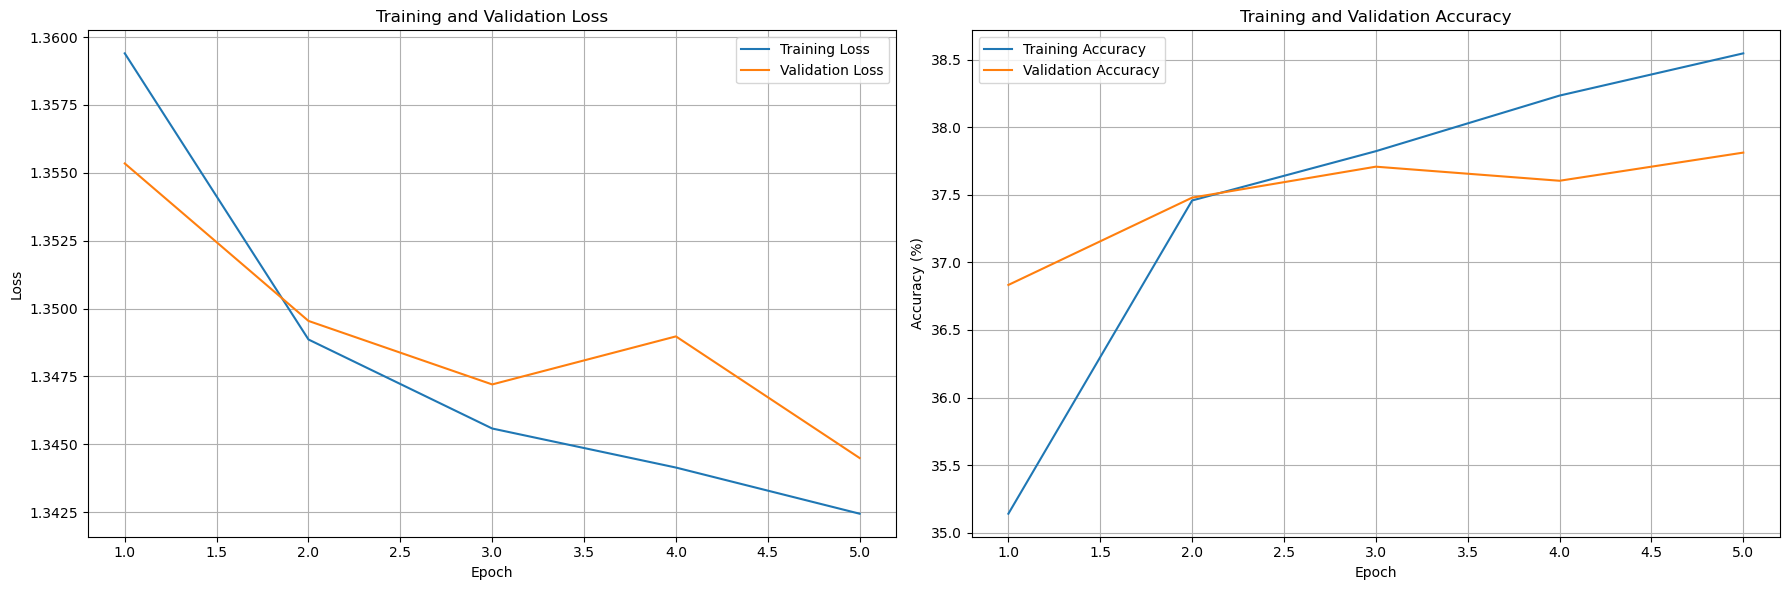

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:

model_06_best, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_03,
    optimizer= optimizer,
    model = LeNet_06,
    mode='base',                  
    learning_rate=learning_rate,            
    batch_size=batch_size,                 
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 74.49it/s]


Validation Loss: 1.3480, Accuracy: 37.77%


Epoch 2 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.60it/s]


Validation Loss: 1.3468, Accuracy: 37.35%


Epoch 3 Validation: 100%|██████████| 75/75 [00:00<00:00, 77.75it/s]


Validation Loss: 1.3445, Accuracy: 37.98%


Epoch 4 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.48it/s]


Validation Loss: 1.3435, Accuracy: 38.12%


Epoch 5 Validation: 100%|██████████| 75/75 [00:00<00:00, 76.41it/s]


Validation Loss: 1.3474, Accuracy: 37.83%


Testing: 100%|██████████| 63/63 [00:00<00:00, 73.82it/s]

Test Loss: 1.0088, Accuracy: 89.78%


### Training for 10 times

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': LeNet_06,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 5
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.06it/s]


Validation Loss: 0.3286, Accuracy: 37.94%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.03it/s]


Validation Loss: 0.2650, Accuracy: 38.65%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.73it/s]


Validation Loss: 0.3340, Accuracy: 38.56%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.15it/s]


Validation Loss: 0.2187, Accuracy: 38.58%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.34it/s]


Validation Loss: 0.2978, Accuracy: 38.77%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.10it/s]


Test Loss: 0.2825, Accuracy: 91.67%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.99it/s]


Validation Loss: 0.5152, Accuracy: 37.75%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.37it/s]


Validation Loss: 0.2928, Accuracy: 37.67%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.89it/s]


Validation Loss: 0.2747, Accuracy: 38.35%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.39it/s]


Validation Loss: 0.3659, Accuracy: 38.35%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.16it/s]


Validation Loss: 0.2495, Accuracy: 38.42%


Testing: 100%|██████████| 63/63 [00:01<00:00, 33.83it/s]


Test Loss: 0.2364, Accuracy: 90.47%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.14it/s]


Validation Loss: 0.5153, Accuracy: 37.06%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.09it/s]


Validation Loss: 0.2744, Accuracy: 37.42%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.65it/s]


Validation Loss: 0.2230, Accuracy: 38.08%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.64it/s]


Validation Loss: 0.1988, Accuracy: 38.31%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.02it/s]


Validation Loss: 0.1809, Accuracy: 38.44%


Testing: 100%|██████████| 63/63 [00:01<00:00, 36.04it/s]


Test Loss: 0.1834, Accuracy: 90.95%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.93it/s]


Validation Loss: 0.6073, Accuracy: 35.71%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.72it/s]


Validation Loss: 0.2890, Accuracy: 37.35%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.38it/s]


Validation Loss: 0.2864, Accuracy: 37.40%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.75it/s]


Validation Loss: 0.2375, Accuracy: 37.62%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.41it/s]


Validation Loss: 0.3593, Accuracy: 37.38%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.19it/s]


Test Loss: 0.3111, Accuracy: 90.67%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.51it/s]


Validation Loss: 0.6231, Accuracy: 38.40%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.16it/s]


Validation Loss: 0.3617, Accuracy: 38.85%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.24it/s]


Validation Loss: 0.4028, Accuracy: 38.85%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.61it/s]


Validation Loss: 0.2841, Accuracy: 39.06%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.13it/s]


Validation Loss: 0.1919, Accuracy: 38.88%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.91it/s]


Test Loss: 0.1998, Accuracy: 90.60%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.31it/s]


Validation Loss: 0.4499, Accuracy: 36.98%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.23it/s]


Validation Loss: 0.4535, Accuracy: 38.12%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.83it/s]


Validation Loss: 0.3208, Accuracy: 38.06%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.76it/s]


Validation Loss: 0.2318, Accuracy: 38.02%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.24it/s]


Validation Loss: 0.2050, Accuracy: 38.31%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.71it/s]


Test Loss: 0.1906, Accuracy: 90.78%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.86it/s]


Validation Loss: 0.4477, Accuracy: 36.19%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.27it/s]


Validation Loss: 0.4064, Accuracy: 37.75%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.50it/s]


Validation Loss: 0.2013, Accuracy: 37.54%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.66it/s]


Validation Loss: 0.3813, Accuracy: 37.42%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.13it/s]


Validation Loss: 0.2791, Accuracy: 37.92%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.70it/s]


Test Loss: 0.2604, Accuracy: 90.15%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.62it/s]


Validation Loss: 0.3555, Accuracy: 38.25%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.45it/s]


Validation Loss: 0.3168, Accuracy: 38.33%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.91it/s]


Validation Loss: 0.3767, Accuracy: 38.60%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.88it/s]


Validation Loss: 0.2722, Accuracy: 38.73%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.55it/s]


Validation Loss: 0.2809, Accuracy: 38.77%


Testing: 100%|██████████| 63/63 [00:01<00:00, 36.13it/s]


Test Loss: 0.2585, Accuracy: 90.53%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.60it/s]


Validation Loss: 0.3386, Accuracy: 37.21%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.25it/s]


Validation Loss: 0.3433, Accuracy: 37.33%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.13it/s]


Validation Loss: 0.2549, Accuracy: 37.27%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.13it/s]


Validation Loss: 0.3820, Accuracy: 36.94%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.10it/s]


Validation Loss: 0.2022, Accuracy: 37.08%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.08it/s]


Test Loss: 0.2199, Accuracy: 88.67%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.24it/s]


Validation Loss: 0.3946, Accuracy: 38.06%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.52it/s]


Validation Loss: 0.4669, Accuracy: 39.15%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.78it/s]


Validation Loss: 0.3684, Accuracy: 38.75%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.86it/s]


Validation Loss: 0.2701, Accuracy: 39.02%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.85it/s]


Validation Loss: 0.2368, Accuracy: 39.08%


Testing: 100%|██████████| 63/63 [00:02<00:00, 29.74it/s]

Test Loss: 0.2241, Accuracy: 91.83%

Mean Test Accuracy: 90.63%
Standard Deviation of Test Accuracy: 0.82


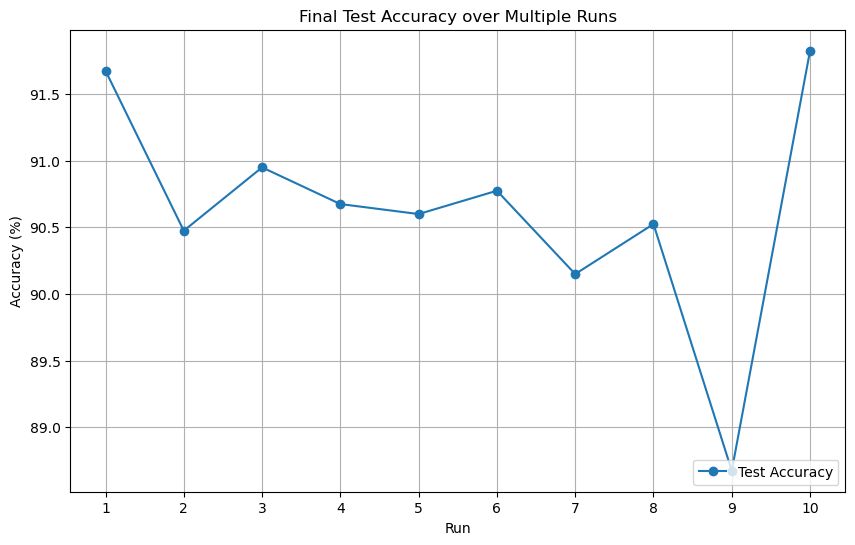

In [ ]:
plot_result(test_accuracies)

## ResNet_06

In [ ]:
resNet_06 = ResNet18(num_classes=4).to(device)

### Hyperparameter Tuning

#### Tuning for optimizer

In [ ]:
num_epochs = 5
batch_size = 64

In [ ]:
optimizer = 'SGD'
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,  
    test_dataset=test_data_06,    
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,          
    mode='foward',                  
    learning_rate=0.01,              
    batch_size=batch_size,                 
    num_epochs=num_epochs                  
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.89it/s]


Validation Loss: 1.4015, Accuracy: 27.40%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.86it/s]


Validation Loss: 1.3862, Accuracy: 32.83%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.17it/s]


Validation Loss: 1.3685, Accuracy: 34.02%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.93it/s]


Validation Loss: 1.4384, Accuracy: 32.92%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 68.37it/s]


Validation Loss: 1.3898, Accuracy: 35.48%


Testing: 100%|██████████| 63/63 [00:00<00:00, 64.49it/s]

Test Loss: 1.1117, Accuracy: 74.45%


In [ ]:
optimizer = 'Adam'
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,   
    test_dataset=test_data_06,     
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,           
    mode='foward',                   
    learning_rate=0.01,              
    batch_size=batch_size,                 
    num_epochs=num_epochs                   
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.72it/s]


Validation Loss: 1.4859, Accuracy: 32.85%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 61.85it/s]


Validation Loss: 1.3840, Accuracy: 31.42%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.57it/s]


Validation Loss: 1.3651, Accuracy: 35.67%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.28it/s]


Validation Loss: 1.3519, Accuracy: 38.15%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.69it/s]


Validation Loss: 1.3546, Accuracy: 37.92%


Testing: 100%|██████████| 63/63 [00:00<00:00, 66.33it/s]

Test Loss: 1.0940, Accuracy: 84.58%


#### Tuning for learning rate

In [ ]:
num_epochs = 5
batch_size = 64
optimizer = 'Adam'

In [ ]:
learning_rate = 0.001
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 61.56it/s]


Validation Loss: 1.3746, Accuracy: 34.54%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.53it/s]


Validation Loss: 1.3763, Accuracy: 35.02%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.18it/s]


Validation Loss: 1.4037, Accuracy: 35.58%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.56it/s]


Validation Loss: 1.4081, Accuracy: 36.73%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.36it/s]


Validation Loss: 1.3574, Accuracy: 37.15%


Testing: 100%|██████████| 63/63 [00:00<00:00, 64.78it/s]

Test Loss: 1.0393, Accuracy: 84.75%


In [ ]:
learning_rate = 0.0001
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)


Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.21it/s]


Validation Loss: 1.4286, Accuracy: 36.04%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.84it/s]


Validation Loss: 1.3990, Accuracy: 34.29%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.88it/s]


Validation Loss: 1.3839, Accuracy: 33.96%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.56it/s]


Validation Loss: 1.3796, Accuracy: 34.29%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 60.39it/s]


Validation Loss: 1.4213, Accuracy: 32.77%


Testing: 100%|██████████| 63/63 [00:01<00:00, 61.06it/s]

Test Loss: 1.0739, Accuracy: 64.55%


#### Tuning for batch size

In [ ]:
optimizer = 'Adam'
learning_rate =  0.001
num_epochs = 5

In [ ]:
batch_size = 32
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 150/150 [00:01<00:00, 95.09it/s]


Validation Loss: 1.4089, Accuracy: 34.25%


Epoch 2 Validation: 100%|██████████| 150/150 [00:01<00:00, 94.21it/s]


Validation Loss: 1.5667, Accuracy: 29.27%


Epoch 3 Validation: 100%|██████████| 150/150 [00:01<00:00, 98.15it/s] 


Validation Loss: 1.4540, Accuracy: 32.71%


Epoch 4 Validation: 100%|██████████| 150/150 [00:01<00:00, 95.60it/s]


Validation Loss: 1.3695, Accuracy: 35.38%


Epoch 5 Validation: 100%|██████████| 150/150 [00:01<00:00, 98.56it/s]


Validation Loss: 1.3836, Accuracy: 32.60%


Testing: 100%|██████████| 125/125 [00:01<00:00, 90.52it/s]

Test Loss: 1.1110, Accuracy: 65.45%


In [ ]:
batch_size = 128
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 38/38 [00:00<00:00, 38.52it/s]


Validation Loss: 1.3731, Accuracy: 36.62%


Epoch 2 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.82it/s]


Validation Loss: 1.3824, Accuracy: 34.00%


Epoch 3 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.06it/s]


Validation Loss: 1.3845, Accuracy: 34.94%


Epoch 4 Validation: 100%|██████████| 38/38 [00:00<00:00, 40.42it/s]


Validation Loss: 1.3592, Accuracy: 37.31%


Epoch 5 Validation: 100%|██████████| 38/38 [00:00<00:00, 39.55it/s]


Validation Loss: 1.3698, Accuracy: 32.54%


Testing: 100%|██████████| 32/32 [00:00<00:00, 40.05it/s]

Test Loss: 1.1563, Accuracy: 63.02%


#### Tuning for nums of epochs

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64

In [ ]:
num_epochs = 10
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.81it/s]


Validation Loss: 1.3538, Accuracy: 37.10%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 61.86it/s]


Validation Loss: 1.3770, Accuracy: 32.62%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 53.34it/s]


Validation Loss: 1.3600, Accuracy: 37.85%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.63it/s]


Validation Loss: 1.3516, Accuracy: 37.88%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.29it/s]


Validation Loss: 1.3618, Accuracy: 36.94%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.82it/s]


Validation Loss: 1.3713, Accuracy: 36.75%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 59.24it/s]


Validation Loss: 1.3691, Accuracy: 36.81%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.04it/s]


Validation Loss: 1.3864, Accuracy: 36.83%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.17it/s]


Validation Loss: 1.3780, Accuracy: 37.40%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 58.70it/s]


Validation Loss: 1.3546, Accuracy: 38.12%


Testing: 100%|██████████| 63/63 [00:01<00:00, 53.70it/s]

Test Loss: 1.0503, Accuracy: 88.92%


In [ ]:
num_epochs = 15
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.08it/s]


Validation Loss: 1.3856, Accuracy: 33.56%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.19it/s]


Validation Loss: 1.3462, Accuracy: 38.90%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.37it/s]


Validation Loss: 1.3553, Accuracy: 38.33%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 61.23it/s]


Validation Loss: 1.3519, Accuracy: 38.48%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.39it/s]


Validation Loss: 1.3592, Accuracy: 37.65%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.39it/s]


Validation Loss: 1.4074, Accuracy: 37.10%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.61it/s]


Validation Loss: 1.3704, Accuracy: 33.00%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.58it/s]


Validation Loss: 1.3637, Accuracy: 39.15%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 59.34it/s]


Validation Loss: 1.3896, Accuracy: 37.92%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 56.75it/s]


Validation Loss: 1.3444, Accuracy: 38.44%


Epoch 11 Validation: 100%|██████████| 75/75 [00:01<00:00, 60.05it/s]


Validation Loss: 1.3363, Accuracy: 38.98%


Epoch 12 Validation: 100%|██████████| 75/75 [00:01<00:00, 59.17it/s]


Validation Loss: 1.3364, Accuracy: 38.98%


Epoch 13 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.55it/s]


Validation Loss: 1.3359, Accuracy: 39.00%


Epoch 14 Validation: 100%|██████████| 75/75 [00:01<00:00, 59.28it/s]


Validation Loss: 1.3358, Accuracy: 39.33%


Epoch 15 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.38it/s]


Validation Loss: 1.3372, Accuracy: 39.25%


Testing: 100%|██████████| 63/63 [00:00<00:00, 66.20it/s]

Test Loss: 0.9778, Accuracy: 90.65%


### Comparison Experiment

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64
num_epochs = 15

In [ ]:
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 68.76it/s]


Validation Loss: 1.4282, Accuracy: 34.29%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.56it/s]


Validation Loss: 1.3694, Accuracy: 36.96%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.16it/s]


Validation Loss: 1.4605, Accuracy: 34.15%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.39it/s]


Validation Loss: 1.3904, Accuracy: 35.52%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.42it/s]


Validation Loss: 1.3724, Accuracy: 37.71%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.50it/s]


Validation Loss: 1.4463, Accuracy: 37.04%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.61it/s]


Validation Loss: 1.3842, Accuracy: 36.58%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 61.98it/s]


Validation Loss: 1.3592, Accuracy: 36.42%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.64it/s]


Validation Loss: 1.3525, Accuracy: 37.69%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.56it/s]


Validation Loss: 1.3614, Accuracy: 37.77%


Epoch 11 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.89it/s]


Validation Loss: 1.3530, Accuracy: 37.92%


Epoch 12 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.46it/s]


Validation Loss: 1.3509, Accuracy: 38.00%


Epoch 13 Validation: 100%|██████████| 75/75 [00:01<00:00, 65.91it/s]


Validation Loss: 1.3640, Accuracy: 37.00%


Epoch 14 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.76it/s]


Validation Loss: 1.3556, Accuracy: 37.50%


Epoch 15 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.58it/s]


Validation Loss: 1.3732, Accuracy: 36.67%


Testing: 100%|██████████| 63/63 [00:00<00:00, 65.23it/s]

Test Loss: 1.0042, Accuracy: 86.00%


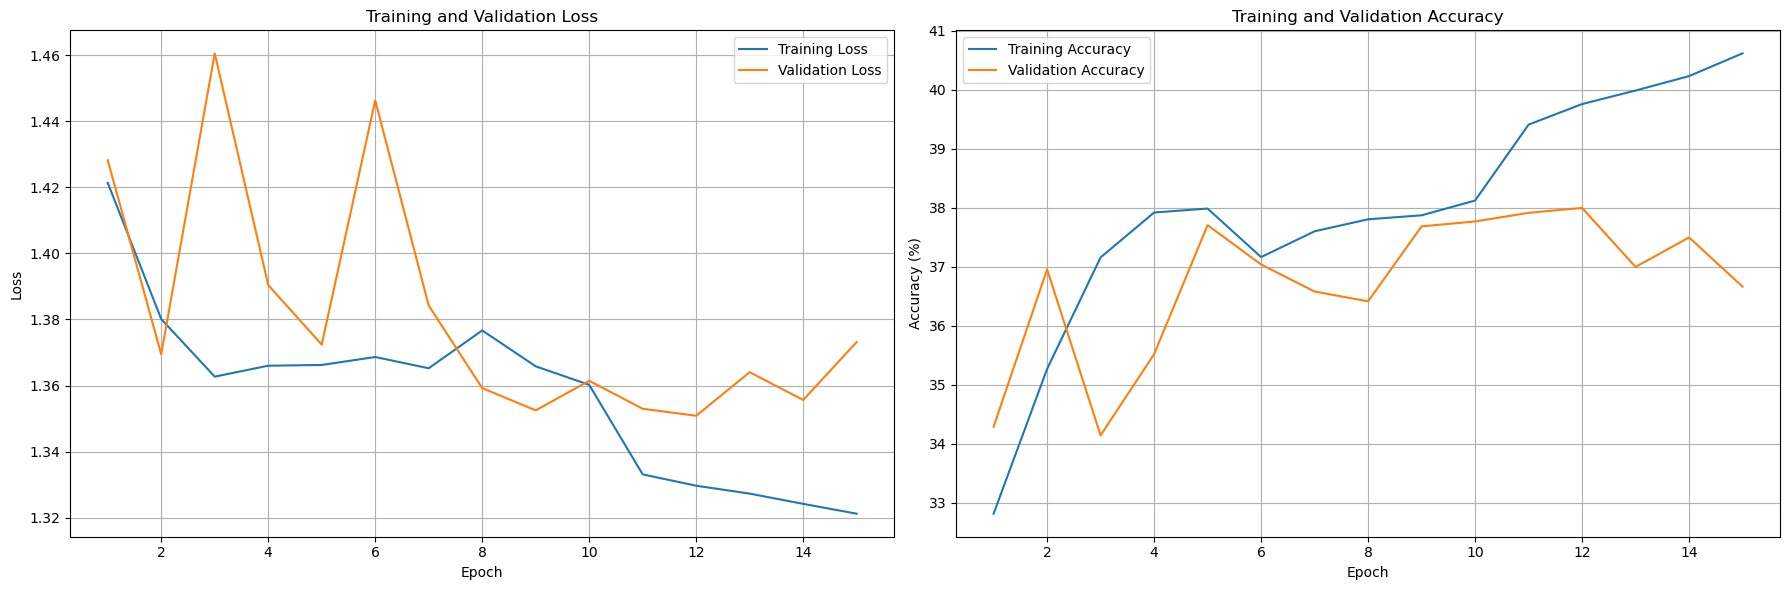

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
model_06, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    optimizer= optimizer,
    model = resNet_06,
    mode='base',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.27it/s]


Validation Loss: 1.3634, Accuracy: 34.52%


Epoch 2 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.27it/s]


Validation Loss: 1.3737, Accuracy: 35.98%


Epoch 3 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.81it/s]


Validation Loss: 1.3897, Accuracy: 36.08%


Epoch 4 Validation: 100%|██████████| 75/75 [00:01<00:00, 67.85it/s]


Validation Loss: 1.3918, Accuracy: 35.67%


Epoch 5 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.02it/s]


Validation Loss: 1.3831, Accuracy: 36.96%


Epoch 6 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.29it/s]


Validation Loss: 1.4235, Accuracy: 37.40%


Epoch 7 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.37it/s]


Validation Loss: 1.3606, Accuracy: 37.48%


Epoch 8 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.59it/s]


Validation Loss: 1.3804, Accuracy: 37.79%


Epoch 9 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.55it/s]


Validation Loss: 1.3632, Accuracy: 38.60%


Epoch 10 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.69it/s]


Validation Loss: 1.3627, Accuracy: 36.77%


Epoch 11 Validation: 100%|██████████| 75/75 [00:01<00:00, 64.87it/s]


Validation Loss: 1.3470, Accuracy: 38.69%


Epoch 12 Validation: 100%|██████████| 75/75 [00:01<00:00, 66.08it/s]


Validation Loss: 1.3486, Accuracy: 37.94%


Epoch 13 Validation: 100%|██████████| 75/75 [00:01<00:00, 62.29it/s]


Validation Loss: 1.3564, Accuracy: 37.96%


Epoch 14 Validation: 100%|██████████| 75/75 [00:01<00:00, 63.48it/s]


Validation Loss: 1.3670, Accuracy: 37.10%


Epoch 15 Validation: 100%|██████████| 75/75 [00:01<00:00, 58.20it/s]


Validation Loss: 1.3672, Accuracy: 36.56%


Testing: 100%|██████████| 63/63 [00:01<00:00, 61.99it/s]

Test Loss: 0.9854, Accuracy: 81.90%


### Training for 10 times

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': resNet_06,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 15
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_06,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.48it/s]


Validation Loss: 0.1582, Accuracy: 33.85%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.41it/s]


Validation Loss: 0.1453, Accuracy: 37.04%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.83it/s]


Validation Loss: 0.1864, Accuracy: 37.79%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.69it/s]


Validation Loss: 0.1819, Accuracy: 37.44%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.54it/s]


Validation Loss: 0.1459, Accuracy: 37.83%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.32it/s]


Validation Loss: 0.1795, Accuracy: 36.98%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.16it/s]


Validation Loss: 0.1454, Accuracy: 37.81%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.00it/s]


Validation Loss: 0.1587, Accuracy: 37.50%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.29it/s]


Validation Loss: 0.1519, Accuracy: 37.94%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.91it/s]


Validation Loss: 0.1337, Accuracy: 37.44%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.47it/s]


Validation Loss: 0.1308, Accuracy: 37.62%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.04it/s]


Validation Loss: 0.1420, Accuracy: 37.65%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.46it/s]


Validation Loss: 0.1281, Accuracy: 37.81%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.10it/s]


Validation Loss: 0.1328, Accuracy: 37.73%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.14it/s]


Validation Loss: 0.1177, Accuracy: 37.67%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.92it/s]


Test Loss: 0.1215, Accuracy: 90.10%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.42it/s]


Validation Loss: 0.3369, Accuracy: 35.31%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.03it/s]


Validation Loss: 0.2033, Accuracy: 37.33%


Epoch 3 Validation: 100%|██████████| 75/75 [00:03<00:00, 23.46it/s]


Validation Loss: 0.2979, Accuracy: 36.40%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.39it/s]


Validation Loss: 0.2414, Accuracy: 37.17%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.34it/s]


Validation Loss: 0.1383, Accuracy: 37.33%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.42it/s]


Validation Loss: 0.2435, Accuracy: 37.50%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.77it/s]


Validation Loss: 0.1859, Accuracy: 36.71%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.08it/s]


Validation Loss: 0.1885, Accuracy: 37.15%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.05it/s]


Validation Loss: 0.1706, Accuracy: 37.08%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.35it/s]


Validation Loss: 0.1561, Accuracy: 37.81%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.00it/s]


Validation Loss: 0.1390, Accuracy: 37.58%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.28it/s]


Validation Loss: 0.1320, Accuracy: 37.29%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.62it/s]


Validation Loss: 0.1474, Accuracy: 37.31%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.81it/s]


Validation Loss: 0.1457, Accuracy: 37.12%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.88it/s]


Validation Loss: 0.1364, Accuracy: 37.17%


Testing: 100%|██████████| 63/63 [00:02<00:00, 28.47it/s]


Test Loss: 0.1295, Accuracy: 90.53%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.34it/s]


Validation Loss: 0.1791, Accuracy: 37.21%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.39it/s]


Validation Loss: 0.1156, Accuracy: 37.85%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.17it/s]


Validation Loss: 0.2096, Accuracy: 38.06%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.28it/s]


Validation Loss: 0.1696, Accuracy: 38.08%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.70it/s]


Validation Loss: 0.1520, Accuracy: 38.44%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.37it/s]


Validation Loss: 0.2834, Accuracy: 37.92%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.18it/s]


Validation Loss: 0.2736, Accuracy: 37.54%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 0.1451, Accuracy: 37.44%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.46it/s]


Validation Loss: 0.1519, Accuracy: 37.98%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.40it/s]


Validation Loss: 0.1530, Accuracy: 37.94%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.29it/s]


Validation Loss: 0.1314, Accuracy: 38.27%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.83it/s]


Validation Loss: 0.1181, Accuracy: 38.50%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.85it/s]


Validation Loss: 0.1157, Accuracy: 38.48%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.76it/s]


Validation Loss: 0.1240, Accuracy: 38.33%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.85it/s]


Validation Loss: 0.1076, Accuracy: 38.35%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.73it/s]


Test Loss: 0.1133, Accuracy: 90.85%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.71it/s]


Validation Loss: 0.3180, Accuracy: 35.17%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.51it/s]


Validation Loss: 0.5222, Accuracy: 38.58%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.82it/s]


Validation Loss: 0.3549, Accuracy: 38.06%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.65it/s]


Validation Loss: 0.3858, Accuracy: 38.58%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.30it/s]


Validation Loss: 0.3124, Accuracy: 39.23%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.37it/s]


Validation Loss: 0.2154, Accuracy: 39.00%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.65it/s]


Validation Loss: 0.1639, Accuracy: 39.17%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.36it/s]


Validation Loss: 0.1519, Accuracy: 38.92%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.41it/s]


Validation Loss: 0.1458, Accuracy: 39.06%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.95it/s]


Validation Loss: 0.1685, Accuracy: 39.58%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.04it/s]


Validation Loss: 0.1825, Accuracy: 39.71%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.47it/s]


Validation Loss: 0.1837, Accuracy: 39.67%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.31it/s]


Validation Loss: 0.1673, Accuracy: 39.81%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.58it/s]


Validation Loss: 0.1909, Accuracy: 38.69%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.13it/s]


Validation Loss: 0.1468, Accuracy: 39.25%


Testing: 100%|██████████| 63/63 [00:02<00:00, 25.95it/s]


Test Loss: 0.1527, Accuracy: 89.85%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.91it/s]


Validation Loss: 0.3984, Accuracy: 37.25%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.95it/s]


Validation Loss: 0.3978, Accuracy: 37.40%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.45it/s]


Validation Loss: 0.2591, Accuracy: 37.69%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.12it/s]


Validation Loss: 0.2596, Accuracy: 37.88%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.13it/s]


Validation Loss: 0.2108, Accuracy: 38.27%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.82it/s]


Validation Loss: 0.3993, Accuracy: 38.06%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.10it/s]


Validation Loss: 0.2484, Accuracy: 37.56%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.77it/s]


Validation Loss: 0.2464, Accuracy: 38.48%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.29it/s]


Validation Loss: 0.2481, Accuracy: 37.31%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.74it/s]


Validation Loss: 0.2019, Accuracy: 38.29%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.97it/s]


Validation Loss: 0.1792, Accuracy: 38.17%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.94it/s]


Validation Loss: 0.1566, Accuracy: 38.25%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.87it/s]


Validation Loss: 0.1673, Accuracy: 38.02%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.42it/s]


Validation Loss: 0.1489, Accuracy: 38.00%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.02it/s]


Validation Loss: 0.1481, Accuracy: 37.79%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.99it/s]


Test Loss: 0.1349, Accuracy: 91.35%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.58it/s]


Validation Loss: 0.2789, Accuracy: 36.33%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.66it/s]


Validation Loss: 0.2056, Accuracy: 36.23%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.96it/s]


Validation Loss: 0.1889, Accuracy: 36.52%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.96it/s]


Validation Loss: 0.2830, Accuracy: 36.96%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.45it/s]


Validation Loss: 0.1620, Accuracy: 37.62%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.63it/s]


Validation Loss: 0.1847, Accuracy: 36.92%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.91it/s]


Validation Loss: 0.1284, Accuracy: 37.15%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.83it/s]


Validation Loss: 0.1665, Accuracy: 37.40%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.78it/s]


Validation Loss: 0.1624, Accuracy: 37.15%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.58it/s]


Validation Loss: 0.2371, Accuracy: 37.54%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 0.1491, Accuracy: 38.29%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 0.1463, Accuracy: 38.29%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 0.1402, Accuracy: 38.08%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.08it/s]


Validation Loss: 0.1167, Accuracy: 38.00%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.38it/s]


Validation Loss: 0.1287, Accuracy: 37.62%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.53it/s]


Test Loss: 0.1407, Accuracy: 91.15%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.55it/s]


Validation Loss: 0.2371, Accuracy: 37.58%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.77it/s]


Validation Loss: 0.1457, Accuracy: 38.21%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.89it/s]


Validation Loss: 0.2549, Accuracy: 36.77%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.00it/s]


Validation Loss: 0.2034, Accuracy: 38.62%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.43it/s]


Validation Loss: 0.1919, Accuracy: 37.67%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.92it/s]


Validation Loss: 0.2274, Accuracy: 38.17%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.73it/s]


Validation Loss: 0.1170, Accuracy: 38.25%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.80it/s]


Validation Loss: 0.1886, Accuracy: 37.98%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 0.1396, Accuracy: 38.65%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.45it/s]


Validation Loss: 0.1372, Accuracy: 38.69%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.37it/s]


Validation Loss: 0.1287, Accuracy: 38.54%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.10it/s]


Validation Loss: 0.1287, Accuracy: 38.71%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.91it/s]


Validation Loss: 0.1320, Accuracy: 38.62%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.55it/s]


Validation Loss: 0.1277, Accuracy: 38.77%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.92it/s]


Validation Loss: 0.1207, Accuracy: 38.48%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.18it/s]


Test Loss: 0.1080, Accuracy: 91.28%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.84it/s]


Validation Loss: 0.1680, Accuracy: 36.19%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.21it/s]


Validation Loss: 0.2750, Accuracy: 35.75%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.12it/s]


Validation Loss: 0.2539, Accuracy: 37.85%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.64it/s]


Validation Loss: 0.2849, Accuracy: 36.56%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.74it/s]


Validation Loss: 0.2218, Accuracy: 37.71%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.86it/s]


Validation Loss: 0.2833, Accuracy: 37.35%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.38it/s]


Validation Loss: 0.1435, Accuracy: 38.02%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.90it/s]


Validation Loss: 0.2021, Accuracy: 38.73%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.21it/s]


Validation Loss: 0.1599, Accuracy: 38.10%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.19it/s]


Validation Loss: 0.1695, Accuracy: 37.98%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.58it/s]


Validation Loss: 0.1885, Accuracy: 38.56%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.92it/s]


Validation Loss: 0.1667, Accuracy: 38.65%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.17it/s]


Validation Loss: 0.1606, Accuracy: 38.69%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.86it/s]


Validation Loss: 0.1496, Accuracy: 38.73%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.39it/s]


Validation Loss: 0.1452, Accuracy: 38.67%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.43it/s]


Test Loss: 0.1320, Accuracy: 91.70%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.36it/s]


Validation Loss: 0.0855, Accuracy: 35.94%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.04it/s]


Validation Loss: 0.1737, Accuracy: 36.71%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.45it/s]


Validation Loss: 0.2320, Accuracy: 33.38%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 0.2057, Accuracy: 37.40%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.77it/s]


Validation Loss: 0.2443, Accuracy: 36.52%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.37it/s]


Validation Loss: 0.2114, Accuracy: 37.54%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.79it/s]


Validation Loss: 0.1828, Accuracy: 37.33%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.75it/s]


Validation Loss: 0.1945, Accuracy: 36.90%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.58it/s]


Validation Loss: 0.2410, Accuracy: 37.56%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.22it/s]


Validation Loss: 0.1240, Accuracy: 37.27%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.20it/s]


Validation Loss: 0.1452, Accuracy: 37.96%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.17it/s]


Validation Loss: 0.1555, Accuracy: 38.15%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.63it/s]


Validation Loss: 0.1470, Accuracy: 38.35%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.19it/s]


Validation Loss: 0.1400, Accuracy: 38.04%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.66it/s]


Validation Loss: 0.1514, Accuracy: 37.58%


Testing: 100%|██████████| 63/63 [00:02<00:00, 28.14it/s]


Test Loss: 0.1584, Accuracy: 89.42%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.58it/s]


Validation Loss: 0.2427, Accuracy: 34.83%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.59it/s]


Validation Loss: 0.1748, Accuracy: 36.62%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.96it/s]


Validation Loss: 0.1431, Accuracy: 37.58%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.57it/s]


Validation Loss: 0.2308, Accuracy: 36.08%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.62it/s]


Validation Loss: 0.1329, Accuracy: 36.90%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.16it/s]


Validation Loss: 0.1336, Accuracy: 37.27%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.00it/s]


Validation Loss: 0.1568, Accuracy: 37.31%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.19it/s]


Validation Loss: 0.2185, Accuracy: 37.10%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.00it/s]


Validation Loss: 0.1230, Accuracy: 37.21%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.17it/s]


Validation Loss: 0.1276, Accuracy: 37.48%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.37it/s]


Validation Loss: 0.1169, Accuracy: 37.62%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.77it/s]


Validation Loss: 0.0988, Accuracy: 37.92%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.78it/s]


Validation Loss: 0.1000, Accuracy: 37.77%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.44it/s]


Validation Loss: 0.0771, Accuracy: 37.88%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.77it/s]


Validation Loss: 0.0760, Accuracy: 37.77%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.25it/s]

Test Loss: 0.0844, Accuracy: 92.35%

Mean Test Accuracy: 90.86%
Standard Deviation of Test Accuracy: 0.85


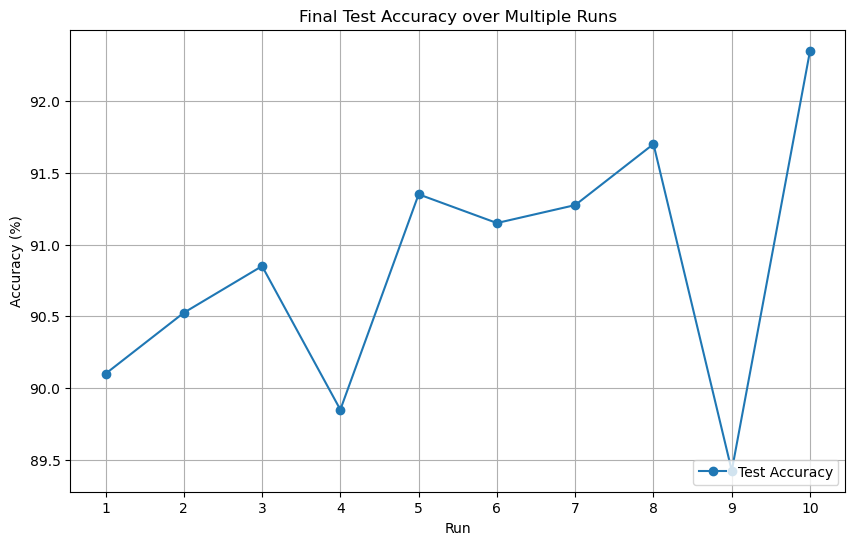

In [ ]:
plot_result(test_accuracies)

# Estimating T for FashionMINIST

## FashionMINIST0.3 with Lenet

In [ ]:
T_es = estimating(train_data_03,
                               model = LeNet_03,
                               num_classes=4,
                               n_epoch_estimate=15,
                               batch_size=64,
                               lr=0.001,
                               )

Estimating Transition Matrix...


Estimating Transition Matrix: 100%|██████████| 1125/1125 [00:50<00:00, 22.49it/s, Loss=0.05]   


Estimated Transition Matrix:
[[7.53105179e-01 2.09194664e-01 2.03775479e-03 3.56624022e-02]
 [2.33073087e-04 6.63819099e-01 3.35812283e-01 1.35544925e-04]
 [1.00623107e-02 6.82392241e-03 7.42947747e-01 2.40166020e-01]
 [3.43452319e-01 7.16652751e-03 2.16492554e-03 6.47216228e-01]]


In [ ]:
T_es_03 = torch.from_numpy(T_es).float().to(device)

In [ ]:
T_03

tensor([[0.7000, 0.3000, 0.0000, 0.0000],
        [0.0000, 0.7000, 0.3000, 0.0000],
        [0.0000, 0.0000, 0.7000, 0.3000],
        [0.3000, 0.0000, 0.0000, 0.7000]], device='cuda:0')

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': LeNet_03,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 15
}

# 多次训练和可视化
test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_03,
    test_dataset=test_data_03,
    T=T_es_03,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.75it/s]


Validation Loss: 0.4160, Accuracy: 65.46%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.30it/s]


Validation Loss: 0.3391, Accuracy: 65.77%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.70it/s]


Validation Loss: 0.3148, Accuracy: 66.00%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.27it/s]


Validation Loss: 0.3196, Accuracy: 66.23%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.86it/s]


Validation Loss: 0.3302, Accuracy: 66.31%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.38it/s]


Validation Loss: 0.3354, Accuracy: 66.38%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.52it/s]


Validation Loss: 0.2519, Accuracy: 66.19%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.04it/s]


Validation Loss: 0.2706, Accuracy: 66.50%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.19it/s]


Validation Loss: 0.3250, Accuracy: 66.56%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.03it/s]


Validation Loss: 0.2817, Accuracy: 66.56%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.82it/s]


Validation Loss: 0.2829, Accuracy: 66.71%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.78it/s]


Validation Loss: 0.2901, Accuracy: 66.67%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.65it/s]


Validation Loss: 0.2947, Accuracy: 66.67%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.23it/s]


Validation Loss: 0.2848, Accuracy: 66.73%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.07it/s]


Validation Loss: 0.2819, Accuracy: 66.69%


Testing: 100%|██████████| 63/63 [00:01<00:00, 31.70it/s]


Test Loss: 0.1725, Accuracy: 94.95%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.40it/s]


Validation Loss: 0.3291, Accuracy: 65.73%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 36.13it/s]


Validation Loss: 0.3209, Accuracy: 66.25%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.11it/s]


Validation Loss: 0.3838, Accuracy: 66.52%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.57it/s]


Validation Loss: 0.2812, Accuracy: 67.08%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.29it/s]


Validation Loss: 0.3184, Accuracy: 66.96%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.78it/s]


Validation Loss: 0.2674, Accuracy: 67.10%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.82it/s]


Validation Loss: 0.3335, Accuracy: 66.50%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.87it/s]


Validation Loss: 0.2599, Accuracy: 67.06%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.74it/s]


Validation Loss: 0.2948, Accuracy: 67.12%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.83it/s]


Validation Loss: 0.3096, Accuracy: 66.92%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.99it/s]


Validation Loss: 0.2878, Accuracy: 67.35%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.56it/s]


Validation Loss: 0.3029, Accuracy: 67.44%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.11it/s]


Validation Loss: 0.2901, Accuracy: 67.29%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.78it/s]


Validation Loss: 0.2860, Accuracy: 67.23%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.17it/s]


Validation Loss: 0.2899, Accuracy: 67.35%


Testing: 100%|██████████| 63/63 [00:02<00:00, 31.03it/s]


Test Loss: 0.1920, Accuracy: 95.00%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.44it/s]


Validation Loss: 0.3945, Accuracy: 65.48%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.24it/s]


Validation Loss: 0.2958, Accuracy: 66.19%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.73it/s]


Validation Loss: 0.3655, Accuracy: 66.02%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.40it/s]


Validation Loss: 0.2952, Accuracy: 66.35%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.18it/s]


Validation Loss: 0.2884, Accuracy: 65.90%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.03it/s]


Validation Loss: 0.2913, Accuracy: 66.65%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.98it/s]


Validation Loss: 0.2889, Accuracy: 66.50%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.30it/s]


Validation Loss: 0.3012, Accuracy: 66.98%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.93it/s]


Validation Loss: 0.3591, Accuracy: 66.71%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.15it/s]


Validation Loss: 0.3077, Accuracy: 66.85%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.90it/s]


Validation Loss: 0.2866, Accuracy: 66.81%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.18it/s]


Validation Loss: 0.2898, Accuracy: 66.77%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.20it/s]


Validation Loss: 0.2759, Accuracy: 66.81%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.60it/s]


Validation Loss: 0.2785, Accuracy: 66.85%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.21it/s]


Validation Loss: 0.2941, Accuracy: 66.73%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.57it/s]


Test Loss: 0.1840, Accuracy: 95.35%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.51it/s]


Validation Loss: 0.3530, Accuracy: 66.46%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.60it/s]


Validation Loss: 0.3499, Accuracy: 67.29%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.07it/s]


Validation Loss: 0.3102, Accuracy: 66.56%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.94it/s]


Validation Loss: 0.2996, Accuracy: 67.06%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.88it/s]


Validation Loss: 0.2815, Accuracy: 67.58%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.26it/s]


Validation Loss: 0.3294, Accuracy: 67.31%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.30it/s]


Validation Loss: 0.3076, Accuracy: 67.69%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.97it/s]


Validation Loss: 0.2454, Accuracy: 67.58%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.75it/s]


Validation Loss: 0.3192, Accuracy: 67.50%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.95it/s]


Validation Loss: 0.2923, Accuracy: 68.06%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.34it/s]


Validation Loss: 0.3092, Accuracy: 68.10%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.48it/s]


Validation Loss: 0.2938, Accuracy: 68.02%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.50it/s]


Validation Loss: 0.3057, Accuracy: 67.83%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.17it/s]


Validation Loss: 0.3159, Accuracy: 67.69%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.72it/s]


Validation Loss: 0.2993, Accuracy: 67.52%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.56it/s]


Test Loss: 0.1872, Accuracy: 95.15%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.69it/s]


Validation Loss: 0.3380, Accuracy: 65.77%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.03it/s]


Validation Loss: 0.3406, Accuracy: 66.81%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.48it/s]


Validation Loss: 0.2968, Accuracy: 67.23%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.76it/s]


Validation Loss: 0.3900, Accuracy: 67.19%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.93it/s]


Validation Loss: 0.3042, Accuracy: 68.19%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.39it/s]


Validation Loss: 0.2356, Accuracy: 67.62%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.00it/s]


Validation Loss: 0.2328, Accuracy: 67.35%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.88it/s]


Validation Loss: 0.2860, Accuracy: 67.46%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.88it/s]


Validation Loss: 0.2757, Accuracy: 68.25%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.88it/s]


Validation Loss: 0.2839, Accuracy: 67.88%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.39it/s]


Validation Loss: 0.2853, Accuracy: 68.21%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.61it/s]


Validation Loss: 0.2942, Accuracy: 68.06%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.56it/s]


Validation Loss: 0.2878, Accuracy: 67.98%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.29it/s]


Validation Loss: 0.2789, Accuracy: 67.96%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.48it/s]


Validation Loss: 0.2928, Accuracy: 67.83%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.35it/s]


Test Loss: 0.1917, Accuracy: 94.85%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.55it/s]


Validation Loss: 0.3642, Accuracy: 65.54%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.35it/s]


Validation Loss: 0.3214, Accuracy: 65.42%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.35it/s]


Validation Loss: 0.3231, Accuracy: 66.25%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.44it/s]


Validation Loss: 0.3506, Accuracy: 66.60%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.30it/s]


Validation Loss: 0.3095, Accuracy: 67.02%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.93it/s]


Validation Loss: 0.2864, Accuracy: 66.60%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.58it/s]


Validation Loss: 0.2530, Accuracy: 66.25%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.74it/s]


Validation Loss: 0.3052, Accuracy: 66.96%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.20it/s]


Validation Loss: 0.3055, Accuracy: 66.79%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.33it/s]


Validation Loss: 0.2718, Accuracy: 66.65%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.01it/s]


Validation Loss: 0.2764, Accuracy: 66.98%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.56it/s]


Validation Loss: 0.2842, Accuracy: 67.17%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.69it/s]


Validation Loss: 0.2888, Accuracy: 66.85%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.24it/s]


Validation Loss: 0.2810, Accuracy: 66.96%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.81it/s]


Validation Loss: 0.2936, Accuracy: 67.04%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.78it/s]


Test Loss: 0.1935, Accuracy: 95.00%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.66it/s]


Validation Loss: 0.3420, Accuracy: 65.33%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.26it/s]


Validation Loss: 0.3388, Accuracy: 66.10%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.89it/s]


Validation Loss: 0.3306, Accuracy: 66.00%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.37it/s]


Validation Loss: 0.3017, Accuracy: 66.58%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.68it/s]


Validation Loss: 0.2741, Accuracy: 66.73%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.42it/s]


Validation Loss: 0.2810, Accuracy: 66.69%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.71it/s]


Validation Loss: 0.3339, Accuracy: 66.56%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.29it/s]


Validation Loss: 0.3373, Accuracy: 66.50%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.52it/s]


Validation Loss: 0.2752, Accuracy: 66.42%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.01it/s]


Validation Loss: 0.2708, Accuracy: 66.75%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.31it/s]


Validation Loss: 0.2811, Accuracy: 66.81%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.59it/s]


Validation Loss: 0.2783, Accuracy: 66.94%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.17it/s]


Validation Loss: 0.2656, Accuracy: 66.92%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.16it/s]


Validation Loss: 0.2741, Accuracy: 66.77%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.75it/s]


Validation Loss: 0.2702, Accuracy: 66.92%


Testing: 100%|██████████| 63/63 [00:01<00:00, 35.95it/s]


Test Loss: 0.1817, Accuracy: 95.12%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.65it/s]


Validation Loss: 0.3747, Accuracy: 66.31%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.67it/s]


Validation Loss: 0.3399, Accuracy: 66.23%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.96it/s]


Validation Loss: 0.2637, Accuracy: 66.35%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.30it/s]


Validation Loss: 0.3018, Accuracy: 67.33%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.57it/s]


Validation Loss: 0.2749, Accuracy: 67.12%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.56it/s]


Validation Loss: 0.2420, Accuracy: 67.46%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.48it/s]


Validation Loss: 0.3130, Accuracy: 67.02%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.79it/s]


Validation Loss: 0.2748, Accuracy: 67.77%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.08it/s]


Validation Loss: 0.2666, Accuracy: 67.75%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.89it/s]


Validation Loss: 0.2784, Accuracy: 67.56%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.62it/s]


Validation Loss: 0.2789, Accuracy: 67.65%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.97it/s]


Validation Loss: 0.2810, Accuracy: 67.79%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.04it/s]


Validation Loss: 0.2703, Accuracy: 67.71%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.99it/s]


Validation Loss: 0.2723, Accuracy: 67.65%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.80it/s]


Validation Loss: 0.2800, Accuracy: 67.56%


Testing: 100%|██████████| 63/63 [00:01<00:00, 36.09it/s]


Test Loss: 0.1787, Accuracy: 95.00%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.30it/s]


Validation Loss: 0.3421, Accuracy: 66.33%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.96it/s]


Validation Loss: 0.3455, Accuracy: 65.62%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.36it/s]


Validation Loss: 0.3285, Accuracy: 66.40%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.57it/s]


Validation Loss: 0.3094, Accuracy: 66.08%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.83it/s]


Validation Loss: 0.3257, Accuracy: 66.90%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.47it/s]


Validation Loss: 0.2526, Accuracy: 66.98%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 32.73it/s]


Validation Loss: 0.2338, Accuracy: 66.96%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.30it/s]


Validation Loss: 0.2569, Accuracy: 67.10%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.45it/s]


Validation Loss: 0.2983, Accuracy: 67.12%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.08it/s]


Validation Loss: 0.2919, Accuracy: 67.31%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.29it/s]


Validation Loss: 0.2753, Accuracy: 67.08%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.54it/s]


Validation Loss: 0.2725, Accuracy: 67.08%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.22it/s]


Validation Loss: 0.2942, Accuracy: 67.12%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.00it/s]


Validation Loss: 0.2761, Accuracy: 67.06%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.13it/s]


Validation Loss: 0.2678, Accuracy: 66.98%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.59it/s]


Test Loss: 0.1672, Accuracy: 95.03%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.11it/s]


Validation Loss: 0.3488, Accuracy: 66.23%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.48it/s]


Validation Loss: 0.3611, Accuracy: 66.58%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.70it/s]


Validation Loss: 0.2859, Accuracy: 66.33%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.49it/s]


Validation Loss: 0.3303, Accuracy: 66.69%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.68it/s]


Validation Loss: 0.2817, Accuracy: 67.12%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.95it/s]


Validation Loss: 0.2282, Accuracy: 66.90%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.99it/s]


Validation Loss: 0.3040, Accuracy: 66.69%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.40it/s]


Validation Loss: 0.3540, Accuracy: 67.04%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.98it/s]


Validation Loss: 0.2841, Accuracy: 67.00%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.01it/s]


Validation Loss: 0.2994, Accuracy: 66.73%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.89it/s]


Validation Loss: 0.3002, Accuracy: 66.98%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 35.02it/s]


Validation Loss: 0.3132, Accuracy: 67.02%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.66it/s]


Validation Loss: 0.2980, Accuracy: 66.96%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 34.20it/s]


Validation Loss: 0.3006, Accuracy: 66.92%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 33.63it/s]


Validation Loss: 0.2905, Accuracy: 66.94%


Testing: 100%|██████████| 63/63 [00:01<00:00, 34.60it/s]

Test Loss: 0.1796, Accuracy: 94.85%

Mean Test Accuracy: 95.03%
Standard Deviation of Test Accuracy: 0.14


## FashionMINIST0.3 with ResNet

In [ ]:
T_es_R3 = estimating(train_data_03,
                               model = resNet_03,
                               num_classes=4,
                               n_epoch_estimate=5,
                               batch_size=64,
                               lr=0.001,
                               )

Estimating Transition Matrix...


Estimating Transition Matrix: 100%|██████████| 375/375 [00:21<00:00, 17.43it/s, Loss=0.105]  


Estimated Transition Matrix:
[[8.38375599e-01 1.61049957e-01 4.64826981e-04 1.09617289e-04]
 [1.94398638e-04 7.74730307e-01 2.24628533e-01 4.46761570e-04]
 [4.38636519e-03 2.78646322e-03 8.91124203e-01 1.01702968e-01]
 [2.59567157e-02 4.71023223e-04 2.95868990e-05 9.73542674e-01]]


In [ ]:
T_es_03RES = torch.from_numpy(T_es_R3).float().to(device)

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': resNet_03,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 5
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_03,
    test_dataset=test_data_03,
    T=T_es_03RES,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.19it/s]


Validation Loss: 0.4499, Accuracy: 65.35%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.96it/s]


Validation Loss: 0.5290, Accuracy: 66.88%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.73it/s]


Validation Loss: 0.5006, Accuracy: 66.94%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.39it/s]


Validation Loss: 0.5259, Accuracy: 67.48%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.23it/s]


Validation Loss: 0.5165, Accuracy: 66.90%


Testing: 100%|██████████| 63/63 [00:02<00:00, 25.84it/s]


Test Loss: 0.3057, Accuracy: 94.72%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.99it/s]


Validation Loss: 0.5792, Accuracy: 64.52%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.73it/s]


Validation Loss: 0.5164, Accuracy: 66.79%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.88it/s]


Validation Loss: 0.4852, Accuracy: 67.23%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.57it/s]


Validation Loss: 0.5342, Accuracy: 66.12%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.13it/s]


Validation Loss: 0.4794, Accuracy: 67.38%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.15it/s]


Test Loss: 0.3123, Accuracy: 95.38%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.60it/s]


Validation Loss: 0.5490, Accuracy: 66.81%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.76it/s]


Validation Loss: 0.5371, Accuracy: 66.65%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.03it/s]


Validation Loss: 0.5380, Accuracy: 65.31%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.25it/s]


Validation Loss: 0.5396, Accuracy: 66.60%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.55it/s]


Validation Loss: 0.5275, Accuracy: 67.40%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.60it/s]


Test Loss: 0.3388, Accuracy: 94.97%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.31it/s]


Validation Loss: 0.5271, Accuracy: 66.73%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.96it/s]


Validation Loss: 0.5038, Accuracy: 67.10%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.37it/s]


Validation Loss: 0.4774, Accuracy: 67.25%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 24.78it/s]


Validation Loss: 0.4992, Accuracy: 67.08%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.68it/s]


Validation Loss: 0.4987, Accuracy: 66.54%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.66it/s]


Test Loss: 0.3273, Accuracy: 93.88%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.55it/s]


Validation Loss: 0.5346, Accuracy: 67.00%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.31it/s]


Validation Loss: 0.4959, Accuracy: 67.31%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.54it/s]


Validation Loss: 0.5149, Accuracy: 67.60%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.85it/s]


Validation Loss: 0.4741, Accuracy: 67.17%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.75it/s]


Validation Loss: 0.4953, Accuracy: 67.90%


Testing: 100%|██████████| 63/63 [00:02<00:00, 25.55it/s]


Test Loss: 0.3167, Accuracy: 95.12%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.96it/s]


Validation Loss: 0.4704, Accuracy: 66.92%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.50it/s]


Validation Loss: 0.5053, Accuracy: 64.79%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.48it/s]


Validation Loss: 0.4942, Accuracy: 68.10%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.72it/s]


Validation Loss: 0.4574, Accuracy: 68.19%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.36it/s]


Validation Loss: 0.4844, Accuracy: 67.46%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.86it/s]


Test Loss: 0.3188, Accuracy: 94.08%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.51it/s]


Validation Loss: 0.5036, Accuracy: 67.92%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.85it/s]


Validation Loss: 0.4914, Accuracy: 67.77%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.37it/s]


Validation Loss: 0.4798, Accuracy: 68.65%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.63it/s]


Validation Loss: 0.4976, Accuracy: 68.38%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.24it/s]


Validation Loss: 0.4812, Accuracy: 68.67%


Testing: 100%|██████████| 63/63 [00:02<00:00, 24.68it/s]


Test Loss: 0.3041, Accuracy: 94.85%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.56it/s]


Validation Loss: 0.5132, Accuracy: 67.42%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.11it/s]


Validation Loss: 0.5140, Accuracy: 67.65%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.77it/s]


Validation Loss: 0.5254, Accuracy: 68.04%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 24.61it/s]


Validation Loss: 0.4605, Accuracy: 67.58%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.77it/s]


Validation Loss: 0.4940, Accuracy: 68.04%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.88it/s]


Test Loss: 0.3413, Accuracy: 94.42%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.08it/s]


Validation Loss: 0.5445, Accuracy: 66.29%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.73it/s]


Validation Loss: 0.5010, Accuracy: 66.19%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.20it/s]


Validation Loss: 0.5531, Accuracy: 66.23%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.82it/s]


Validation Loss: 0.4965, Accuracy: 65.40%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.48it/s]


Validation Loss: 0.5321, Accuracy: 66.79%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.08it/s]


Test Loss: 0.3700, Accuracy: 95.20%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.73it/s]


Validation Loss: 0.5522, Accuracy: 67.83%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.20it/s]


Validation Loss: 0.5155, Accuracy: 68.21%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.61it/s]


Validation Loss: 0.4801, Accuracy: 68.35%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.13it/s]


Validation Loss: 0.4636, Accuracy: 68.19%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.96it/s]


Validation Loss: 0.5065, Accuracy: 68.42%


Testing: 100%|██████████| 63/63 [00:02<00:00, 25.53it/s]

Test Loss: 0.3136, Accuracy: 94.95%

Mean Test Accuracy: 94.76%
Standard Deviation of Test Accuracy: 0.46


## FashionMINIST0.6 with LeNet

In [ ]:
T_es_06L = estimating(train_data_06,
                               model = LeNet_06,
                               num_classes=4,
                               n_epoch_estimate=8,
                               batch_size=128,
                               lr=0.001,
                               )

Estimating Transition Matrix...


Estimating Transition Matrix: 100%|██████████████████████████████████████| 304/304 [00:16<00:00, 18.25it/s, Loss=0.167]


Estimated Transition Matrix:
[[0.44887977 0.15679256 0.1897802  0.20454747]
 [0.22160741 0.41430054 0.17465689 0.18943517]
 [0.22087129 0.19078401 0.38260282 0.20574187]
 [0.21808888 0.15406125 0.21171238 0.41613749]]


In [ ]:
T_es_06LE = torch.from_numpy(T_es_06L).float().to(device)

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': LeNet_06,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 5
}

# 多次训练和可视化
test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_es_06LE,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 35.74it/s]


Validation Loss: 0.5635, Accuracy: 37.94%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 43.10it/s]


Validation Loss: 0.3875, Accuracy: 37.83%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 37.82it/s]


Validation Loss: 0.4087, Accuracy: 38.17%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 37.43it/s]


Validation Loss: 0.4080, Accuracy: 37.92%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.20it/s]


Validation Loss: 0.5303, Accuracy: 38.12%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 38.21it/s]


Test Loss: 0.4702, Accuracy: 90.12%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.65it/s]


Validation Loss: 0.5314, Accuracy: 36.98%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.67it/s]


Validation Loss: 0.5218, Accuracy: 36.83%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.11it/s]


Validation Loss: 0.2101, Accuracy: 37.19%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.35it/s]


Validation Loss: 0.4778, Accuracy: 37.06%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.37it/s]


Validation Loss: 0.4910, Accuracy: 37.21%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 39.71it/s]


Test Loss: 0.4232, Accuracy: 90.40%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.10it/s]


Validation Loss: 0.4148, Accuracy: 36.96%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.07it/s]


Validation Loss: 0.4767, Accuracy: 36.23%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.50it/s]


Validation Loss: 0.4218, Accuracy: 36.79%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 36.54it/s]


Validation Loss: 0.3261, Accuracy: 36.65%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.45it/s]


Validation Loss: 0.3240, Accuracy: 36.94%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 36.93it/s]


Test Loss: 0.2663, Accuracy: 91.33%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 42.58it/s]


Validation Loss: 0.5649, Accuracy: 38.38%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 37.19it/s]


Validation Loss: 0.4743, Accuracy: 38.50%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 37.56it/s]


Validation Loss: 0.5317, Accuracy: 38.48%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 37.50it/s]


Validation Loss: 0.3601, Accuracy: 38.15%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.35it/s]


Validation Loss: 0.4022, Accuracy: 38.40%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 39.77it/s]


Test Loss: 0.3338, Accuracy: 91.10%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 37.95it/s]


Validation Loss: 0.6861, Accuracy: 37.75%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.83it/s]


Validation Loss: 0.4784, Accuracy: 38.17%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 42.23it/s]


Validation Loss: 0.4548, Accuracy: 38.62%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.24it/s]


Validation Loss: 0.3945, Accuracy: 38.52%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.28it/s]


Validation Loss: 0.4478, Accuracy: 38.25%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 40.34it/s]


Test Loss: 0.3662, Accuracy: 92.30%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.86it/s]


Validation Loss: 0.5290, Accuracy: 38.73%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 37.81it/s]


Validation Loss: 0.6450, Accuracy: 38.94%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.88it/s]


Validation Loss: 0.4411, Accuracy: 38.88%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.62it/s]


Validation Loss: 0.3966, Accuracy: 39.08%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.14it/s]


Validation Loss: 0.3765, Accuracy: 39.08%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 38.52it/s]


Test Loss: 0.3265, Accuracy: 90.30%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.89it/s]


Validation Loss: 0.5902, Accuracy: 36.21%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.74it/s]


Validation Loss: 0.4749, Accuracy: 37.21%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.30it/s]


Validation Loss: 0.3532, Accuracy: 36.88%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.33it/s]


Validation Loss: 0.3293, Accuracy: 36.96%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.96it/s]


Validation Loss: 0.2788, Accuracy: 36.67%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 40.76it/s]


Test Loss: 0.2328, Accuracy: 90.42%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.42it/s]


Validation Loss: 0.5064, Accuracy: 37.85%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.45it/s]


Validation Loss: 0.6054, Accuracy: 38.08%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.10it/s]


Validation Loss: 0.4985, Accuracy: 38.25%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.26it/s]


Validation Loss: 0.3978, Accuracy: 37.79%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.42it/s]


Validation Loss: 0.4890, Accuracy: 37.90%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 36.85it/s]


Test Loss: 0.4172, Accuracy: 89.95%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.17it/s]


Validation Loss: 0.5357, Accuracy: 37.67%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.49it/s]


Validation Loss: 0.5528, Accuracy: 37.62%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.30it/s]


Validation Loss: 0.4758, Accuracy: 37.60%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.87it/s]


Validation Loss: 0.3047, Accuracy: 37.29%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 37.26it/s]


Validation Loss: 0.4919, Accuracy: 37.71%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 37.97it/s]


Test Loss: 0.4227, Accuracy: 91.95%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.05it/s]


Validation Loss: 0.7512, Accuracy: 37.19%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.38it/s]


Validation Loss: 0.4072, Accuracy: 37.65%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 36.09it/s]


Validation Loss: 0.5307, Accuracy: 37.65%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.55it/s]


Validation Loss: 0.4583, Accuracy: 38.08%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 38.54it/s]


Validation Loss: 0.3274, Accuracy: 37.67%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.52it/s]


Test Loss: 0.2835, Accuracy: 88.85%

Mean Test Accuracy: 90.67%
Standard Deviation of Test Accuracy: 0.96


## FashionMINIST0.6 with ResNet

In [ ]:
T_es_06R = estimating(train_data_06,
                               model = resNet_06,
                               num_classes=4,
                               n_epoch_estimate=15,
                               batch_size=64,
                               lr=0.001,
                               )

Estimating Transition Matrix...


Estimating Transition Matrix: 100%|██████████| 1125/1125 [01:05<00:00, 17.28it/s, Loss=0.00944] 


Estimated Transition Matrix:
[[9.99810158e-01 1.15036397e-04 5.56557169e-05 1.91500348e-05]
 [3.41617518e-06 9.99875397e-01 1.81283210e-05 1.03058914e-04]
 [7.09591202e-05 3.09953837e-06 9.99925653e-01 2.88827016e-07]
 [6.96933115e-06 2.54745634e-06 3.46373911e-05 9.99955846e-01]]


In [ ]:
T_06

tensor([[0.4000, 0.2000, 0.2000, 0.2000],
        [0.2000, 0.4000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.4000, 0.2000],
        [0.2000, 0.2000, 0.2000, 0.4000]], device='cuda:0')

In [ ]:
T_es_06RES = torch.from_numpy(T_es_06R).float().to(device)

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': resNet_06,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 15
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_06,
    test_dataset=test_data_06,
    T=T_es_06RES,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.73it/s]


Validation Loss: 1.3449, Accuracy: 38.06%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.70it/s]


Validation Loss: 1.3554, Accuracy: 37.06%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 25.77it/s]


Validation Loss: 1.3504, Accuracy: 36.44%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.96it/s]


Validation Loss: 1.3733, Accuracy: 34.21%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.73it/s]


Validation Loss: 1.3638, Accuracy: 36.94%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.97it/s]


Validation Loss: 1.3663, Accuracy: 35.81%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.08it/s]


Validation Loss: 1.3466, Accuracy: 37.52%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.89it/s]


Validation Loss: 1.3267, Accuracy: 38.71%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.75it/s]


Validation Loss: 1.3311, Accuracy: 38.75%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.09it/s]


Validation Loss: 1.4071, Accuracy: 33.77%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.75it/s]


Validation Loss: 1.3419, Accuracy: 38.38%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.53it/s]


Validation Loss: 1.3379, Accuracy: 38.67%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.70it/s]


Validation Loss: 1.3383, Accuracy: 38.54%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.29it/s]


Validation Loss: 1.3498, Accuracy: 37.23%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.29it/s]


Validation Loss: 1.3409, Accuracy: 38.31%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.17it/s]


Test Loss: 0.9773, Accuracy: 89.78%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.58it/s]


Validation Loss: 1.3659, Accuracy: 35.46%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.75it/s]


Validation Loss: 1.3679, Accuracy: 34.90%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.74it/s]


Validation Loss: 1.3583, Accuracy: 36.90%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.73it/s]


Validation Loss: 1.3733, Accuracy: 35.69%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.49it/s]


Validation Loss: 1.3604, Accuracy: 35.56%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.17it/s]


Validation Loss: 1.3500, Accuracy: 37.29%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.36it/s]


Validation Loss: 1.3531, Accuracy: 36.94%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.29it/s]


Validation Loss: 1.3726, Accuracy: 34.48%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.31it/s]


Validation Loss: 1.3550, Accuracy: 36.33%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.88it/s]


Validation Loss: 1.3488, Accuracy: 35.71%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.22it/s]


Validation Loss: 1.3492, Accuracy: 37.29%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.85it/s]


Validation Loss: 1.3459, Accuracy: 37.02%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.96it/s]


Validation Loss: 1.3466, Accuracy: 36.96%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.58it/s]


Validation Loss: 1.3498, Accuracy: 36.83%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.22it/s]


Validation Loss: 1.3454, Accuracy: 37.25%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.57it/s]


Test Loss: 0.9717, Accuracy: 90.80%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.13it/s]


Validation Loss: 1.3576, Accuracy: 37.56%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.69it/s]


Validation Loss: 1.3578, Accuracy: 36.35%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.83it/s]


Validation Loss: 1.3745, Accuracy: 36.75%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.07it/s]


Validation Loss: 1.3882, Accuracy: 33.62%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.27it/s]


Validation Loss: 1.3503, Accuracy: 38.83%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.42it/s]


Validation Loss: 1.3349, Accuracy: 38.71%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.02it/s]


Validation Loss: 1.3495, Accuracy: 38.46%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.51it/s]


Validation Loss: 1.3412, Accuracy: 37.48%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.03it/s]


Validation Loss: 1.3405, Accuracy: 38.46%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.78it/s]


Validation Loss: 1.3526, Accuracy: 36.54%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.55it/s]


Validation Loss: 1.3379, Accuracy: 38.88%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.34it/s]


Validation Loss: 1.3373, Accuracy: 39.00%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.63it/s]


Validation Loss: 1.3363, Accuracy: 39.10%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.12it/s]


Validation Loss: 1.3402, Accuracy: 38.04%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.29it/s]


Validation Loss: 1.3366, Accuracy: 38.77%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.53it/s]


Test Loss: 0.9678, Accuracy: 90.60%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.09it/s]


Validation Loss: 1.4742, Accuracy: 33.44%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.70it/s]


Validation Loss: 1.3615, Accuracy: 37.35%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.59it/s]


Validation Loss: 1.3582, Accuracy: 36.27%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.20it/s]


Validation Loss: 1.2730, Accuracy: 33.98%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.57it/s]


Validation Loss: 1.3462, Accuracy: 37.17%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.66it/s]


Validation Loss: 1.3566, Accuracy: 34.94%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.48it/s]


Validation Loss: 1.3450, Accuracy: 37.00%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.96it/s]


Validation Loss: 1.3644, Accuracy: 36.60%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.57it/s]


Validation Loss: 1.3977, Accuracy: 37.27%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.78it/s]


Validation Loss: 1.3434, Accuracy: 38.10%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.54it/s]


Validation Loss: 1.3401, Accuracy: 38.33%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.49it/s]


Validation Loss: 1.3404, Accuracy: 38.33%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.62it/s]


Validation Loss: 1.3398, Accuracy: 38.19%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.52it/s]


Validation Loss: 1.3405, Accuracy: 38.27%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.65it/s]


Validation Loss: 1.3398, Accuracy: 38.44%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.66it/s]


Test Loss: 0.9446, Accuracy: 91.70%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.14it/s]


Validation Loss: 1.4001, Accuracy: 31.75%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.19it/s]


Validation Loss: 1.3533, Accuracy: 37.10%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.94it/s]


Validation Loss: 1.3956, Accuracy: 36.25%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.61it/s]


Validation Loss: 1.3639, Accuracy: 35.10%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.46it/s]


Validation Loss: 1.3770, Accuracy: 31.17%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.80it/s]


Validation Loss: 1.3583, Accuracy: 37.12%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.91it/s]


Validation Loss: 1.3529, Accuracy: 36.52%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.13it/s]


Validation Loss: 1.3351, Accuracy: 37.00%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.06it/s]


Validation Loss: 1.3505, Accuracy: 37.04%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.57it/s]


Validation Loss: 1.3643, Accuracy: 36.83%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.97it/s]


Validation Loss: 1.3586, Accuracy: 37.19%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.75it/s]


Validation Loss: 1.3506, Accuracy: 37.67%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.62it/s]


Validation Loss: 1.3455, Accuracy: 37.29%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.01it/s]


Validation Loss: 1.3458, Accuracy: 37.54%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.68it/s]


Validation Loss: 1.3556, Accuracy: 37.23%


Testing: 100%|██████████| 63/63 [00:02<00:00, 26.55it/s]


Test Loss: 1.0198, Accuracy: 88.35%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.44it/s]


Validation Loss: 1.3620, Accuracy: 36.38%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.62it/s]


Validation Loss: 1.3714, Accuracy: 36.90%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.24it/s]


Validation Loss: 1.3693, Accuracy: 36.42%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.87it/s]


Validation Loss: 1.3750, Accuracy: 32.19%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.84it/s]


Validation Loss: 1.4028, Accuracy: 33.88%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.14it/s]


Validation Loss: 1.3494, Accuracy: 37.46%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.71it/s]


Validation Loss: 1.3592, Accuracy: 37.33%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.45it/s]


Validation Loss: 1.3891, Accuracy: 35.04%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.59it/s]


Validation Loss: 1.3661, Accuracy: 36.58%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.13it/s]


Validation Loss: 1.3502, Accuracy: 36.62%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.00it/s]


Validation Loss: 1.3456, Accuracy: 37.46%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.01it/s]


Validation Loss: 1.3490, Accuracy: 37.31%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.18it/s]


Validation Loss: 1.3486, Accuracy: 37.29%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.40it/s]


Validation Loss: 1.3529, Accuracy: 37.33%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.22it/s]


Validation Loss: 1.3471, Accuracy: 37.48%


Testing: 100%|██████████| 63/63 [00:02<00:00, 27.70it/s]


Test Loss: 0.9853, Accuracy: 90.30%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.81it/s]


Validation Loss: 1.3899, Accuracy: 32.71%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 1.3741, Accuracy: 33.33%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.97it/s]


Validation Loss: 1.3767, Accuracy: 30.58%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.91it/s]


Validation Loss: 1.4114, Accuracy: 34.17%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.74it/s]


Validation Loss: 1.3577, Accuracy: 36.75%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.59it/s]


Validation Loss: 1.3520, Accuracy: 37.69%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.39it/s]


Validation Loss: 1.3332, Accuracy: 37.71%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 31.59it/s]


Validation Loss: 1.3640, Accuracy: 34.94%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.08it/s]


Validation Loss: 1.3482, Accuracy: 37.96%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.27it/s]


Validation Loss: 1.3416, Accuracy: 38.15%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.51it/s]


Validation Loss: 1.3430, Accuracy: 38.35%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 25.07it/s]


Validation Loss: 1.3434, Accuracy: 38.27%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.16it/s]


Validation Loss: 1.3433, Accuracy: 38.38%


Epoch 14 Validation: 100%|██████████| 75/75 [00:03<00:00, 24.19it/s]


Validation Loss: 1.3453, Accuracy: 37.90%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.49it/s]


Validation Loss: 1.3450, Accuracy: 38.23%


Testing: 100%|██████████| 63/63 [00:02<00:00, 24.39it/s]


Test Loss: 0.9940, Accuracy: 89.83%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.39it/s]


Validation Loss: 1.3556, Accuracy: 36.25%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.80it/s]


Validation Loss: 1.3554, Accuracy: 37.04%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.21it/s]


Validation Loss: 1.3413, Accuracy: 37.23%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.17it/s]


Validation Loss: 1.3535, Accuracy: 36.79%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.49it/s]


Validation Loss: 1.3641, Accuracy: 36.71%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.62it/s]


Validation Loss: 1.2575, Accuracy: 34.25%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.74it/s]


Validation Loss: 1.3411, Accuracy: 37.98%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.08it/s]


Validation Loss: 1.3388, Accuracy: 38.19%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.84it/s]


Validation Loss: 1.3691, Accuracy: 36.42%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.80it/s]


Validation Loss: 1.3426, Accuracy: 37.56%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.71it/s]


Validation Loss: 1.3387, Accuracy: 38.17%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.48it/s]


Validation Loss: 1.3419, Accuracy: 38.42%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.91it/s]


Validation Loss: 1.3399, Accuracy: 38.33%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.12it/s]


Validation Loss: 1.3434, Accuracy: 38.17%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.11it/s]


Validation Loss: 1.3423, Accuracy: 38.50%


Testing: 100%|██████████| 63/63 [00:02<00:00, 24.96it/s]


Test Loss: 0.9644, Accuracy: 91.47%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.24it/s]


Validation Loss: 1.3601, Accuracy: 36.75%


Epoch 2 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.87it/s]


Validation Loss: 1.3761, Accuracy: 36.29%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.79it/s]


Validation Loss: 1.3294, Accuracy: 37.88%


Epoch 4 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.05it/s]


Validation Loss: 1.3669, Accuracy: 35.77%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.43it/s]


Validation Loss: 1.3501, Accuracy: 36.85%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.10it/s]


Validation Loss: 1.3346, Accuracy: 36.25%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.44it/s]


Validation Loss: 1.3295, Accuracy: 37.90%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.97it/s]


Validation Loss: 1.3493, Accuracy: 37.65%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.75it/s]


Validation Loss: 1.3433, Accuracy: 38.67%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 25.59it/s]


Validation Loss: 1.3840, Accuracy: 36.77%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.66it/s]


Validation Loss: 1.3404, Accuracy: 38.15%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 25.69it/s]


Validation Loss: 1.3390, Accuracy: 38.25%


Epoch 13 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.38it/s]


Validation Loss: 1.3401, Accuracy: 38.42%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.52it/s]


Validation Loss: 1.3428, Accuracy: 38.38%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.48it/s]


Validation Loss: 1.3401, Accuracy: 38.35%


Testing: 100%|██████████| 63/63 [00:02<00:00, 24.71it/s]


Test Loss: 0.9873, Accuracy: 89.78%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████| 75/75 [00:02<00:00, 30.28it/s]


Validation Loss: 1.3559, Accuracy: 35.54%


Epoch 2 Validation: 100%|██████████| 75/75 [00:03<00:00, 24.28it/s]


Validation Loss: 1.3519, Accuracy: 35.83%


Epoch 3 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.54it/s]


Validation Loss: 1.3592, Accuracy: 35.52%


Epoch 4 Validation: 100%|██████████| 75/75 [00:03<00:00, 24.19it/s]


Validation Loss: 1.3947, Accuracy: 30.92%


Epoch 5 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.51it/s]


Validation Loss: 1.3437, Accuracy: 35.00%


Epoch 6 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.86it/s]


Validation Loss: 1.3645, Accuracy: 35.44%


Epoch 7 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.16it/s]


Validation Loss: 1.3776, Accuracy: 36.00%


Epoch 8 Validation: 100%|██████████| 75/75 [00:02<00:00, 26.91it/s]


Validation Loss: 1.3798, Accuracy: 34.96%


Epoch 9 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.84it/s]


Validation Loss: 1.3571, Accuracy: 35.60%


Epoch 10 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.20it/s]


Validation Loss: 1.3710, Accuracy: 34.60%


Epoch 11 Validation: 100%|██████████| 75/75 [00:02<00:00, 27.98it/s]


Validation Loss: 1.3566, Accuracy: 36.81%


Epoch 12 Validation: 100%|██████████| 75/75 [00:02<00:00, 28.11it/s]


Validation Loss: 1.3533, Accuracy: 36.65%


Epoch 13 Validation: 100%|██████████| 75/75 [00:03<00:00, 24.52it/s]


Validation Loss: 1.3572, Accuracy: 36.90%


Epoch 14 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.78it/s]


Validation Loss: 1.3582, Accuracy: 36.56%


Epoch 15 Validation: 100%|██████████| 75/75 [00:02<00:00, 29.17it/s]


Validation Loss: 1.3634, Accuracy: 35.54%


Testing: 100%|██████████| 63/63 [00:02<00:00, 25.99it/s]

Test Loss: 0.9968, Accuracy: 84.35%

Mean Test Accuracy: 89.70%
Standard Deviation of Test Accuracy: 2.00


# CIFAR

## Lenet_cifar

In [ ]:
Lenet_cifar = LeNet5(num_classes=4, input_channels=3, input_size=32).to(device)

### Estimating the T

In [ ]:
T_es = estimating(train_data_cifar,
                               model = Lenet_cifar,
                               num_classes=4,
                               n_epoch_estimate=5,
                               batch_size=128,
                               lr=0.001
                              )

Estimating Transition Matrix...


Estimating Transition Matrix: 100%|██████████████████████████████████████| 160/160 [00:14<00:00, 11.41it/s, Loss=0.201]


Estimated Transition Matrix:
[[0.74994078 0.1864813  0.05166083 0.01191709]
 [0.01745607 0.90979986 0.07098568 0.00175838]
 [0.0575697  0.0476007  0.74604145 0.14878815]
 [0.07994772 0.01662176 0.2180014  0.68542912]]


In [ ]:
T_lenet_cifar = torch.from_numpy(T_es).float().to(device)

In [ ]:
T_lenet_cifar

tensor([[0.7499, 0.1865, 0.0517, 0.0119],
        [0.0175, 0.9098, 0.0710, 0.0018],
        [0.0576, 0.0476, 0.7460, 0.1488],
        [0.0799, 0.0166, 0.2180, 0.6854]], device='cuda:0')

### Hyperparameter Tuning

#### Tuning for optimizer

In [ ]:
num_epochs = 5
batch_size = 64

In [ ]:
optimizer = 'SGD'
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=0.01,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 78.01it/s]


Validation Loss: 0.9811, Accuracy: 59.12%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 68.80it/s]


Validation Loss: 0.9129, Accuracy: 63.35%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 74.00it/s]


Validation Loss: 0.8923, Accuracy: 64.17%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 75.87it/s]


Validation Loss: 0.8932, Accuracy: 64.83%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 79.84it/s]


Validation Loss: 0.8622, Accuracy: 65.40%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 85.95it/s]

Test Loss: 0.7152, Accuracy: 74.95%


In [ ]:
optimizer = 'Adam'
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=0.001,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 74.65it/s]


Validation Loss: 0.9263, Accuracy: 63.33%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.62it/s]


Validation Loss: 0.9250, Accuracy: 62.62%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 86.22it/s]


Validation Loss: 0.8570, Accuracy: 66.28%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 69.01it/s]


Validation Loss: 0.8838, Accuracy: 65.03%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 89.85it/s]


Validation Loss: 0.8391, Accuracy: 66.85%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 82.13it/s]

Test Loss: 0.6776, Accuracy: 75.85%


#### Tuning for learning rate

In [ ]:
num_epochs = 5
batch_size = 64
optimizer = 'Adam'

In [ ]:
learning_rate = 0.0005
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 85.15it/s]


Validation Loss: 0.9485, Accuracy: 61.40%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 81.09it/s]


Validation Loss: 0.9315, Accuracy: 62.65%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 87.57it/s]


Validation Loss: 0.9105, Accuracy: 63.58%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 75.84it/s]


Validation Loss: 0.8906, Accuracy: 65.22%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 84.54it/s]


Validation Loss: 0.8782, Accuracy: 65.15%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.06it/s]

Test Loss: 0.7103, Accuracy: 74.30%


In [ ]:
learning_rate = 0.01
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 80.90it/s]


Validation Loss: 1.2105, Accuracy: 43.48%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 82.72it/s]


Validation Loss: 1.1053, Accuracy: 53.00%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 78.05it/s]


Validation Loss: 1.0417, Accuracy: 55.25%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 76.76it/s]


Validation Loss: 1.0509, Accuracy: 54.98%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 81.22it/s]


Validation Loss: 1.0871, Accuracy: 54.33%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 70.26it/s]

Test Loss: 0.9716, Accuracy: 60.27%


#### Tuning for batch size

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
num_epochs = 5

In [ ]:
batch_size = 32
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 150.65it/s]


Validation Loss: 0.9233, Accuracy: 62.65%


Epoch 2 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 130.65it/s]


Validation Loss: 0.9064, Accuracy: 63.88%


Epoch 3 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 155.01it/s]


Validation Loss: 0.8630, Accuracy: 65.92%


Epoch 4 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 136.12it/s]


Validation Loss: 0.8693, Accuracy: 65.17%


Epoch 5 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 150.87it/s]


Validation Loss: 0.8736, Accuracy: 66.08%


Testing: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 146.71it/s]

Test Loss: 0.7093, Accuracy: 75.35%


In [ ]:
batch_size = 128
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.70it/s]


Validation Loss: 0.9414, Accuracy: 63.05%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.12it/s]


Validation Loss: 0.9037, Accuracy: 64.00%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.40it/s]


Validation Loss: 0.8831, Accuracy: 64.80%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.58it/s]


Validation Loss: 0.8774, Accuracy: 65.78%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.90it/s]


Validation Loss: 0.8648, Accuracy: 65.88%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.81it/s]


Test Loss: 0.6992, Accuracy: 75.45%


#### Tuning for nums of epochs

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 128

In [ ]:
num_epochs = 10
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.10it/s]


Validation Loss: 1.0391, Accuracy: 56.40%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.73it/s]


Validation Loss: 0.9318, Accuracy: 62.77%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.57it/s]


Validation Loss: 0.8902, Accuracy: 64.20%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.92it/s]


Validation Loss: 0.8750, Accuracy: 65.08%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.50it/s]


Validation Loss: 0.8529, Accuracy: 66.17%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.90it/s]


Validation Loss: 0.8483, Accuracy: 66.38%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.83it/s]


Validation Loss: 0.8456, Accuracy: 66.62%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.48it/s]


Validation Loss: 0.8391, Accuracy: 67.33%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.40it/s]


Validation Loss: 0.8353, Accuracy: 67.35%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.37it/s]


Validation Loss: 0.8172, Accuracy: 67.65%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.53it/s]

Test Loss: 0.6642, Accuracy: 77.30%


In [ ]:
num_epochs = 15
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.84it/s]


Validation Loss: 1.0796, Accuracy: 54.77%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.49it/s]


Validation Loss: 1.0070, Accuracy: 59.60%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.90it/s]


Validation Loss: 0.9538, Accuracy: 62.12%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.03it/s]


Validation Loss: 0.9341, Accuracy: 63.05%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.80it/s]


Validation Loss: 0.9120, Accuracy: 63.85%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.91it/s]


Validation Loss: 0.9250, Accuracy: 63.33%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.48it/s]


Validation Loss: 0.8698, Accuracy: 65.78%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.72it/s]


Validation Loss: 0.8668, Accuracy: 65.80%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.56it/s]


Validation Loss: 0.8610, Accuracy: 66.67%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.10it/s]


Validation Loss: 0.8756, Accuracy: 66.38%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.39it/s]


Validation Loss: 0.8531, Accuracy: 67.00%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.46it/s]


Validation Loss: 0.8503, Accuracy: 67.33%


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.37it/s]


Validation Loss: 0.8528, Accuracy: 67.35%


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.19it/s]


Validation Loss: 0.8532, Accuracy: 67.35%


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.59it/s]


Validation Loss: 0.8525, Accuracy: 67.15%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.83it/s]

Test Loss: 0.6655, Accuracy: 76.80%


### Comparison Experiment

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 128
num_epochs = 10

In [ ]:
best_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.47it/s]


Validation Loss: 1.1133, Accuracy: 53.10%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.08it/s]


Validation Loss: 0.9856, Accuracy: 60.88%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.14it/s]


Validation Loss: 0.9605, Accuracy: 61.48%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.26it/s]


Validation Loss: 0.9150, Accuracy: 64.25%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.53it/s]


Validation Loss: 0.9179, Accuracy: 62.88%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.98it/s]


Validation Loss: 0.9019, Accuracy: 64.67%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.43it/s]


Validation Loss: 0.8816, Accuracy: 65.45%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.11it/s]


Validation Loss: 0.8809, Accuracy: 65.75%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.17it/s]


Validation Loss: 0.8849, Accuracy: 65.05%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.68it/s]


Validation Loss: 0.8762, Accuracy: 65.62%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.12it/s]

Test Loss: 0.6951, Accuracy: 76.00%


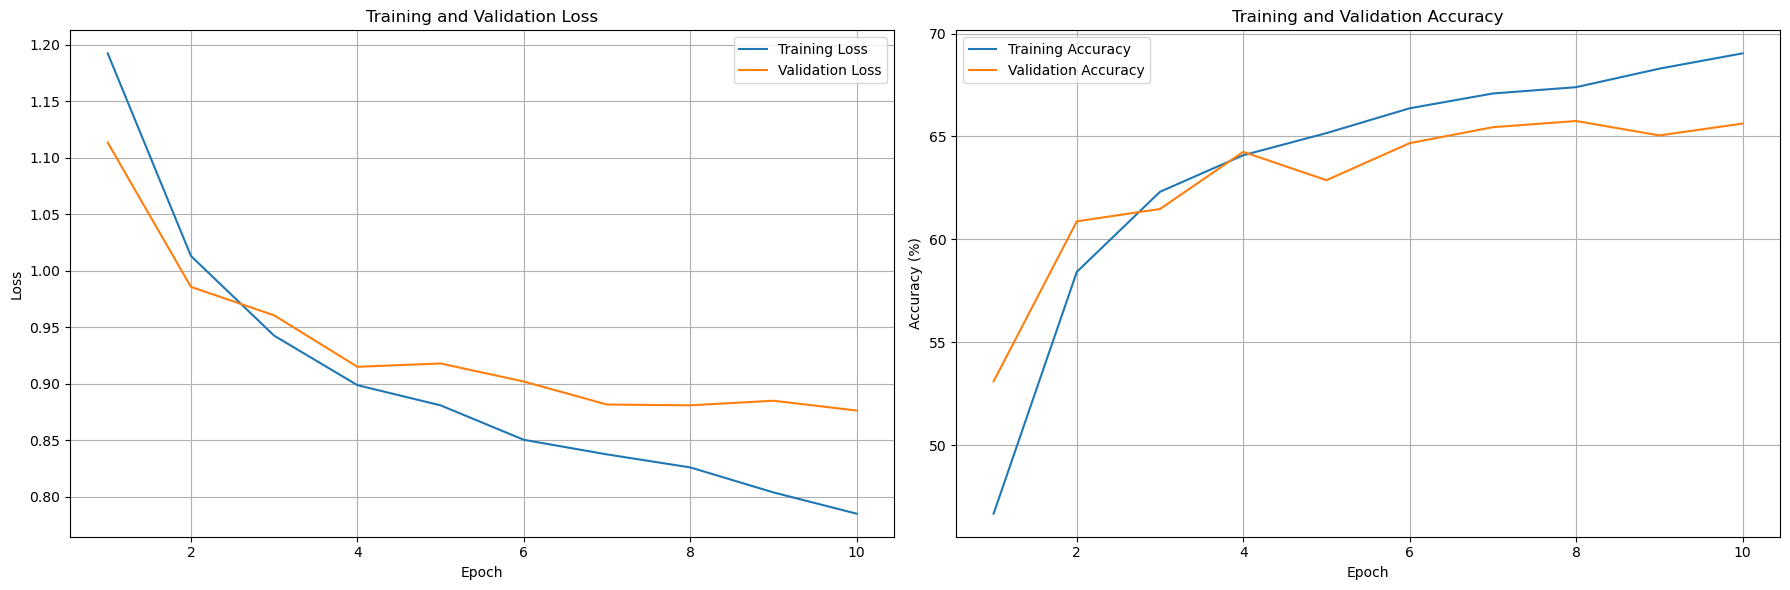

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
base_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    optimizer= optimizer,
    model = Lenet_cifar,
    mode='base',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.97it/s]


Validation Loss: 1.0346, Accuracy: 56.48%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 37.62it/s]


Validation Loss: 0.9612, Accuracy: 61.08%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.96it/s]


Validation Loss: 0.9220, Accuracy: 62.90%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.04it/s]


Validation Loss: 0.9413, Accuracy: 62.67%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.63it/s]


Validation Loss: 0.8983, Accuracy: 65.10%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.06it/s]


Validation Loss: 0.8709, Accuracy: 65.53%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.28it/s]


Validation Loss: 0.8517, Accuracy: 67.17%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.70it/s]


Validation Loss: 0.8415, Accuracy: 67.92%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.68it/s]


Validation Loss: 0.8575, Accuracy: 66.55%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.16it/s]


Validation Loss: 0.8391, Accuracy: 67.62%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.22it/s]

Test Loss: 0.6595, Accuracy: 77.15%


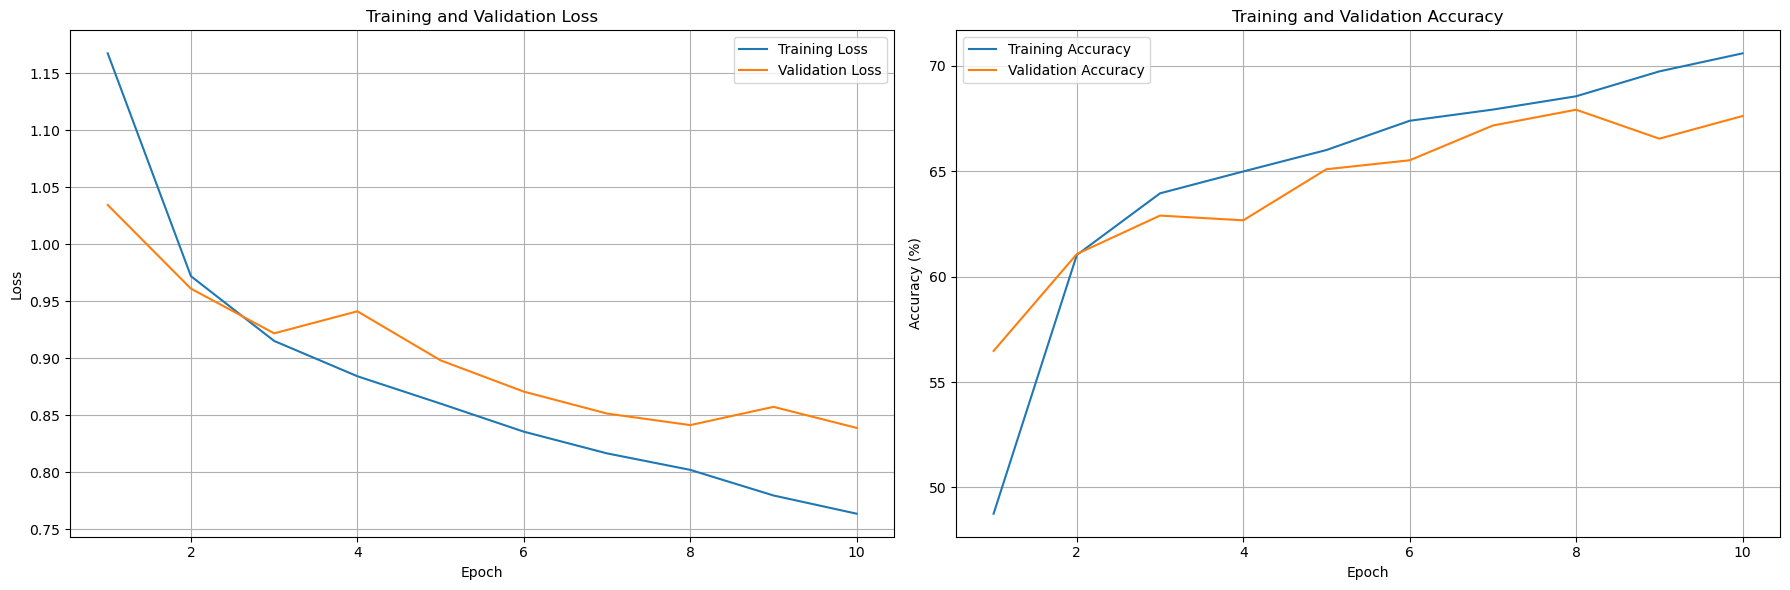

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

### Training for 10 times

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': Lenet_cifar,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 128,
    'num_epochs': 10
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_lenet_cifar,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.47it/s]


Validation Loss: 0.9314, Accuracy: 54.58%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.47it/s]


Validation Loss: 0.7328, Accuracy: 59.77%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.63it/s]


Validation Loss: 0.6117, Accuracy: 63.58%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.98it/s]


Validation Loss: 0.5807, Accuracy: 64.28%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.11it/s]


Validation Loss: 0.5722, Accuracy: 65.65%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.20it/s]


Validation Loss: 0.5245, Accuracy: 64.88%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.00it/s]


Validation Loss: 0.5258, Accuracy: 65.55%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.07it/s]


Validation Loss: 0.5083, Accuracy: 66.65%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.24it/s]


Validation Loss: 0.4801, Accuracy: 67.17%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.03it/s]


Validation Loss: 0.4692, Accuracy: 67.03%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.29it/s]


Test Loss: 0.4188, Accuracy: 76.10%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.22it/s]


Validation Loss: 0.9419, Accuracy: 53.05%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.66it/s]


Validation Loss: 0.7503, Accuracy: 58.65%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.56it/s]


Validation Loss: 0.6870, Accuracy: 60.55%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.83it/s]


Validation Loss: 0.6655, Accuracy: 61.25%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.35it/s]


Validation Loss: 0.6220, Accuracy: 62.02%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.80it/s]


Validation Loss: 0.5923, Accuracy: 63.38%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.11it/s]


Validation Loss: 0.5354, Accuracy: 64.00%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.10it/s]


Validation Loss: 0.5617, Accuracy: 63.70%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.86it/s]


Validation Loss: 0.4998, Accuracy: 64.12%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.44it/s]


Validation Loss: 0.5192, Accuracy: 64.15%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.83it/s]


Test Loss: 0.4417, Accuracy: 74.90%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.98it/s]


Validation Loss: 0.8789, Accuracy: 53.50%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.42it/s]


Validation Loss: 0.6488, Accuracy: 59.55%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.27it/s]


Validation Loss: 0.6527, Accuracy: 62.02%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.50it/s]


Validation Loss: 0.5965, Accuracy: 64.38%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.67it/s]


Validation Loss: 0.5229, Accuracy: 63.85%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.21it/s]


Validation Loss: 0.5459, Accuracy: 63.62%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.42it/s]


Validation Loss: 0.5245, Accuracy: 64.58%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.08it/s]


Validation Loss: 0.5496, Accuracy: 64.30%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.36it/s]


Validation Loss: 0.5121, Accuracy: 65.33%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.42it/s]


Validation Loss: 0.5135, Accuracy: 65.85%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.97it/s]


Test Loss: 0.4360, Accuracy: 76.72%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.57it/s]


Validation Loss: 0.8652, Accuracy: 56.40%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.28it/s]


Validation Loss: 0.7048, Accuracy: 60.90%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.43it/s]


Validation Loss: 0.6506, Accuracy: 63.20%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.88it/s]


Validation Loss: 0.6217, Accuracy: 64.25%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.91it/s]


Validation Loss: 0.5858, Accuracy: 65.30%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.38it/s]


Validation Loss: 0.5737, Accuracy: 65.83%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.37it/s]


Validation Loss: 0.5192, Accuracy: 66.67%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.36it/s]


Validation Loss: 0.4796, Accuracy: 67.42%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.79it/s]


Validation Loss: 0.4999, Accuracy: 66.75%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.60it/s]


Validation Loss: 0.4686, Accuracy: 66.50%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.72it/s]


Test Loss: 0.4164, Accuracy: 75.58%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.83it/s]


Validation Loss: 0.8710, Accuracy: 52.65%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.54it/s]


Validation Loss: 0.6951, Accuracy: 60.83%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.67it/s]


Validation Loss: 0.6384, Accuracy: 62.70%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.12it/s]


Validation Loss: 0.5914, Accuracy: 63.40%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.63it/s]


Validation Loss: 0.5419, Accuracy: 64.25%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.39it/s]


Validation Loss: 0.5650, Accuracy: 66.00%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.35it/s]


Validation Loss: 0.5077, Accuracy: 65.75%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.94it/s]


Validation Loss: 0.4770, Accuracy: 66.47%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.97it/s]


Validation Loss: 0.5003, Accuracy: 67.00%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.65it/s]


Validation Loss: 0.4683, Accuracy: 66.58%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.69it/s]


Test Loss: 0.4203, Accuracy: 76.25%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.79it/s]


Validation Loss: 0.8376, Accuracy: 55.05%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.37it/s]


Validation Loss: 0.6848, Accuracy: 61.95%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.11it/s]


Validation Loss: 0.6420, Accuracy: 63.27%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.68it/s]


Validation Loss: 0.6117, Accuracy: 64.55%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.65it/s]


Validation Loss: 0.5574, Accuracy: 64.72%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.80it/s]


Validation Loss: 0.5311, Accuracy: 65.55%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.15it/s]


Validation Loss: 0.5387, Accuracy: 66.10%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.13it/s]


Validation Loss: 0.4982, Accuracy: 66.20%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.69it/s]


Validation Loss: 0.5290, Accuracy: 67.33%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.18it/s]


Validation Loss: 0.4911, Accuracy: 66.60%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.93it/s]


Test Loss: 0.4157, Accuracy: 75.53%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.09it/s]


Validation Loss: 0.9565, Accuracy: 52.15%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.21it/s]


Validation Loss: 0.7409, Accuracy: 61.50%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.65it/s]


Validation Loss: 0.6554, Accuracy: 62.92%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.66it/s]


Validation Loss: 0.6037, Accuracy: 63.23%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.16it/s]


Validation Loss: 0.5743, Accuracy: 65.05%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.94it/s]


Validation Loss: 0.5512, Accuracy: 63.90%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.10it/s]


Validation Loss: 0.5119, Accuracy: 65.00%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.51it/s]


Validation Loss: 0.5100, Accuracy: 65.00%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.68it/s]


Validation Loss: 0.5125, Accuracy: 66.22%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.35it/s]


Validation Loss: 0.4954, Accuracy: 66.25%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.40it/s]


Test Loss: 0.4163, Accuracy: 76.35%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.94it/s]


Validation Loss: 0.8760, Accuracy: 55.92%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.76it/s]


Validation Loss: 0.6504, Accuracy: 59.58%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.42it/s]


Validation Loss: 0.6813, Accuracy: 61.35%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.60it/s]


Validation Loss: 0.6347, Accuracy: 62.85%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.29it/s]


Validation Loss: 0.6088, Accuracy: 63.90%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.86it/s]


Validation Loss: 0.5394, Accuracy: 64.65%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.42it/s]


Validation Loss: 0.5386, Accuracy: 64.67%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.56it/s]


Validation Loss: 0.5360, Accuracy: 65.10%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.29it/s]


Validation Loss: 0.4990, Accuracy: 65.30%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.16it/s]


Validation Loss: 0.5025, Accuracy: 65.45%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.99it/s]


Test Loss: 0.4291, Accuracy: 74.95%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.19it/s]


Validation Loss: 0.9872, Accuracy: 51.33%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.14it/s]


Validation Loss: 0.7463, Accuracy: 59.67%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.95it/s]


Validation Loss: 0.6594, Accuracy: 62.02%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.69it/s]


Validation Loss: 0.5887, Accuracy: 62.50%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.56it/s]


Validation Loss: 0.5437, Accuracy: 62.73%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.54it/s]


Validation Loss: 0.5884, Accuracy: 63.52%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.55it/s]


Validation Loss: 0.5433, Accuracy: 64.62%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.46it/s]


Validation Loss: 0.4916, Accuracy: 65.15%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.80it/s]


Validation Loss: 0.4831, Accuracy: 65.47%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.24it/s]


Validation Loss: 0.4819, Accuracy: 64.15%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.27it/s]


Test Loss: 0.4249, Accuracy: 74.65%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.10it/s]


Validation Loss: 0.9001, Accuracy: 53.83%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.50it/s]


Validation Loss: 0.7319, Accuracy: 60.00%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.20it/s]


Validation Loss: 0.6886, Accuracy: 60.58%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.22it/s]


Validation Loss: 0.6223, Accuracy: 61.80%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.92it/s]


Validation Loss: 0.5677, Accuracy: 63.60%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.79it/s]


Validation Loss: 0.5806, Accuracy: 64.35%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.62it/s]


Validation Loss: 0.5588, Accuracy: 63.38%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.31it/s]


Validation Loss: 0.5396, Accuracy: 65.03%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.47it/s]


Validation Loss: 0.5157, Accuracy: 65.60%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.67it/s]


Validation Loss: 0.4992, Accuracy: 66.05%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.58it/s]

Test Loss: 0.4354, Accuracy: 75.75%

Mean Test Accuracy: 75.68%
Standard Deviation of Test Accuracy: 0.65


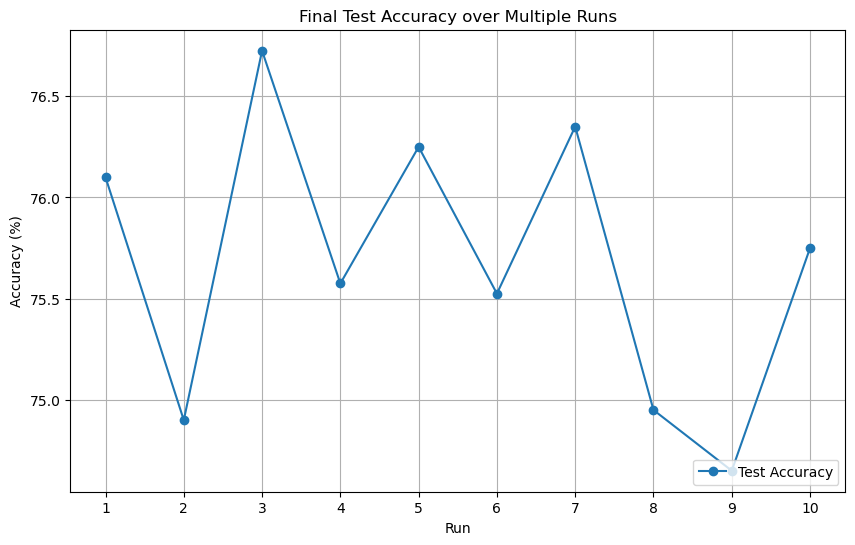

In [ ]:
plot_result(test_accuracies)

## ResNet_cifar

In [ ]:
resNet_cifar = ResNet18(num_classes=4).to(device)

### Estimating the T

In [ ]:
T_es = estimating(train_data_cifar,
                               model = resNet_cifar,
                               num_classes=4,
                               n_epoch_estimate=5,
                               batch_size=128,
                               lr=0.001
                              )

Estimating Transition Matrix...


Estimating Transition Matrix: 100%|██████████████████████████████████████| 160/160 [00:14<00:00, 10.68it/s, Loss=0.138]


Estimated Transition Matrix:
[[8.23900316e-01 1.62174667e-01 1.31734168e-02 7.51600461e-04]
 [5.98188110e-02 8.80895659e-01 5.78787281e-02 1.40680228e-03]
 [6.94950437e-02 1.25053465e-03 8.16127944e-01 1.13126477e-01]
 [9.77456563e-02 3.77538751e-03 9.43807133e-02 8.04098243e-01]]


In [ ]:
T_resnet_cifar = torch.from_numpy(T_es).float().to(device)

### Hyperparameter Tuning

#### Tuning for optimizer

In [ ]:
num_epochs = 5
batch_size = 64

In [ ]:
optimizer = 'SGD'
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=0.01,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 77.28it/s]


Validation Loss: 1.1107, Accuracy: 64.97%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 74.47it/s]


Validation Loss: 0.9273, Accuracy: 63.23%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 78.26it/s]


Validation Loss: 0.9240, Accuracy: 66.40%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 79.23it/s]


Validation Loss: 0.8756, Accuracy: 68.22%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.50it/s]


Validation Loss: 1.0286, Accuracy: 65.67%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 67.90it/s]

Test Loss: 0.7048, Accuracy: 75.22%


In [ ]:
optimizer = 'Adam'
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=0.001,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 77.71it/s]


Validation Loss: 0.8586, Accuracy: 66.90%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.69it/s]


Validation Loss: 0.8115, Accuracy: 68.90%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 76.14it/s]


Validation Loss: 0.8200, Accuracy: 68.35%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.33it/s]


Validation Loss: 0.7820, Accuracy: 69.83%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.46it/s]


Validation Loss: 0.7547, Accuracy: 72.30%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 68.27it/s]

Test Loss: 0.5830, Accuracy: 80.97%


#### Tuning for learning rate

In [ ]:
num_epochs = 5
batch_size = 64
optimizer = 'Adam'

In [ ]:
learning_rate = 0.0005
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 63.21it/s]


Validation Loss: 0.8492, Accuracy: 67.28%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 61.14it/s]


Validation Loss: 0.8615, Accuracy: 65.60%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 67.78it/s]


Validation Loss: 0.8230, Accuracy: 68.90%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.45it/s]


Validation Loss: 0.8042, Accuracy: 69.95%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.27it/s]


Validation Loss: 0.7753, Accuracy: 70.95%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 57.27it/s]

Test Loss: 0.6142, Accuracy: 80.12%


In [ ]:
learning_rate = 0.0001
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 80.11it/s]


Validation Loss: 0.7875, Accuracy: 69.72%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 79.02it/s]


Validation Loss: 0.7800, Accuracy: 70.25%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.79it/s]


Validation Loss: 0.7812, Accuracy: 70.60%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 68.08it/s]


Validation Loss: 0.8217, Accuracy: 69.40%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 74.01it/s]


Validation Loss: 0.9126, Accuracy: 68.85%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 75.33it/s]

Test Loss: 0.7000, Accuracy: 77.12%


#### Tuning for batch size

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
num_epochs = 5

In [ ]:
batch_size = 32
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 92.83it/s]


Validation Loss: 0.8819, Accuracy: 66.33%


Epoch 2 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 111.09it/s]


Validation Loss: 0.8217, Accuracy: 68.75%


Epoch 3 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 123.72it/s]


Validation Loss: 0.7992, Accuracy: 69.67%


Epoch 4 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 122.39it/s]


Validation Loss: 0.8032, Accuracy: 68.45%


Epoch 5 Validation: 100%|███████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 123.65it/s]


Validation Loss: 0.7641, Accuracy: 70.20%


Testing: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 117.20it/s]

Test Loss: 0.6210, Accuracy: 79.00%


In [ ]:
batch_size = 128
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.91it/s]


Validation Loss: 0.8999, Accuracy: 63.15%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.12it/s]


Validation Loss: 0.8455, Accuracy: 66.65%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.89it/s]


Validation Loss: 0.8216, Accuracy: 68.67%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.36it/s]


Validation Loss: 0.7786, Accuracy: 70.05%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.72it/s]


Validation Loss: 0.8109, Accuracy: 68.95%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.20it/s]

Test Loss: 0.5889, Accuracy: 79.60%


#### Tuning for nums of epochs

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64

In [ ]:
num_epochs = 10
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 58.15it/s]


Validation Loss: 0.9022, Accuracy: 63.70%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.10it/s]


Validation Loss: 0.8068, Accuracy: 68.20%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 74.43it/s]


Validation Loss: 0.8671, Accuracy: 65.85%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.73it/s]


Validation Loss: 0.9967, Accuracy: 64.90%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.00it/s]


Validation Loss: 0.7645, Accuracy: 71.08%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.61it/s]


Validation Loss: 0.7884, Accuracy: 70.15%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 59.70it/s]


Validation Loss: 0.7700, Accuracy: 70.53%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.84it/s]


Validation Loss: 0.7701, Accuracy: 71.35%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 66.77it/s]


Validation Loss: 0.8571, Accuracy: 70.75%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 61.92it/s]


Validation Loss: 0.8472, Accuracy: 71.10%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 55.66it/s]

Test Loss: 0.6328, Accuracy: 81.05%


In [ ]:
num_epochs = 15
model_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 63.85it/s]


Validation Loss: 1.0054, Accuracy: 59.98%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 75.54it/s]


Validation Loss: 0.8536, Accuracy: 66.17%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.63it/s]


Validation Loss: 0.8086, Accuracy: 69.70%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.08it/s]


Validation Loss: 0.8105, Accuracy: 69.88%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 71.20it/s]


Validation Loss: 0.8092, Accuracy: 69.95%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 71.49it/s]


Validation Loss: 0.7977, Accuracy: 71.55%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 58.47it/s]


Validation Loss: 0.7871, Accuracy: 71.45%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 68.55it/s]


Validation Loss: 0.8436, Accuracy: 70.17%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.27it/s]


Validation Loss: 0.8580, Accuracy: 70.60%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 66.42it/s]


Validation Loss: 0.9207, Accuracy: 69.85%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 75.35it/s]


Validation Loss: 0.9303, Accuracy: 71.03%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.56it/s]


Validation Loss: 1.0671, Accuracy: 70.05%


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 70.49it/s]


Validation Loss: 1.1863, Accuracy: 69.05%


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.33it/s]


Validation Loss: 1.2964, Accuracy: 67.97%


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 58.74it/s]


Validation Loss: 1.5027, Accuracy: 67.35%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 58.88it/s]

Test Loss: 1.0781, Accuracy: 77.15%


### Comparison Experiment

In [ ]:
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [ ]:
best_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='foward',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.89it/s]


Validation Loss: 0.8889, Accuracy: 64.30%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 75.99it/s]


Validation Loss: 0.8387, Accuracy: 67.58%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 78.65it/s]


Validation Loss: 0.8197, Accuracy: 68.08%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 69.83it/s]


Validation Loss: 0.7874, Accuracy: 69.55%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 66.56it/s]


Validation Loss: 0.8086, Accuracy: 68.35%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.45it/s]


Validation Loss: 0.8752, Accuracy: 65.45%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 51.82it/s]


Validation Loss: 0.8119, Accuracy: 70.15%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.05it/s]


Validation Loss: 0.7985, Accuracy: 70.47%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.51it/s]


Validation Loss: 0.8506, Accuracy: 69.53%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 67.13it/s]


Validation Loss: 0.8770, Accuracy: 70.25%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 71.03it/s]

Test Loss: 0.6517, Accuracy: 80.40%


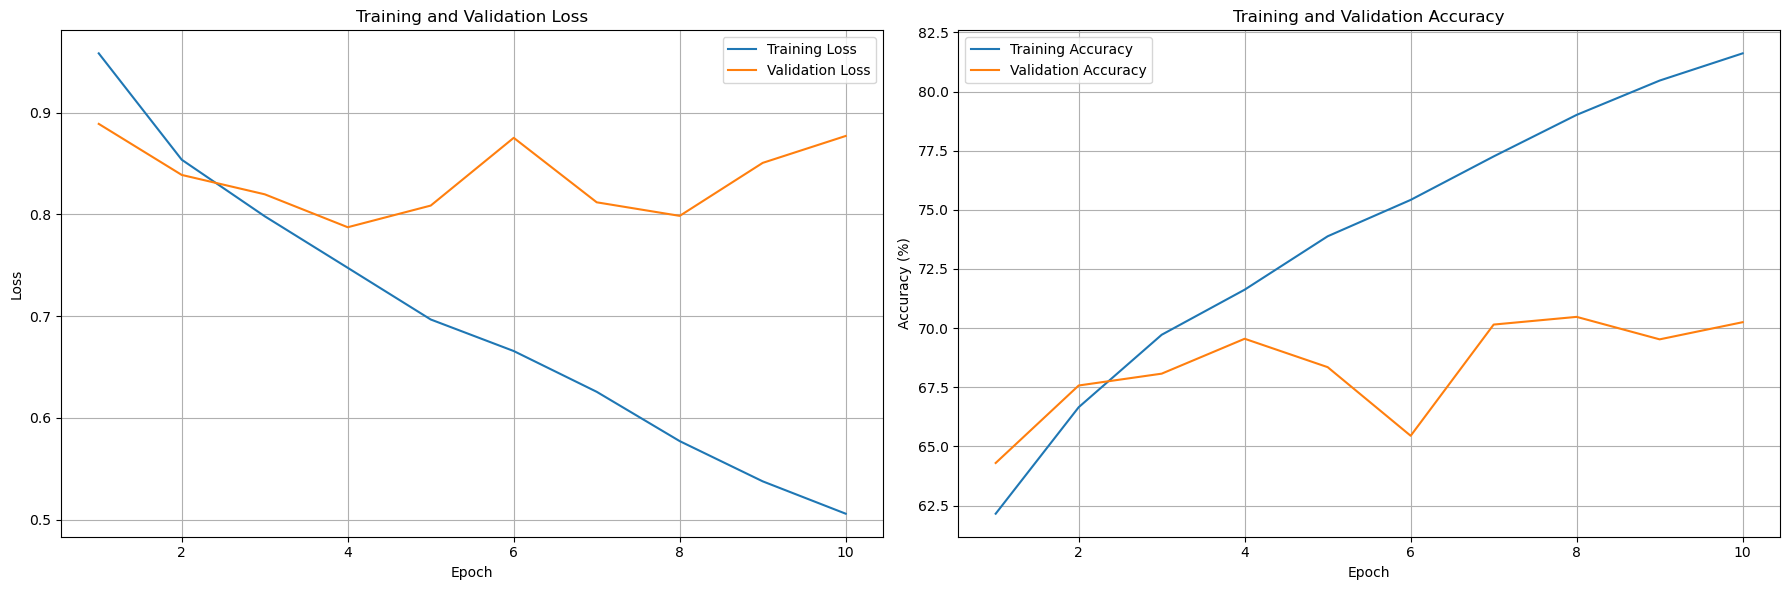

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
base_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = resNet_cifar,
    mode='base',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 71.45it/s]


Validation Loss: 0.8989, Accuracy: 65.55%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 66.85it/s]


Validation Loss: 0.8275, Accuracy: 68.12%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 62.51it/s]


Validation Loss: 0.8305, Accuracy: 68.12%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 71.44it/s]


Validation Loss: 0.8176, Accuracy: 68.72%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.28it/s]


Validation Loss: 0.7891, Accuracy: 70.72%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.93it/s]


Validation Loss: 0.7746, Accuracy: 71.22%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 78.03it/s]


Validation Loss: 0.7947, Accuracy: 71.60%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.65it/s]


Validation Loss: 0.7969, Accuracy: 71.78%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65.37it/s]


Validation Loss: 0.8513, Accuracy: 70.03%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 59.40it/s]


Validation Loss: 0.9070, Accuracy: 68.72%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 64.96it/s]

Test Loss: 0.6767, Accuracy: 79.38%


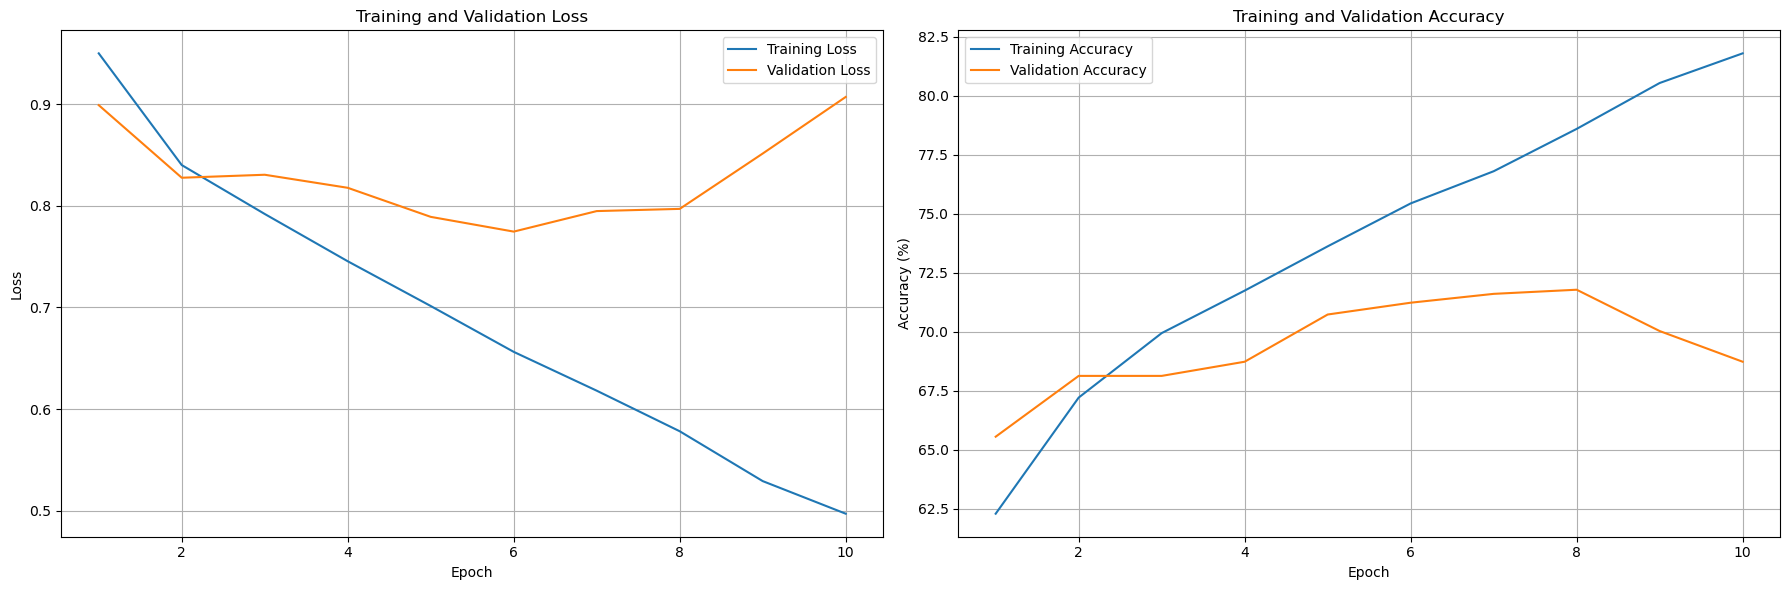

In [ ]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
revision_cifar, train_losses, val_losses, train_accuracies, val_accuracies, test_acc = training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    optimizer= optimizer,
    model = best_cifar,
    mode='revision',
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.45it/s]


Validation Loss: 0.0811, Accuracy: 75.78%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.50it/s]


Validation Loss: 0.0731, Accuracy: 70.72%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.00it/s]


Validation Loss: 0.0551, Accuracy: 73.55%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.86it/s]


Validation Loss: 0.0537, Accuracy: 74.15%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.96it/s]


Validation Loss: 0.0516, Accuracy: 73.08%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.25it/s]


Validation Loss: 0.0510, Accuracy: 73.55%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.21it/s]


Validation Loss: 0.0478, Accuracy: 72.70%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.33it/s]


Validation Loss: 0.0490, Accuracy: 72.67%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.09it/s]


Validation Loss: 0.0459, Accuracy: 67.62%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.30it/s]


Validation Loss: 0.0464, Accuracy: 71.90%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.12it/s]

Test Loss: 0.0433, Accuracy: 77.25%


### Training for 10 times

In [ ]:
training_params = {
    'optimizer': 'Adam',
    'model': resNet_cifar,
    'mode': 'forward',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 10
}

test_accuracies, mean_accuracy, std_accuracy = multiple_training(
    train_dataset=train_data_cifar,
    test_dataset=test_data_cifar,
    T=T_resnet_cifar,
    n_runs=10,
    **training_params
)


--- Run 1/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.85it/s]


Validation Loss: 0.6796, Accuracy: 62.88%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.24it/s]


Validation Loss: 0.5762, Accuracy: 67.30%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.36it/s]


Validation Loss: 0.5087, Accuracy: 69.10%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.71it/s]


Validation Loss: 0.4642, Accuracy: 69.65%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.76it/s]


Validation Loss: 0.4631, Accuracy: 68.88%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.74it/s]


Validation Loss: 0.4443, Accuracy: 69.03%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.21it/s]


Validation Loss: 0.4249, Accuracy: 69.65%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.67it/s]


Validation Loss: 0.3972, Accuracy: 70.05%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.97it/s]


Validation Loss: 0.3258, Accuracy: 70.75%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.87it/s]


Validation Loss: 0.3591, Accuracy: 69.17%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.53it/s]


Test Loss: 0.3287, Accuracy: 79.55%

--- Run 2/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.03it/s]


Validation Loss: 0.5844, Accuracy: 64.12%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.53it/s]


Validation Loss: 0.5589, Accuracy: 67.72%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.60it/s]


Validation Loss: 0.5064, Accuracy: 69.15%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.03it/s]


Validation Loss: 0.4920, Accuracy: 69.88%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.41it/s]


Validation Loss: 0.4421, Accuracy: 69.88%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.02it/s]


Validation Loss: 0.4144, Accuracy: 70.15%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.85it/s]


Validation Loss: 0.3838, Accuracy: 70.80%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.26it/s]


Validation Loss: 0.3240, Accuracy: 70.35%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.46it/s]


Validation Loss: 0.3487, Accuracy: 71.83%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.24it/s]


Validation Loss: 0.3655, Accuracy: 70.95%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.22it/s]


Test Loss: 0.3121, Accuracy: 80.75%

--- Run 3/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.31it/s]


Validation Loss: 0.5621, Accuracy: 62.27%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.59it/s]


Validation Loss: 0.5360, Accuracy: 63.80%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.50it/s]


Validation Loss: 0.5051, Accuracy: 67.50%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.78it/s]


Validation Loss: 0.4702, Accuracy: 69.72%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.37it/s]


Validation Loss: 0.4112, Accuracy: 69.30%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.30it/s]


Validation Loss: 0.4490, Accuracy: 70.78%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.51it/s]


Validation Loss: 0.4182, Accuracy: 70.92%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.14it/s]


Validation Loss: 0.3702, Accuracy: 70.03%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.52it/s]


Validation Loss: 0.3606, Accuracy: 69.78%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.39it/s]


Validation Loss: 0.4193, Accuracy: 68.10%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.55it/s]


Test Loss: 0.4008, Accuracy: 77.10%

--- Run 4/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.17it/s]


Validation Loss: 0.6183, Accuracy: 63.95%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.12it/s]


Validation Loss: 0.5987, Accuracy: 68.00%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.54it/s]


Validation Loss: 0.5052, Accuracy: 69.00%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.36it/s]


Validation Loss: 0.4097, Accuracy: 71.30%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.18it/s]


Validation Loss: 0.3958, Accuracy: 71.22%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.81it/s]


Validation Loss: 0.4413, Accuracy: 72.08%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.67it/s]


Validation Loss: 0.3473, Accuracy: 71.65%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.82it/s]


Validation Loss: 0.3835, Accuracy: 70.92%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.03it/s]


Validation Loss: 0.3405, Accuracy: 71.85%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.63it/s]


Validation Loss: 0.3709, Accuracy: 70.08%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.71it/s]


Test Loss: 0.3259, Accuracy: 79.90%

--- Run 5/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.72it/s]


Validation Loss: 0.5748, Accuracy: 65.25%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.63it/s]


Validation Loss: 0.5750, Accuracy: 63.88%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.79it/s]


Validation Loss: 0.5497, Accuracy: 65.90%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.12it/s]


Validation Loss: 0.4568, Accuracy: 69.40%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.01it/s]


Validation Loss: 0.4262, Accuracy: 69.28%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.09it/s]


Validation Loss: 0.4455, Accuracy: 69.28%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.94it/s]


Validation Loss: 0.4438, Accuracy: 68.47%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.91it/s]


Validation Loss: 0.3457, Accuracy: 70.15%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.31it/s]


Validation Loss: 0.3851, Accuracy: 69.65%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.47it/s]


Validation Loss: 0.3864, Accuracy: 67.72%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.55it/s]


Test Loss: 0.3437, Accuracy: 77.28%

--- Run 6/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.31it/s]


Validation Loss: 0.8308, Accuracy: 56.27%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.31it/s]


Validation Loss: 0.5369, Accuracy: 68.40%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.37it/s]


Validation Loss: 0.5131, Accuracy: 67.38%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.91it/s]


Validation Loss: 0.5077, Accuracy: 70.72%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.82it/s]


Validation Loss: 0.4086, Accuracy: 71.12%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.97it/s]


Validation Loss: 0.4219, Accuracy: 71.97%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.62it/s]


Validation Loss: 0.4140, Accuracy: 71.58%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.48it/s]


Validation Loss: 0.3326, Accuracy: 71.53%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.45it/s]


Validation Loss: 0.3620, Accuracy: 70.50%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.53it/s]


Validation Loss: 0.3770, Accuracy: 69.90%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.10it/s]


Test Loss: 0.3664, Accuracy: 78.95%

--- Run 7/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.59it/s]


Validation Loss: 0.5922, Accuracy: 64.97%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.99it/s]


Validation Loss: 0.5688, Accuracy: 63.55%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.25it/s]


Validation Loss: 0.5427, Accuracy: 66.47%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.28it/s]


Validation Loss: 0.5506, Accuracy: 67.50%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.76it/s]


Validation Loss: 0.4419, Accuracy: 68.40%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 29.47it/s]


Validation Loss: 0.4243, Accuracy: 70.15%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.77it/s]


Validation Loss: 0.4261, Accuracy: 71.08%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.99it/s]


Validation Loss: 0.3938, Accuracy: 71.20%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.88it/s]


Validation Loss: 0.3344, Accuracy: 71.58%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.14it/s]


Validation Loss: 0.3778, Accuracy: 70.45%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.25it/s]


Test Loss: 0.3349, Accuracy: 79.88%

--- Run 8/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.16it/s]


Validation Loss: 0.6023, Accuracy: 62.88%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.11it/s]


Validation Loss: 0.5463, Accuracy: 66.78%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.27it/s]


Validation Loss: 0.4575, Accuracy: 69.00%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.67it/s]


Validation Loss: 0.4069, Accuracy: 69.35%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.98it/s]


Validation Loss: 0.4745, Accuracy: 69.40%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.01it/s]


Validation Loss: 0.4429, Accuracy: 69.12%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.96it/s]


Validation Loss: 0.4218, Accuracy: 71.05%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.32it/s]


Validation Loss: 0.3780, Accuracy: 70.38%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.17it/s]


Validation Loss: 0.3836, Accuracy: 70.10%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.95it/s]


Validation Loss: 0.3500, Accuracy: 70.47%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.46it/s]


Test Loss: 0.3224, Accuracy: 80.10%

--- Run 9/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.46it/s]


Validation Loss: 0.6316, Accuracy: 63.88%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.60it/s]


Validation Loss: 0.5138, Accuracy: 66.58%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.98it/s]


Validation Loss: 0.5519, Accuracy: 67.05%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.06it/s]


Validation Loss: 0.4997, Accuracy: 69.42%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.19it/s]


Validation Loss: 0.4764, Accuracy: 69.88%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.12it/s]


Validation Loss: 0.4270, Accuracy: 68.35%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.03it/s]


Validation Loss: 0.3708, Accuracy: 70.53%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.03it/s]


Validation Loss: 0.3514, Accuracy: 69.75%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.96it/s]


Validation Loss: 0.3677, Accuracy: 71.28%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.84it/s]


Validation Loss: 0.3833, Accuracy: 70.45%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.07it/s]


Test Loss: 0.3394, Accuracy: 79.15%

--- Run 10/10 ---


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.94it/s]


Validation Loss: 0.6008, Accuracy: 64.30%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.61it/s]


Validation Loss: 0.5437, Accuracy: 68.20%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.91it/s]


Validation Loss: 0.4851, Accuracy: 68.67%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.56it/s]


Validation Loss: 0.4787, Accuracy: 68.17%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.92it/s]


Validation Loss: 0.4603, Accuracy: 69.28%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.56it/s]


Validation Loss: 0.4884, Accuracy: 69.70%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.59it/s]


Validation Loss: 0.3862, Accuracy: 71.75%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.22it/s]


Validation Loss: 0.4470, Accuracy: 65.60%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.15it/s]


Validation Loss: 0.3857, Accuracy: 70.42%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.92it/s]


Validation Loss: 0.3570, Accuracy: 71.10%


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.84it/s]

Test Loss: 0.3035, Accuracy: 81.47%

Mean Test Accuracy: 79.41%
Standard Deviation of Test Accuracy: 1.31


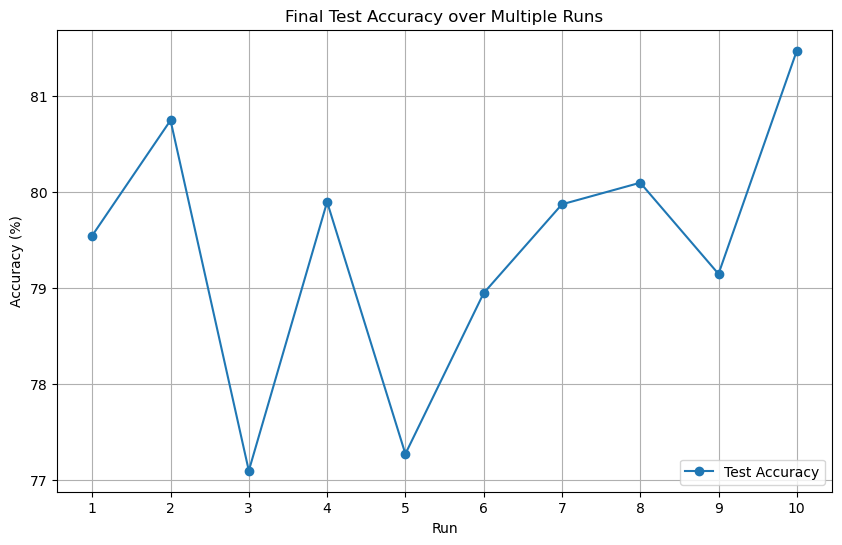

In [ ]:
plot_result(test_accuracies)